## Load in packages

In [1]:
library(data.table)
library(ggplot2)
library(corrplot)
library(patchwork)
library(gtools)
library(tableone)
library(RColorBrewer)
library(survival)
library(survminer)
library(pROC)
library(tableone)
library(splines)
library(forestplot)

Warning message:
"replacing previous import 'vctrs::data_frame' by 'tibble::data_frame' when loading 'dplyr'"
corrplot 0.84 loaded

Loading required package: ggpubr

Loading required package: magrittr

Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


Loading required package: grid

Loading required package: checkmate


Attaching package: 'checkmate'


The following object is masked from 'package:gtools':

    assert




## Write custom functions

In [2]:
saaketSumm <- function(dat){
    print(dim(dat))
    print(names(dat))
    return(head(dat))
}

unlogit <- function(val){
    return((exp(val)/(1+exp(val))))
}

## Read in data and define new variables

In [3]:
fatPhenoCovarLifestyle2 <- fread('/medpop/esp2/sagrawal/fat_distribution/2021.03.11_datafreeze/fatPhenoCovarWithLifestyle2.csv')

In [4]:
names(fatPhenoCovarLifestyle2)

[1] "eid"                      "vat"                     
 [3] "asat"                     "gfat"                    
 [5] "vatadjbmi"                "asatadjbmi"              
 [7] "gfatadjbmi"               "vatAsatRatio"            
 [9] "vatGfatRatio"             "asatGfatRatio"           
[11] "bmiCalc"                  "waistcmInstance2"        
[13] "WHRInstance2"             "WHRadjbmiInstance2"      
[15] "age_instance2"            "age_instance2_sq"        
[17] "sex"                      "mriNum"                  
[19] "genotyping_array"         "PC1"                     
[21] "PC2"                      "PC3"                     
[23] "PC4"                      "PC5"                     
[25] "PC6"                      "PC7"                     
[27] "PC8"                      "PC9"                     
[29] "PC10"                     "fruitStrat"              
[31] "vegStrat"                 "wholeGrainStrat"         
[33] "fishStrat"                "refinedStrat"            
[35] "processedMeatStrat"       "unprocessedMeatStrat"    
[37] "sugarDrinkStrat"          "dietSum"                 
[39] "dietStrat"                "walkingActivity"         
[41] "walkingActivityDays"      "moderateActivity"        
[43] "moderateActivityDays"     "vigorousActivity"        
[45] "vigorousActivityDays"     "walkingMETs"             
[47] "moderateMETs"             "vigorousMETs"            
[49] "totalMETs"                "smokingStatus"           
[51] "ageStoppedSmoking"        "smokingStrat"            
[53] "hadMenopause"             "prev_CAD_int"            
[55] "inc_CAD_int"              "fu_CAD_int"              
[57] "prev_T2D"                 "inc_T2D"                 
[59] "fu_T2D"                   "prev_T2D_og"             
[61] "inc_T2D_og"               "prev_ischemicStroke"     
[63] "inc_ischemicStroke"       "fu_ischemicStroke"       
[65] "prev_ischemicStrokew6150" "inc_ischemicStrokew6150" 
[67] "fu_ischemicStrokew6150"   "sbpInstance2"            
[69] "dbpInstance2"             "ethnicity_group"         
[71] "heightInstance2"          "heightInstance0"         
[73] "weightInstance2"          "hipcmInstance2"          
[75] "heightCombined"

In [5]:
fatPhenoCovarLifestyle2$ethnicity_group <- factor(fatPhenoCovarLifestyle2$ethnicity_group,
                                                 levels=c('White','Black','East Asian','South Asian','Other'))

In [6]:
#Define BMI adjusted parameters

fatPhenoCovarLifestyle2[sex=='Male',vatadjbmi:=residuals(lm(vat~bmiCalc,fatPhenoCovarLifestyle2[sex=='Male'],na.action = na.exclude))]
fatPhenoCovarLifestyle2[sex=='Female',vatadjbmi:=residuals(lm(vat~bmiCalc,fatPhenoCovarLifestyle2[sex=='Female'],na.action = na.exclude))]

fatPhenoCovarLifestyle2[sex=='Male',asatadjbmi:=residuals(lm(asat~bmiCalc,fatPhenoCovarLifestyle2[sex=='Male'],na.action = na.exclude))]
fatPhenoCovarLifestyle2[sex=='Female',asatadjbmi:=residuals(lm(asat~bmiCalc,fatPhenoCovarLifestyle2[sex=='Female'],na.action = na.exclude))]

fatPhenoCovarLifestyle2[sex=='Male',gfatadjbmi:=residuals(lm(gfat~bmiCalc,fatPhenoCovarLifestyle2[sex=='Male'],na.action = na.exclude))]
fatPhenoCovarLifestyle2[sex=='Female',gfatadjbmi:=residuals(lm(gfat~bmiCalc,fatPhenoCovarLifestyle2[sex=='Female'],na.action = na.exclude))]

#As a sensitivity analysis, we additionally define BMI adjusted parameters using a spline basis

fatPhenoCovarLifestyle2[sex=='Male',vatadjbmiSpline:=residuals(lm(vat~bs(bmiCalc,knots=c(25,30,35)),fatPhenoCovarLifestyle2[sex=='Male'],na.action = na.exclude))]
fatPhenoCovarLifestyle2[sex=='Female',vatadjbmiSpline:=residuals(lm(vat~bs(bmiCalc,knots=c(25,30,35)),fatPhenoCovarLifestyle2[sex=='Female'],na.action = na.exclude))]

fatPhenoCovarLifestyle2[sex=='Male',asatadjbmiSpline:=residuals(lm(asat~bs(bmiCalc,knots=c(25,30,35)),fatPhenoCovarLifestyle2[sex=='Male'],na.action = na.exclude))]
fatPhenoCovarLifestyle2[sex=='Female',asatadjbmiSpline:=residuals(lm(asat~bs(bmiCalc,knots=c(25,30,35)),fatPhenoCovarLifestyle2[sex=='Female'],na.action = na.exclude))]

fatPhenoCovarLifestyle2[sex=='Male',gfatadjbmiSpline:=residuals(lm(gfat~bs(bmiCalc,knots=c(25,30,35)),fatPhenoCovarLifestyle2[sex=='Male'],na.action = na.exclude))]
fatPhenoCovarLifestyle2[sex=='Female',gfatadjbmiSpline:=residuals(lm(gfat~bs(bmiCalc,knots=c(25,30,35)),fatPhenoCovarLifestyle2[sex=='Female'],na.action = na.exclude))]

In [7]:
fatNames <- names(fatPhenoCovarLifestyle2)[c(2:14,74,76:78)]

for(i in 1:length(fatNames)){
    fatPhenoCovarLifestyle2[,paste0(fatNames[i],'Scaled'):=scale(eval(as.name(fatNames[i]))),by=sex]
}

In [8]:
fatPhenoCovarLifestyle2[bmiCalc < 25, bmiGroup:='Normal']
fatPhenoCovarLifestyle2[bmiCalc >= 25 & bmiCalc < 30, bmiGroup:='Overweight']
fatPhenoCovarLifestyle2[bmiCalc >= 30, bmiGroup:='Obese']

fatPhenoCovarLifestyle2[age_instance2 < 60, ageGroup:='Under 60']
fatPhenoCovarLifestyle2[age_instance2 >= 60 & age_instance2 < 70, ageGroup:='60 to 70']
fatPhenoCovarLifestyle2[age_instance2 >= 70, ageGroup:='Over 70']

fatPhenoCovarLifestyle2$bmiGroup <- factor(fatPhenoCovarLifestyle2$bmiGroup,levels=c('Normal','Overweight','Obese'))

fatPhenoCovarLifestyle2$ageGroup <- factor(fatPhenoCovarLifestyle2$ageGroup,levels=c('Under 60','60 to 70','Over 70'))

In [9]:
# Sensitivity analysis requested in revision, add ethnicity specific cutoffs based on:
# https://diabetesjournals.org/care/article/37/9/2500/29021/Ethnic-Specific-Obesity-Cutoffs-for-Diabetes-Risk

fatPhenoCovarLifestyle2[bmiCalc < 30, bmiDichotJoint:='Low']
fatPhenoCovarLifestyle2[bmiCalc >= 30, bmiDichotJoint:='High']
fatPhenoCovarLifestyle2$bmiDichotJoint <- factor(fatPhenoCovarLifestyle2$bmiDichotJoint,
                                                levels=c('Low','High'))

fatPhenoCovarLifestyle2[ethnicity_group=='White'&bmiCalc < 30, bmiDichotEthnicity:='Low']
fatPhenoCovarLifestyle2[ethnicity_group=='White'&bmiCalc >= 30, bmiDichotEthnicity:='High']

fatPhenoCovarLifestyle2[ethnicity_group=='Black'&bmiCalc < 26, bmiDichotEthnicity:='Low']
fatPhenoCovarLifestyle2[ethnicity_group=='Black'&bmiCalc >= 26, bmiDichotEthnicity:='High']

fatPhenoCovarLifestyle2[ethnicity_group=='South Asian'&bmiCalc < 22, bmiDichotEthnicity:='Low']
fatPhenoCovarLifestyle2[ethnicity_group=='South Asian'&bmiCalc >= 22, bmiDichotEthnicity:='High']

fatPhenoCovarLifestyle2[ethnicity_group=='East Asian'&bmiCalc < 26, bmiDichotEthnicity:='Low']
fatPhenoCovarLifestyle2[ethnicity_group=='East Asian'&bmiCalc >= 24, bmiDichotEthnicity:='High']

fatPhenoCovarLifestyle2$bmiDichotEthnicity <- factor(fatPhenoCovarLifestyle2$bmiDichotEthnicity,
                                                levels=c('Low','High'))

In [10]:
fatPhenoCovarLifestyle2[!is.na(bmiCalc), vatadjbmiQuintiles := quantcut(vatadjbmi,5,labels=paste0('Q',1:5)), by=c('sex','bmiGroup')]
fatPhenoCovarLifestyle2[!is.na(bmiCalc), asatadjbmiQuintiles := quantcut(asatadjbmi,5,labels=paste0('Q',1:5)), by=c('sex','bmiGroup')]
fatPhenoCovarLifestyle2[!is.na(bmiCalc), gfatadjbmiQuintiles := quantcut(gfatadjbmi,5,labels=paste0('Q',1:5)), by=c('sex','bmiGroup')]

fatPhenoCovarLifestyle2[vatadjbmiQuintiles=='Q1', vatadjbmiQuintilesStrat := 'Q1']
fatPhenoCovarLifestyle2[vatadjbmiQuintiles%in%c('Q2','Q3','Q4'), vatadjbmiQuintilesStrat := 'Q2_Q4']
fatPhenoCovarLifestyle2[vatadjbmiQuintiles=='Q5', vatadjbmiQuintilesStrat := 'Q5']
fatPhenoCovarLifestyle2$vatadjbmiQuintilesStrat <- factor(fatPhenoCovarLifestyle2$vatadjbmiQuintilesStrat)

fatPhenoCovarLifestyle2[asatadjbmiQuintiles=='Q1', asatadjbmiQuintilesStrat := 'Q1']
fatPhenoCovarLifestyle2[asatadjbmiQuintiles%in%c('Q2','Q3','Q4'), asatadjbmiQuintilesStrat := 'Q2_Q4']
fatPhenoCovarLifestyle2[asatadjbmiQuintiles=='Q5', asatadjbmiQuintilesStrat := 'Q5']
fatPhenoCovarLifestyle2$asatadjbmiQuintilesStrat <- factor(fatPhenoCovarLifestyle2$asatadjbmiQuintilesStrat)

fatPhenoCovarLifestyle2[gfatadjbmiQuintiles=='Q1', gfatadjbmiQuintilesStrat := 'Q1']
fatPhenoCovarLifestyle2[gfatadjbmiQuintiles%in%c('Q2','Q3','Q4'), gfatadjbmiQuintilesStrat := 'Q2_Q4']
fatPhenoCovarLifestyle2[gfatadjbmiQuintiles=='Q5', gfatadjbmiQuintilesStrat := 'Q5']
fatPhenoCovarLifestyle2$gfatadjbmiQuintilesStrat <- factor(fatPhenoCovarLifestyle2$gfatadjbmiQuintilesStrat)


## Compare BMI adjusted fat depots generated from (1) simple linear residualization vs. (2) spline-based residualization

In [11]:
fatPhenoCovarLifestyle2[sex=='Male',vat_bmiPred:=predict(lm(vat~bmiCalc,fatPhenoCovarLifestyle2[sex=='Male'],na.action = na.exclude))]
fatPhenoCovarLifestyle2[sex=='Female',vat_bmiPred:=predict(lm(vat~bmiCalc,fatPhenoCovarLifestyle2[sex=='Female'],na.action = na.exclude))]

fatPhenoCovarLifestyle2[sex=='Male',asat_bmiPred:=predict(lm(asat~bmiCalc,fatPhenoCovarLifestyle2[sex=='Male'],na.action = na.exclude))]
fatPhenoCovarLifestyle2[sex=='Female',asat_bmiPred:=predict(lm(asat~bmiCalc,fatPhenoCovarLifestyle2[sex=='Female'],na.action = na.exclude))]

fatPhenoCovarLifestyle2[sex=='Male',gfat_bmiPred:=predict(lm(gfat~bmiCalc,fatPhenoCovarLifestyle2[sex=='Male'],na.action = na.exclude))]
fatPhenoCovarLifestyle2[sex=='Female',gfat_bmiPred:=predict(lm(gfat~bmiCalc,fatPhenoCovarLifestyle2[sex=='Female'],na.action = na.exclude))]


In [12]:
fatPhenoCovarLifestyle2[sex=='Male',vat_bmiSplinePred:=predict(lm(vat~bs(bmiCalc,knots=c(25,30,35)),fatPhenoCovarLifestyle2[sex=='Male'],na.action = na.exclude))]
fatPhenoCovarLifestyle2[sex=='Female',vat_bmiSplinePred:=predict(lm(vat~bs(bmiCalc,knots=c(25,30,35)),fatPhenoCovarLifestyle2[sex=='Female'],na.action = na.exclude))]

fatPhenoCovarLifestyle2[sex=='Male',asat_bmiSplinePred:=predict(lm(asat~bs(bmiCalc,knots=c(25,30,35)),fatPhenoCovarLifestyle2[sex=='Male'],na.action = na.exclude))]
fatPhenoCovarLifestyle2[sex=='Female',asat_bmiSplinePred:=predict(lm(asat~bs(bmiCalc,knots=c(25,30,35)),fatPhenoCovarLifestyle2[sex=='Female'],na.action = na.exclude))]

fatPhenoCovarLifestyle2[sex=='Male',gfat_bmiSplinePred:=predict(lm(gfat~bs(bmiCalc,knots=c(25,30,35)),fatPhenoCovarLifestyle2[sex=='Male'],na.action = na.exclude))]
fatPhenoCovarLifestyle2[sex=='Female',gfat_bmiSplinePred:=predict(lm(gfat~bs(bmiCalc,knots=c(25,30,35)),fatPhenoCovarLifestyle2[sex=='Female'],na.action = na.exclude))]


In [13]:
round(cor(fatPhenoCovarLifestyle2[sex=='Male'&!is.na(vatadjbmi),c('vatadjbmi','vatadjbmiSpline')])[1,2],3)
round(cor(fatPhenoCovarLifestyle2[sex=='Female'&!is.na(vatadjbmi),c('vatadjbmi','vatadjbmiSpline')])[1,2],3)

round(cor(fatPhenoCovarLifestyle2[sex=='Male'&!is.na(asatadjbmi),c('asatadjbmi','asatadjbmiSpline')])[1,2],3)
round(cor(fatPhenoCovarLifestyle2[sex=='Female'&!is.na(asatadjbmi),c('asatadjbmi','asatadjbmiSpline')])[1,2],3)

round(cor(fatPhenoCovarLifestyle2[sex=='Male'&!is.na(gfatadjbmi),c('gfatadjbmi','gfatadjbmiSpline')])[1,2],3)
round(cor(fatPhenoCovarLifestyle2[sex=='Female'&!is.na(gfatadjbmi),c('gfatadjbmi','gfatadjbmiSpline')])[1,2],3)

[1] 0.983

[1] 0.991

[1] 0.983

[1] 0.993

[1] 0.996

[1] 0.999

Warning message:
"Removed 625 rows containing missing values (geom_point)."
Warning message:
"Removed 625 row(s) containing missing values (geom_path)."
Warning message:
"Removed 625 row(s) containing missing values (geom_path)."
Warning message:
"Removed 727 rows containing missing values (geom_point)."
Warning message:
"Removed 727 row(s) containing missing values (geom_path)."
Warning message:
"Removed 727 row(s) containing missing values (geom_path)."
Warning message:
"Removed 625 rows containing missing values (geom_point)."
Warning message:
"Removed 625 row(s) containing missing values (geom_path)."
Warning message:
"Removed 625 row(s) containing missing values (geom_path)."
Warning message:
"Removed 727 rows containing missing values (geom_point)."
Warning message:
"Removed 727 row(s) containing missing values (geom_path)."
Warning message:
"Removed 727 row(s) containing missing values (geom_path)."
Warning message:
"Removed 625 rows containing missing values (geom_point)."
Warn

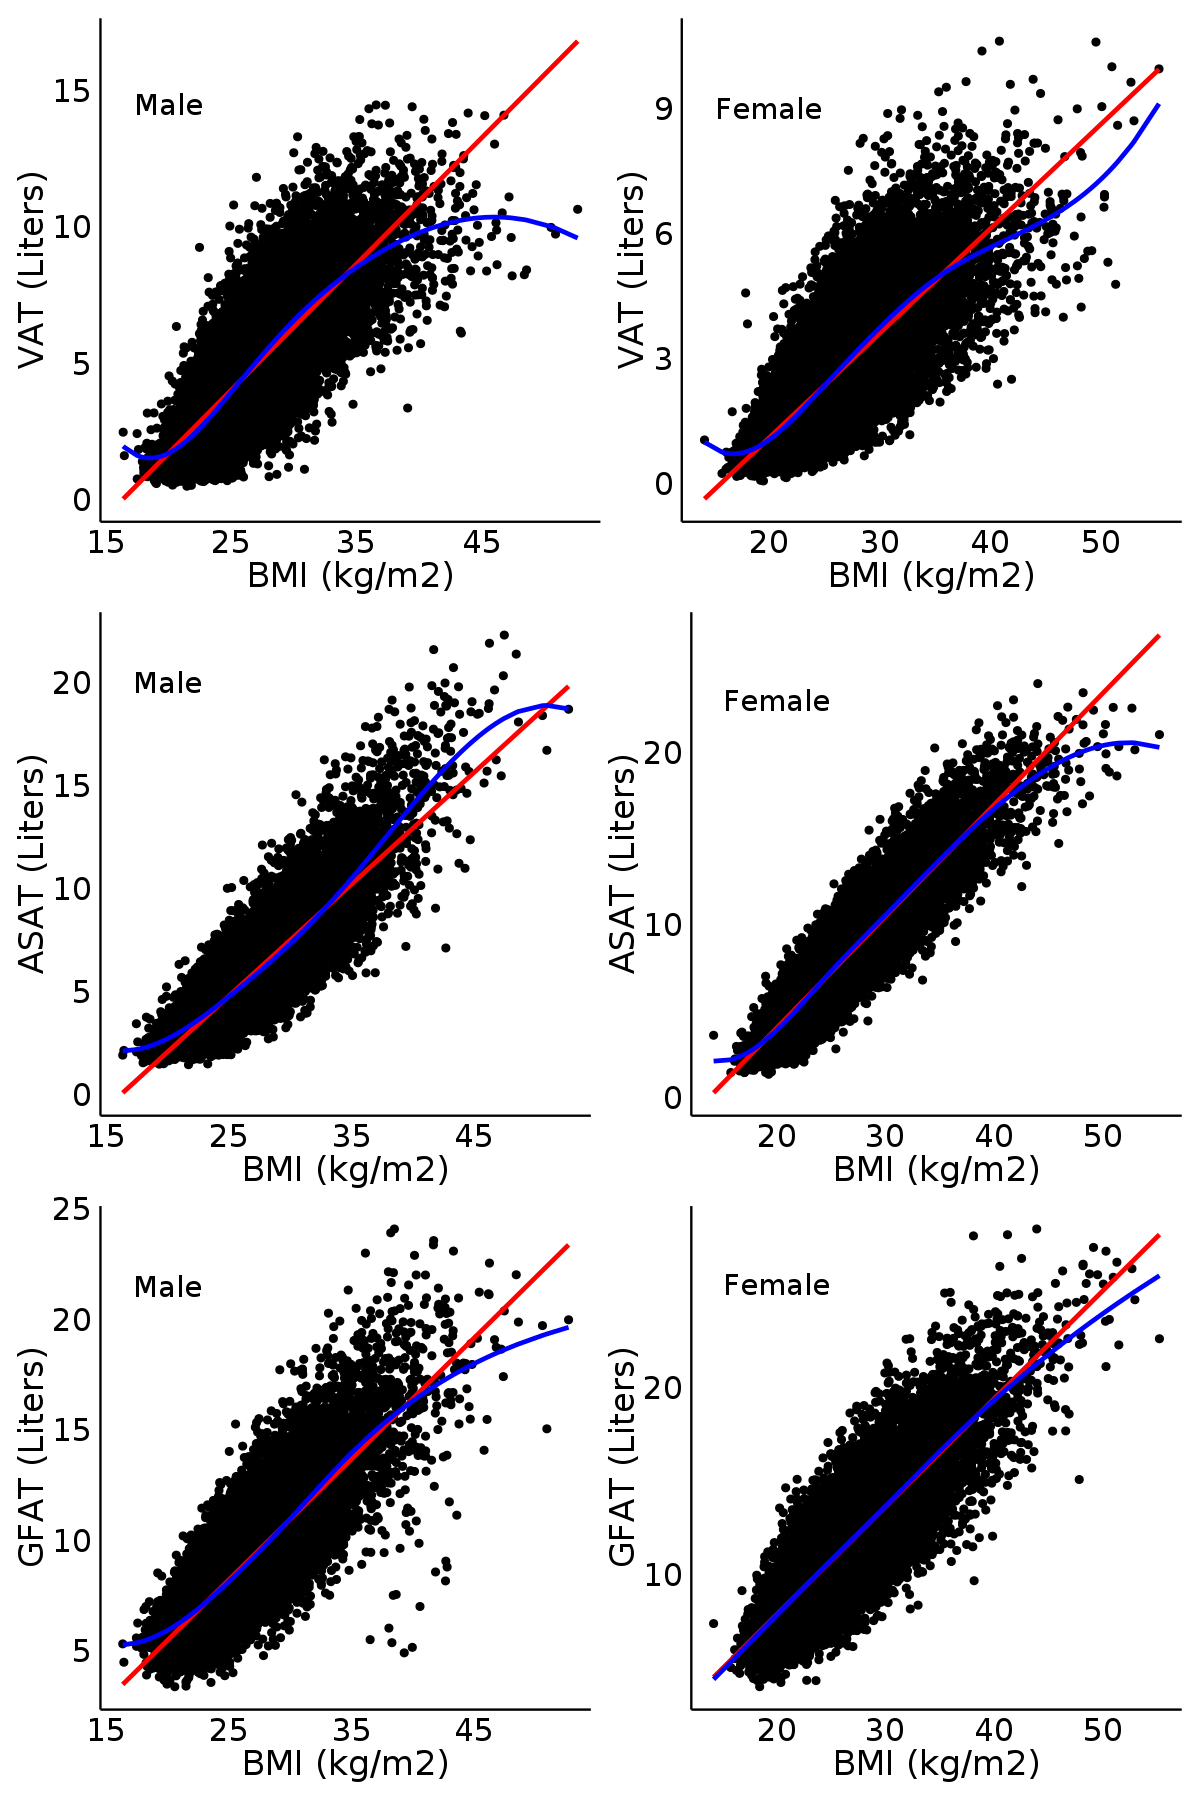

In [14]:
options(repr.plot.width=10,repr.plot.height=15)

g1 <- ggplot(fatPhenoCovarLifestyle2[sex=='Male'],aes(bmiCalc,vat))+
geom_point()+
geom_line(aes(y=vat_bmiPred),color='red',size=1)+
geom_line(aes(y=vat_bmiSplinePred),color='blue',size=1)+
    xlab('BMI (kg/m2)') +
    ylab('VAT (Liters)') +
    theme_classic() +
#     coord_flip() +
#     scale_x_discrete(limits=rev(levels(riskBarPlotDat$bmiGroup))) +
    theme(axis.title.y = element_text(size=20),
          axis.text.y = element_text(size=18,color='black'),
          axis.ticks.y = element_blank(),
          axis.title.x = element_text(size=20),
          axis.text.x = element_text(size=18,color='black'),
          axis.ticks.x = element_blank(),
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=16),
         legend.text = element_text(size=16),
         legend.position='none')+
annotate("text",x=20,y=14.5,label=paste0('Male'),size=6)

g2 <- ggplot(fatPhenoCovarLifestyle2[sex=='Female'],aes(bmiCalc,vat))+
geom_point()+
geom_line(aes(y=vat_bmiPred),color='red',size=1)+
geom_line(aes(y=vat_bmiSplinePred),color='blue',size=1)+
    xlab('BMI (kg/m2)') +
    ylab('VAT (Liters)') +
    theme_classic() +
#     coord_flip() +
#     scale_x_discrete(limits=rev(levels(riskBarPlotDat$bmiGroup))) +
    theme(axis.title.y = element_text(size=20),
          axis.text.y = element_text(size=18,color='black'),
          axis.ticks.y = element_blank(),
          axis.title.x = element_text(size=20),
          axis.text.x = element_text(size=18,color='black'),
          axis.ticks.x = element_blank(),
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=16),
         legend.text = element_text(size=16),
         legend.position='none')+
annotate("text",x=20,y=9,label=paste0('Female'),size=6)

g3 <- ggplot(fatPhenoCovarLifestyle2[sex=='Male'],aes(bmiCalc,asat))+
geom_point()+
geom_line(aes(y=asat_bmiPred),color='red',size=1)+
geom_line(aes(y=asat_bmiSplinePred),color='blue',size=1)+
    xlab('BMI (kg/m2)') +
    ylab('ASAT (Liters)') +
    theme_classic() +
#     coord_flip() +
#     scale_x_discrete(limits=rev(levels(riskBarPlotDat$bmiGroup))) +
    theme(axis.title.y = element_text(size=20),
          axis.text.y = element_text(size=18,color='black'),
          axis.ticks.y = element_blank(),
          axis.title.x = element_text(size=20),
          axis.text.x = element_text(size=18,color='black'),
          axis.ticks.x = element_blank(),
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=16),
         legend.text = element_text(size=16),
         legend.position='none')+
annotate("text",x=20,y=20,label=paste0('Male'),size=6)

g4 <- ggplot(fatPhenoCovarLifestyle2[sex=='Female'],aes(bmiCalc,asat))+
geom_point()+
geom_line(aes(y=asat_bmiPred),color='red',size=1)+
geom_line(aes(y=asat_bmiSplinePred),color='blue',size=1)+
    xlab('BMI (kg/m2)') +
    ylab('ASAT (Liters)') +
    theme_classic() +
#     coord_flip() +
#     scale_x_discrete(limits=rev(levels(riskBarPlotDat$bmiGroup))) +
    theme(axis.title.y = element_text(size=20),
          axis.text.y = element_text(size=18,color='black'),
          axis.ticks.y = element_blank(),
          axis.title.x = element_text(size=20),
          axis.text.x = element_text(size=18,color='black'),
          axis.ticks.x = element_blank(),
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=16),
         legend.text = element_text(size=16),
         legend.position='none')+
annotate("text",x=20,y=23,label=paste0('Female'),size=6)

g5 <- ggplot(fatPhenoCovarLifestyle2[sex=='Male'],aes(bmiCalc,gfat))+
geom_point()+
geom_line(aes(y=gfat_bmiPred),color='red',size=1)+
geom_line(aes(y=gfat_bmiSplinePred),color='blue',size=1)+
    xlab('BMI (kg/m2)') +
    ylab('GFAT (Liters)') +
    theme_classic() +
#     coord_flip() +
#     scale_x_discrete(limits=rev(levels(riskBarPlotDat$bmiGroup))) +
    theme(axis.title.y = element_text(size=20),
          axis.text.y = element_text(size=18,color='black'),
          axis.ticks.y = element_blank(),
          axis.title.x = element_text(size=20),
          axis.text.x = element_text(size=18,color='black'),
          axis.ticks.x = element_blank(),
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=16),
         legend.text = element_text(size=16),
         legend.position='none')+
annotate("text",x=20,y=21.5,label=paste0('Male'),size=6)

g6 <- ggplot(fatPhenoCovarLifestyle2[sex=='Female'],aes(bmiCalc,gfat))+
geom_point()+
geom_line(aes(y=gfat_bmiPred),color='red',size=1)+
geom_line(aes(y=gfat_bmiSplinePred),color='blue',size=1)+
    xlab('BMI (kg/m2)') +
    ylab('GFAT (Liters)') +
    theme_classic() +
#     coord_flip() +
#     scale_x_discrete(limits=rev(levels(riskBarPlotDat$bmiGroup))) +
    theme(axis.title.y = element_text(size=20),
          axis.text.y = element_text(size=18,color='black'),
          axis.ticks.y = element_blank(),
          axis.title.x = element_text(size=20),
          axis.text.x = element_text(size=18,color='black'),
          axis.ticks.x = element_blank(),
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=16),
         legend.text = element_text(size=16),
         legend.position='none')+
annotate("text",x=20,y=25.5,label=paste0('Female'),size=6)

g7 <- (g1|g2)/(g3|g4)/(g5|g6)
g7

# ggsave('./2021.03.11_paperFigs/paper1_MLandEpi/revisions/linear_vs_flexible_bmi_adjustment.pdf',
#        g7,height=15,width=10)

# options(bitmapType='cairo')
# ggsave('./2021.03.11_paperFigs/paper1_MLandEpi/revisions/linear_vs_flexible_bmi_adjustment.png',
#        g7,height=15,width=10)

## Build correlation plots between VAT, ASAT, GFAT and anthropometric variables (1) stratified by sex and (2) stratified by sex and self-reported ethnicity subgroup

In [15]:
dtforcorrMale <- fatPhenoCovarLifestyle2[sex=='Male',c('vat','asat','gfat',
                                           'bmiCalc','waistcmInstance2',
                                           'hipcmInstance2')]

names(dtforcorrMale) <- c('VAT','ASAT','GFAT',
                          'BMI','Waist','Hip')

M2 <- cor(dtforcorrMale,use = 'complete.obs')

dtforcorrFemale <- fatPhenoCovarLifestyle2[sex=='Female',c('vat','asat','gfat',
                                           'bmiCalc','waistcmInstance2',
                                           'hipcmInstance2')]

names(dtforcorrFemale) <- c('VAT','ASAT','GFAT',
                          'BMI','Waist','Hip')

M3 <- cor(dtforcorrFemale,use = 'complete.obs')

M4 <- copy(M3)
for(i in 1:6){
    for(j in 1:6){
        if(j < i){
            M4[i,j] <- M2[i,j]
        }
    }
}

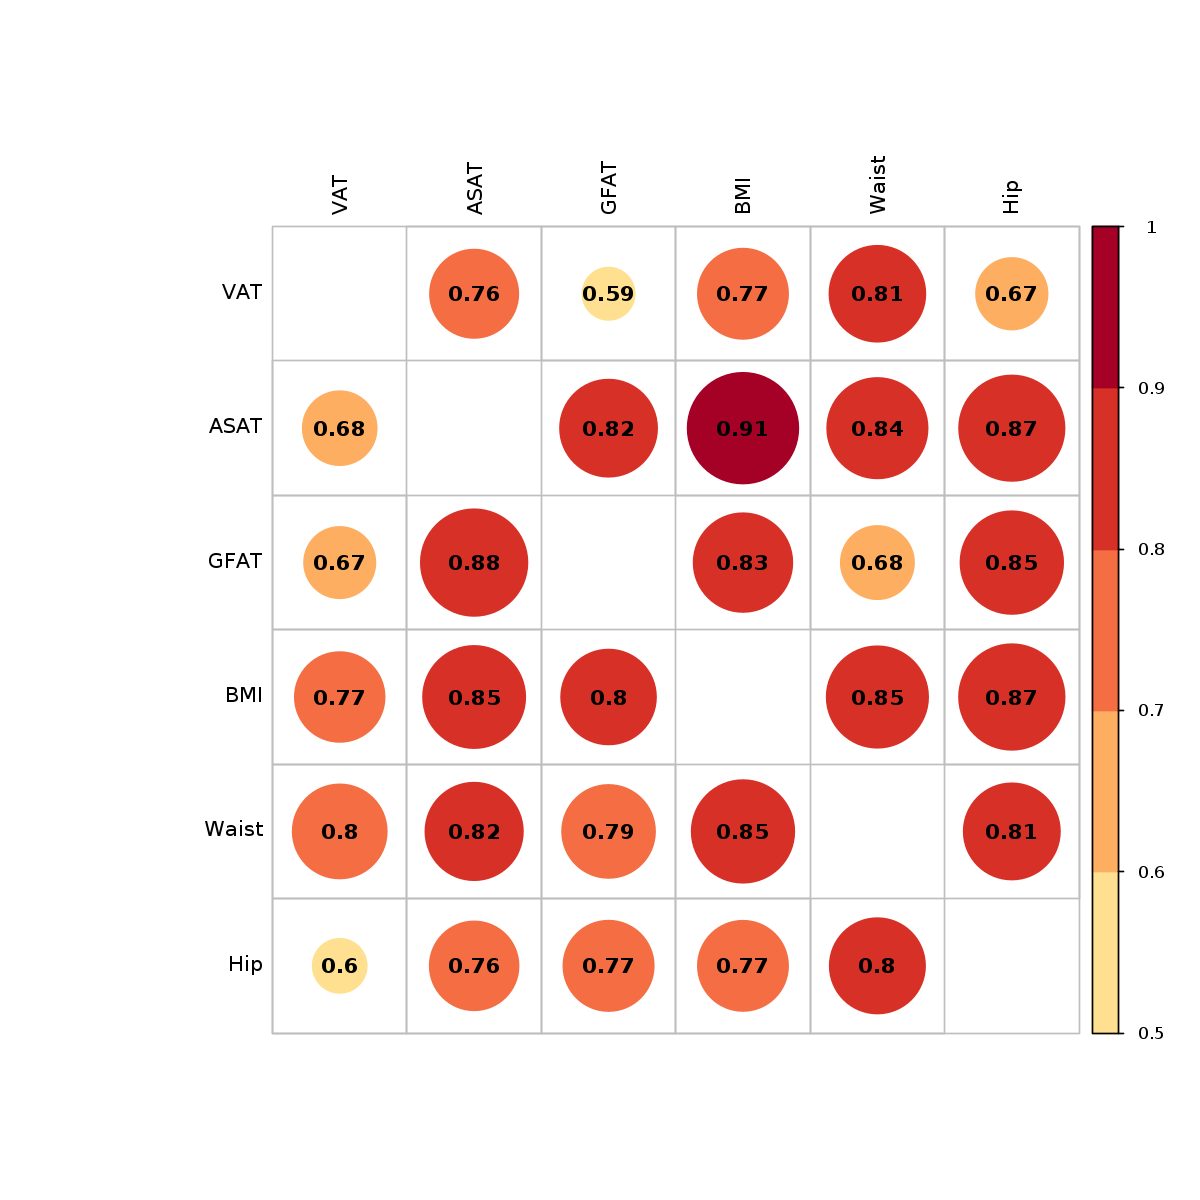

In [16]:
# pdf(height=10,width=10,file='/medpop/esp2/sagrawal/fat_distribution/2021.03.11_paperFigs/paper1_MLandEpi/corrPlots/phenoCorr_AIcombined_gfatupdate.pdf')

options(repr.plot.width=10,repr.plot.height=10)
# corrplot(M3,type='upper',order='original',method='color',
#          addCoef.col='black',tl.col='black')

corrplot(M4,type='full',order='original',col=rev(brewer.pal(n=10,name='RdYlBu')),
         addCoef.col='black',tl.col='black',cl.lim=c(0.5,1),is.corr=FALSE,diag=FALSE)

# dev.off()

In [17]:
#Revision: Get correlation for self-reported ethnicity groups

for(eth in c('White','Black','South Asian','East Asian')){
    print(eth)
    
dtforcorrMale <- na.omit(fatPhenoCovarLifestyle2[ethnicity_group==eth&sex=='Male',c('vat','asat','gfat',
                                           'bmiCalc','waistcmInstance2',
                                           'hipcmInstance2')])
    
    print(paste0('Male: ',nrow(dtforcorrMale)))

names(dtforcorrMale) <- c('VAT','ASAT','GFAT',
                          'BMI','Waist','Hip')

M2 <- cor(dtforcorrMale,use = 'complete.obs')

dtforcorrFemale <- na.omit(fatPhenoCovarLifestyle2[ethnicity_group==eth&sex=='Female',c('vat','asat','gfat',
                                           'bmiCalc','waistcmInstance2',
                                           'hipcmInstance2')])
    
    print(paste0('Female: ',nrow(dtforcorrFemale)))

names(dtforcorrFemale) <- c('VAT','ASAT','GFAT',
                          'BMI','Waist','Hip')

M3 <- cor(dtforcorrFemale,use = 'complete.obs')

M4 <- copy(M3)
for(i in 1:6){
    for(j in 1:6){
        if(j < i){
            M4[i,j] <- M2[i,j]
        }
    }
}
    
M4 <- format(round(M4,2),nsmall=2)
    
assign(paste0('cormat','_',paste(eth,collapse='_')),M4)
    
    
}

cormat_White
cormat_Black
`cormat_East Asian`
`cormat_South Asian`


[1] "White"
[1] "Male: 18168"
[1] "Female: 19238"
[1] "Black"
[1] "Male: 131"
[1] "Female: 180"
[1] "South Asian"
[1] "Male: 230"
[1] "Female: 126"
[1] "East Asian"
[1] "Male: 108"
[1] "Female: 131"


,VAT,ASAT,GFAT,BMI,Waist,Hip
VAT,1.00,0.76,0.59,0.78,0.81,0.67
ASAT,0.69,1.00,0.82,0.91,0.84,0.87
GFAT,0.67,0.88,1.00,0.83,0.68,0.85
BMI,0.77,0.85,0.80,1.00,0.85,0.87
Waist,0.80,0.82,0.79,0.85,1.00,0.81
Hip,0.60,0.77,0.77,0.77,0.80,1.00


,VAT,ASAT,GFAT,BMI,Waist,Hip
VAT,1.00,0.77,0.55,0.73,0.79,0.67
ASAT,0.70,1.00,0.83,0.92,0.87,0.90
GFAT,0.68,0.89,1.00,0.83,0.68,0.87
BMI,0.58,0.82,0.73,1.00,0.86,0.91
Waist,0.70,0.85,0.82,0.81,1.00,0.83
Hip,0.46,0.76,0.75,0.80,0.77,1.00


,VAT,ASAT,GFAT,BMI,Waist,Hip
VAT,1.00,0.78,0.64,0.81,0.84,0.75
ASAT,0.78,1.00,0.83,0.92,0.85,0.89
GFAT,0.76,0.90,1.00,0.83,0.70,0.85
BMI,0.80,0.79,0.74,1.00,0.87,0.90
Waist,0.83,0.85,0.77,0.84,1.00,0.85
Hip,0.65,0.72,0.70,0.81,0.77,1.00


,VAT,ASAT,GFAT,BMI,Waist,Hip
VAT,1.00,0.67,0.62,0.71,0.70,0.62
ASAT,0.58,1.00,0.77,0.85,0.76,0.77
GFAT,0.55,0.88,1.00,0.74,0.59,0.81
BMI,0.70,0.82,0.79,1.00,0.81,0.76
Waist,0.73,0.77,0.74,0.82,1.00,0.73
Hip,0.47,0.75,0.81,0.79,0.79,1.00


## Build "Table 1s" in various subgroups including (1) entire studied cohort, (2) among participants who had previously quantified VAT, ASAT, GFAT and those who did not, and (3) among participants who were randomized into development and holdout sets for each of the VAT, ASAT, and GFAT models

In [18]:
# saaketSumm(fatPhenoCovarLifestyle2)

In [19]:
fatPhenoCovarLifestyle2[,weightInstance2:=2.2*weightInstance2]
fatPhenoCovarLifestyle2[,heightCombined:=0.394*heightCombined]
fatPhenoCovarLifestyle2$sex <- factor(fatPhenoCovarLifestyle2$sex,levels=c('Male','Female'))

Warning message:
"Removed 1352 rows containing non-finite values (stat_density)."
Warning message:
"Removed 1352 rows containing non-finite values (stat_density)."
Warning message:
"Removed 1281 rows containing non-finite values (stat_density)."
Warning message:
"Removed 1280 rows containing non-finite values (stat_density)."
Warning message:
"Removed 1282 rows containing non-finite values (stat_density)."
Warning message:
"Removed 4969 rows containing non-finite values (stat_density)."
Warning message:
"Removed 4969 rows containing non-finite values (stat_density)."


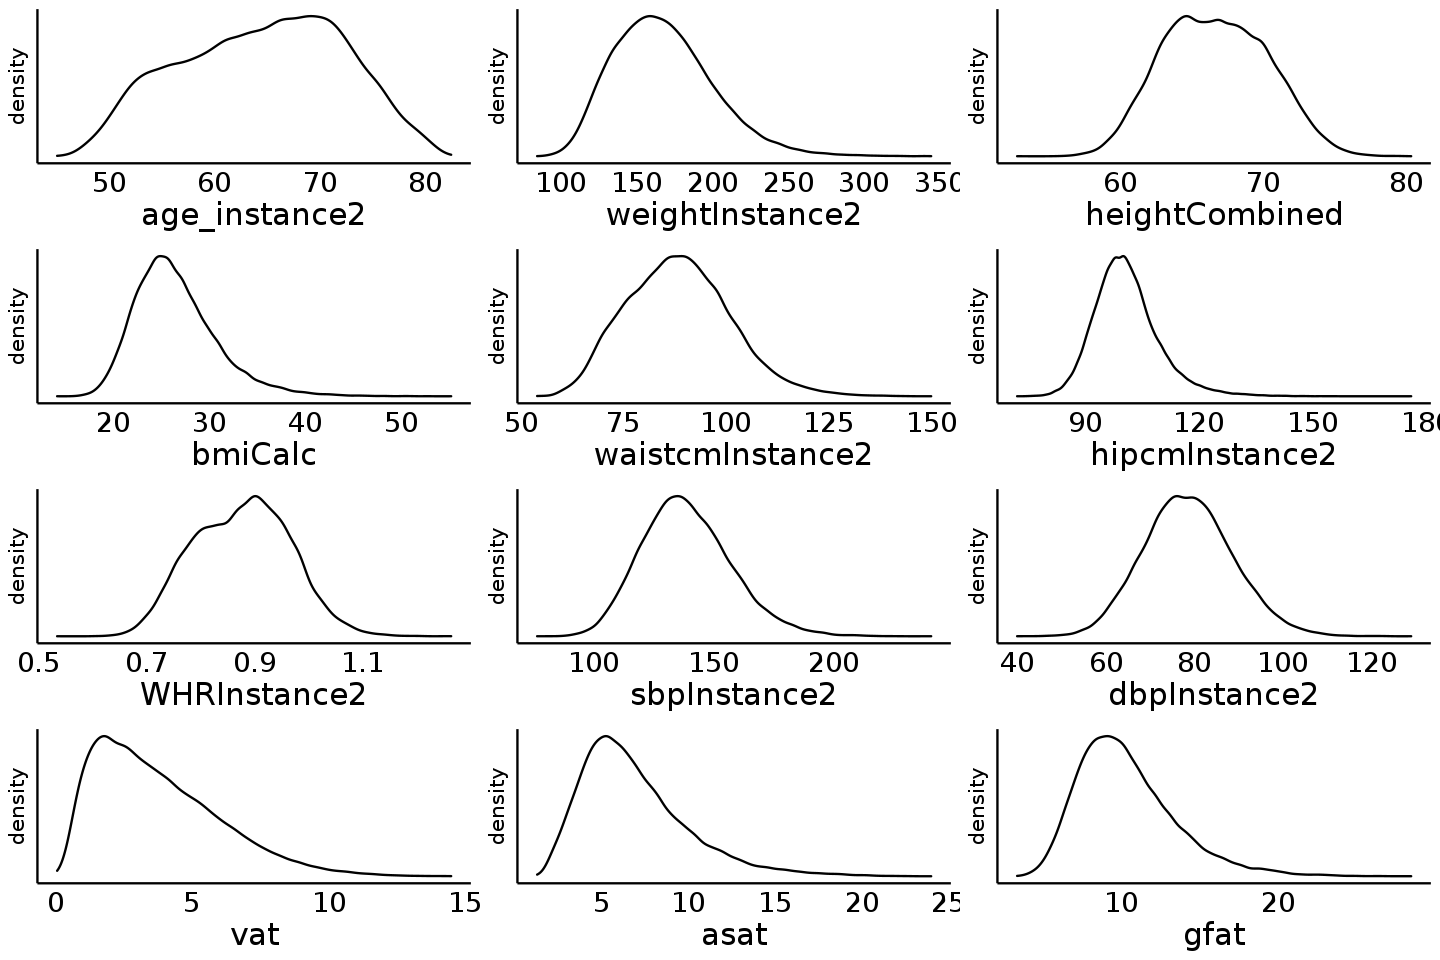

In [20]:
#Visually inspect normality of all continuous variables

options(repr.plot.width=12,repr.plot.height=8)

library(gridExtra)

continuous_vec <- c('age_instance2','weightInstance2','heightCombined','bmiCalc',
             'waistcmInstance2','hipcmInstance2','WHRInstance2','sbpInstance2','dbpInstance2',
             'vat','asat','gfat')

for(i in 1:length(continuous_vec)){
    
    tempg <- ggplot(data=fatPhenoCovarLifestyle2,aes_string(x=continuous_vec[i]))+
            geom_density()+
    theme_classic() +
    theme(axis.title.y = element_text(size=12),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          axis.title.x = element_text(size=18),
          axis.text.x = element_text(size=16,color='black'),
          axis.ticks.x = element_blank(),
          legend.position='none')
    assign(paste0('g',i),
          tempg)
}

grid.arrange(g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,nrow=4,ncol=3)

In [21]:
tab1vars <- c('age_instance2','ethnicity_group','sbpInstance2','dbpInstance2','smokingStrat',
              'weightInstance2','heightCombined','bmiCalc',
             'waistcmInstance2','hipcmInstance2','WHRInstance2',
             'vat','asat','gfat','prev_T2D','prev_CAD_int')

tab1contvars <- c('age_instance2','weightInstance2','heightCombined','bmiCalc',
             'waistcmInstance2','hipcmInstance2','WHRInstance2','sbpInstance2','dbpInstance2',
             'vat','asat','gfat')

tab1facvars <- c('ethnicity_group','smokingStrat','prev_T2D','prev_CAD_int')

tab1 <- CreateTableOne(vars=tab1vars,factorVars=tab1facvars,strata='sex',data=fatPhenoCovarLifestyle2)
tab1Mat <- print(tab1,nonnormal=tab1contvars,contDigits=1,quote=FALSE,printToggle=FALSE)
# tab1Mat

# write.csv(tab1Mat,
#          './2021.03.11_paperFigs/paper1_MLandEpi/revisions/table1_medians.csv',
#          row.names=TRUE)

In [22]:
## Read in participant ids for those randomized to development vs. holdout sets
## for VAT, ASAT, and GFAT CNNs.

makeDir <- '/medpop/esp2/sagrawal/fat_distribution/2021.03.11_datafreeze/'

VAT_dev <- fread(paste0(makeDir,'VAT_dev_IDs.csv'))
VAT_ho <- fread(paste0(makeDir,'VAT_ho_IDs.csv'))
VAT_label_id <- unique(c(VAT_dev$x,VAT_ho$x))

ASAT_dev <- fread(paste0(makeDir,'ASAT_dev_IDs.csv'))
ASAT_ho <- fread(paste0(makeDir,'ASAT_ho_IDs.csv'))
ASAT_label_id <- unique(c(ASAT_dev$x,ASAT_ho$x))

GFAT_dev <- fread(paste0(makeDir,'GFAT_dev_IDs.csv'))
GFAT_ho <- fread(paste0(makeDir,'GFAT_ho_IDs.csv'))
GFAT_label_id <- unique(c(GFAT_dev$x,GFAT_ho$x))

In [23]:
fatPhenoCovarLifestyle2[,VAT_label:=ifelse(eid%in%VAT_label_id,1,0)]
fatPhenoCovarLifestyle2[VAT_label==1,VAT_label_ho:=ifelse(eid%in%VAT_ho$x,1,0)]

fatPhenoCovarLifestyle2[,ASAT_label:=ifelse(eid%in%ASAT_label_id,1,0)]
fatPhenoCovarLifestyle2[ASAT_label==1,ASAT_label_ho:=ifelse(eid%in%ASAT_ho$x,1,0)]

fatPhenoCovarLifestyle2[,GFAT_label:=ifelse(eid%in%GFAT_label_id,1,0)]
fatPhenoCovarLifestyle2[GFAT_label==1,GFAT_label_ho:=ifelse(eid%in%GFAT_ho$x,1,0)]

fatPhenoCovarLifestyle2[,label_strat:=0]
fatPhenoCovarLifestyle2[VAT_label==1&GFAT_label==1,label_strat:=1]
fatPhenoCovarLifestyle2[VAT_label==1&GFAT_label==0,label_strat:=2]
fatPhenoCovarLifestyle2$label_strat <- factor(fatPhenoCovarLifestyle2$label_strat)

In [24]:
tab1vars <- c('age_instance2','sex','ethnicity_group','sbpInstance2','dbpInstance2','smokingStrat',
              'weightInstance2','heightCombined','bmiCalc',
             'waistcmInstance2','hipcmInstance2','WHRInstance2',
             'vat','asat','gfat','prev_T2D','prev_CAD_int')

tab1contvars <- c('age_instance2','weightInstance2','heightCombined','bmiCalc',
             'waistcmInstance2','hipcmInstance2','WHRInstance2','sbpInstance2','dbpInstance2',
             'vat','asat','gfat')

tab1facvars <- c('ethnicity_group','sex','smokingStrat','prev_T2D','prev_CAD_int')

tab1 <- CreateTableOne(vars=tab1vars,factorVars=tab1facvars,strata='label_strat',data=fatPhenoCovarLifestyle2)
tab1Mat <- print(tab1,nonnormal=tab1contvars,contDigits=1,quote=FALSE,printToggle=FALSE)
# tab1Mat

# write.csv(tab1Mat,
#          './2021.03.11_paperFigs/paper1_MLandEpi/revisions/table1_vat_gfat_label_discrepancy.csv',
#          row.names=TRUE)

In [25]:
tab1vars <- c('age_instance2','sex','ethnicity_group','sbpInstance2','dbpInstance2','smokingStrat',
              'weightInstance2','heightCombined','bmiCalc',
             'waistcmInstance2','hipcmInstance2','WHRInstance2',
             'vat','asat','gfat','prev_T2D','prev_CAD_int')

tab1contvars <- c('age_instance2','weightInstance2','heightCombined','bmiCalc',
             'waistcmInstance2','hipcmInstance2','WHRInstance2','sbpInstance2','dbpInstance2',
             'vat','asat','gfat')

tab1facvars <- c('ethnicity_group','sex','smokingStrat','prev_T2D','prev_CAD_int')

tab1 <- CreateTableOne(vars=tab1vars,factorVars=tab1facvars,strata='VAT_label_ho',data=fatPhenoCovarLifestyle2)
tab1Mat <- print(tab1,nonnormal=tab1contvars,contDigits=1,quote=FALSE,printToggle=FALSE)
# tab1Mat

# write.csv(tab1Mat,
#          './2021.03.11_paperFigs/paper1_MLandEpi/revisions/table1_vat_dev_ho.csv',
#          row.names=TRUE)

In [26]:
tab1vars <- c('age_instance2','sex','ethnicity_group','sbpInstance2','dbpInstance2','smokingStrat',
              'weightInstance2','heightCombined','bmiCalc',
             'waistcmInstance2','hipcmInstance2','WHRInstance2',
             'vat','asat','gfat','prev_T2D','prev_CAD_int')

tab1contvars <- c('age_instance2','weightInstance2','heightCombined','bmiCalc',
             'waistcmInstance2','hipcmInstance2','WHRInstance2','sbpInstance2','dbpInstance2',
             'vat','asat','gfat')

tab1facvars <- c('ethnicity_group','sex','smokingStrat','prev_T2D','prev_CAD_int')

tab1 <- CreateTableOne(vars=tab1vars,factorVars=tab1facvars,strata='ASAT_label_ho',data=fatPhenoCovarLifestyle2)
tab1Mat <- print(tab1,nonnormal=tab1contvars,contDigits=1,quote=FALSE,printToggle=FALSE)
# tab1Mat

# write.csv(tab1Mat,
#          './2021.03.11_paperFigs/paper1_MLandEpi/revisions/table1_asat_dev_ho.csv',
#          row.names=TRUE)

In [27]:
tab1vars <- c('age_instance2','sex','ethnicity_group','sbpInstance2','dbpInstance2','smokingStrat',
              'weightInstance2','heightCombined','bmiCalc',
             'waistcmInstance2','hipcmInstance2','WHRInstance2',
             'vat','asat','gfat','prev_T2D','prev_CAD_int')

tab1contvars <- c('age_instance2','weightInstance2','heightCombined','bmiCalc',
             'waistcmInstance2','hipcmInstance2','WHRInstance2','sbpInstance2','dbpInstance2',
             'vat','asat','gfat')

tab1facvars <- c('ethnicity_group','sex','smokingStrat','prev_T2D','prev_CAD_int')

tab1 <- CreateTableOne(vars=tab1vars,factorVars=tab1facvars,strata='GFAT_label_ho',data=fatPhenoCovarLifestyle2)
tab1Mat <- print(tab1,nonnormal=tab1contvars,contDigits=2,quote=FALSE,printToggle=FALSE)
# tab1Mat

# write.csv(tab1Mat,
#          './2021.03.11_paperFigs/paper1_MLandEpi/revisions/table1_gfat_dev_ho.csv',
#          row.names=TRUE)

## Build VAT, ASAT, and GFAT density plots across (1) sex and BMI subgroups and (2) sex, BMI, and self-reported ethnicity subgroups

In [28]:
densityPlotDat <- fatPhenoCovarLifestyle2[,c('bmiGroup','sex','vat','asat','gfat')]
densityPlotDat.m1 <- melt(densityPlotDat,id.vars=c('bmiGroup','sex'),
                         measure.vars=c('vat','asat','gfat'))

densityPlotDat.m1[,valMeans:=lapply(.SD,mean),.SDcols=c('value'),by=c('bmiGroup','sex','variable')]
densityPlotDat.m1[,valMedians:=lapply(.SD,median),.SDcols=c('value'),by=c('bmiGroup','sex','variable')]

In [29]:
densityPlotDat2 <- fatPhenoCovarLifestyle2[,c('bmiGroup','sex','vatadjbmi','asatadjbmi','gfatadjbmi')]
densityPlotDat2.m1 <- melt(densityPlotDat2,id.vars=c('bmiGroup','sex'),
                         measure.vars=c('vatadjbmi','asatadjbmi','gfatadjbmi'))

densityPlotDat2.m1[,valMeans:=lapply(.SD,mean),.SDcols=c('value'),by=c('bmiGroup','sex','variable')]
densityPlotDat2.m1[,valMedians:=lapply(.SD,median),.SDcols=c('value'),by=c('bmiGroup','sex','variable')]

In [30]:
# options(repr.plot.width=6,repr.plot.height=3)
fatDensityByBmi <- function(bmiGroupChar,sexChar){
    g1 <- ggplot(densityPlotDat.m1[bmiGroup==bmiGroupChar&sex==sexChar],aes(x=value,fill=variable))+
#     geom_histogram(alpha=0.4,position='identity')+
    geom_density(alpha=0.4)+
    geom_vline(aes(xintercept=valMedians,color=variable),linetype='dashed')+
    scale_x_continuous(limits=c(0,25),breaks=seq(0,25,5))+
#     scale_y_continuous(expand=expansion(c(0,0))) +
    xlab('Volume (Liters)') +
    ylab('density') +
    scale_fill_manual(values=c('#e53377','#ecb31f','#27b2af')) +
    scale_color_manual(values=c('#e53377','#ecb31f','#27b2af'))+
    theme_classic() +
    theme(axis.title.y = element_text(size=18),
          axis.text.y = element_text(size=16,color='black'),
          axis.ticks.y = element_blank(),
          axis.title.x = element_text(size=18),
          axis.text.x = element_text(size=16,color='black'),
          axis.ticks.x = element_blank(),
          legend.position='none',
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=16),
         legend.text = element_text(size=16))
    
    return(g1)
}



In [31]:
# options(repr.plot.width=6,repr.plot.height=3)
AdjfatDensityByBmi <- function(bmiGroupChar,sexChar){
    g1 <- ggplot(densityPlotDat2.m1[bmiGroup==bmiGroupChar&sex==sexChar],aes(x=value,fill=variable))+
    geom_density(alpha=0.4)+
    geom_vline(aes(xintercept=valMedians,color=variable),linetype='dashed')+
    scale_x_continuous(limits=c(-10,10),breaks=seq(-10,10,4))+
    xlab('Residuals (Liters)') +
    ylab('density') +
    scale_fill_manual(values=c('#e53377','#ecb31f','#27b2af')) +
    scale_color_manual(values=c('#e53377','#ecb31f','#27b2af'))+
    theme_classic() +
    theme(axis.title.y = element_text(size=18),
          axis.text.y = element_text(size=16,color='black'),
          axis.ticks.y = element_blank(),
          axis.title.x = element_text(size=18),
          axis.text.x = element_text(size=16,color='black'),
          axis.ticks.x = element_blank(),
          legend.position='none',
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=16),
         legend.text = element_text(size=16))
    
    return(g1)
}



In [32]:
for(char in c('Normal','Overweight','Obese')){
    assign(paste0(char,'_Male'),fatDensityByBmi(char,'Male'))
}

Normal_Male <- Normal_Male +
scale_y_continuous(limits=c(0,0.62),breaks=seq(0,0.6,0.3),expand=expansion(c(0,0))) +
xlab('')

Overweight_Male <- Overweight_Male +
scale_y_continuous(limits=c(0,0.62),breaks=seq(0,0.6,0.3),expand=expansion(c(0,0))) +
xlab('')

Obese_Male <- Obese_Male +
scale_y_continuous(limits=c(0,0.62),breaks=seq(0,0.6,0.3),expand=expansion(c(0,0)))

MalePlotsRaw <- Normal_Male/Overweight_Male/Obese_Male


In [33]:
for(char in c('Normal','Overweight','Obese')){
    assign(paste0(char,'_Female'),fatDensityByBmi(char,'Female'))
}

Normal_Female <- Normal_Female +
scale_y_continuous(limits=c(0,0.62),breaks=seq(0,0.6,0.3),expand=expansion(c(0,0))) +
xlab('') +
ylab('')

Overweight_Female <- Overweight_Female +
scale_y_continuous(limits=c(0,0.62),breaks=seq(0,0.6,0.3),expand=expansion(c(0,0))) +
xlab('') +
ylab('')

Obese_Female <- Obese_Female +
scale_y_continuous(limits=c(0,0.62),breaks=seq(0,0.6,0.3),expand=expansion(c(0,0))) +
# xlab('') +
ylab('')

FemalePlotsRaw <- Normal_Female/Overweight_Female/Obese_Female


Warning message:
"Removed 22 rows containing non-finite values (stat_density)."


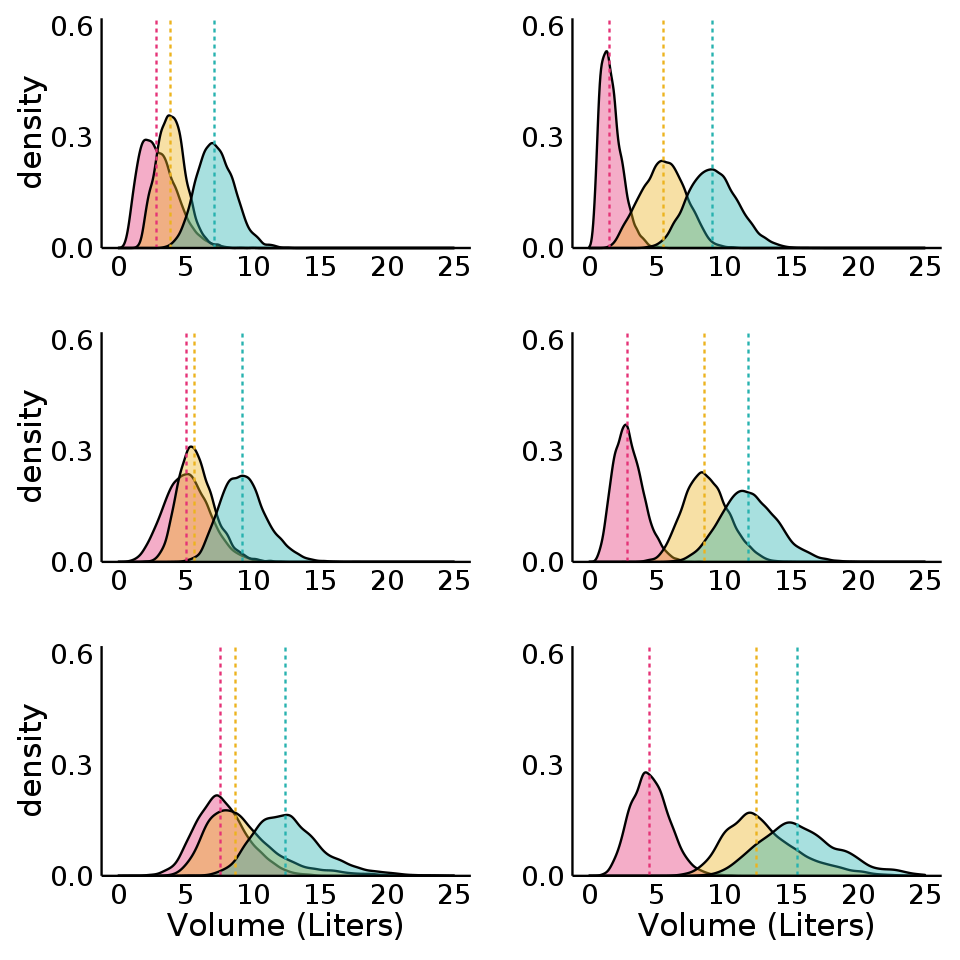

In [34]:
options(repr.plot.width=8,repr.plot.height=8)
allRaw <- MalePlotsRaw|FemalePlotsRaw
allRaw

# ggsave('/medpop/esp2/sagrawal/fat_distribution/2021.03.11_paperFigs/paper1_MLandEpi/vatAsatGfatAllDensity_gfatupdate.pdf',
#       allRaw,height=8,width=8)

In [35]:
for(char in c('Normal','Overweight','Obese')){
    assign(paste0(char,'_Male'),AdjfatDensityByBmi(char,'Male'))
}

Normal_Male <- Normal_Male +
scale_y_continuous(limits=c(0,0.65),breaks=seq(0,0.6,0.3),expand=expansion(c(0,0))) +
xlab('')

Overweight_Male <- Overweight_Male +
scale_y_continuous(limits=c(0,0.65),breaks=seq(0,0.6,0.3),expand=expansion(c(0,0))) +
xlab('')

Obese_Male <- Obese_Male +
scale_y_continuous(limits=c(0,0.65),breaks=seq(0,0.6,0.3),expand=expansion(c(0,0)))

MalePlotsAdj <- Normal_Male/Overweight_Male/Obese_Male


In [36]:
for(char in c('Normal','Overweight','Obese')){
    assign(paste0(char,'_Female'),AdjfatDensityByBmi(char,'Female'))
}

Normal_Female <- Normal_Female +
scale_y_continuous(limits=c(0,0.65),breaks=seq(0,0.6,0.3),expand=expansion(c(0,0))) +
xlab('')+
ylab('')

Overweight_Female <- Overweight_Female +
scale_y_continuous(limits=c(0,0.65),breaks=seq(0,0.6,0.3),expand=expansion(c(0,0))) +
xlab('')+
ylab('')

Obese_Female <- Obese_Female +
scale_y_continuous(limits=c(0,0.65),breaks=seq(0,0.6,0.3),expand=expansion(c(0,0))) +
# xlab('')+
ylab('')

FemalePlotsAdj <- Normal_Female/Overweight_Female/Obese_Female


Warning message:
"Removed 3 rows containing non-finite values (stat_density)."


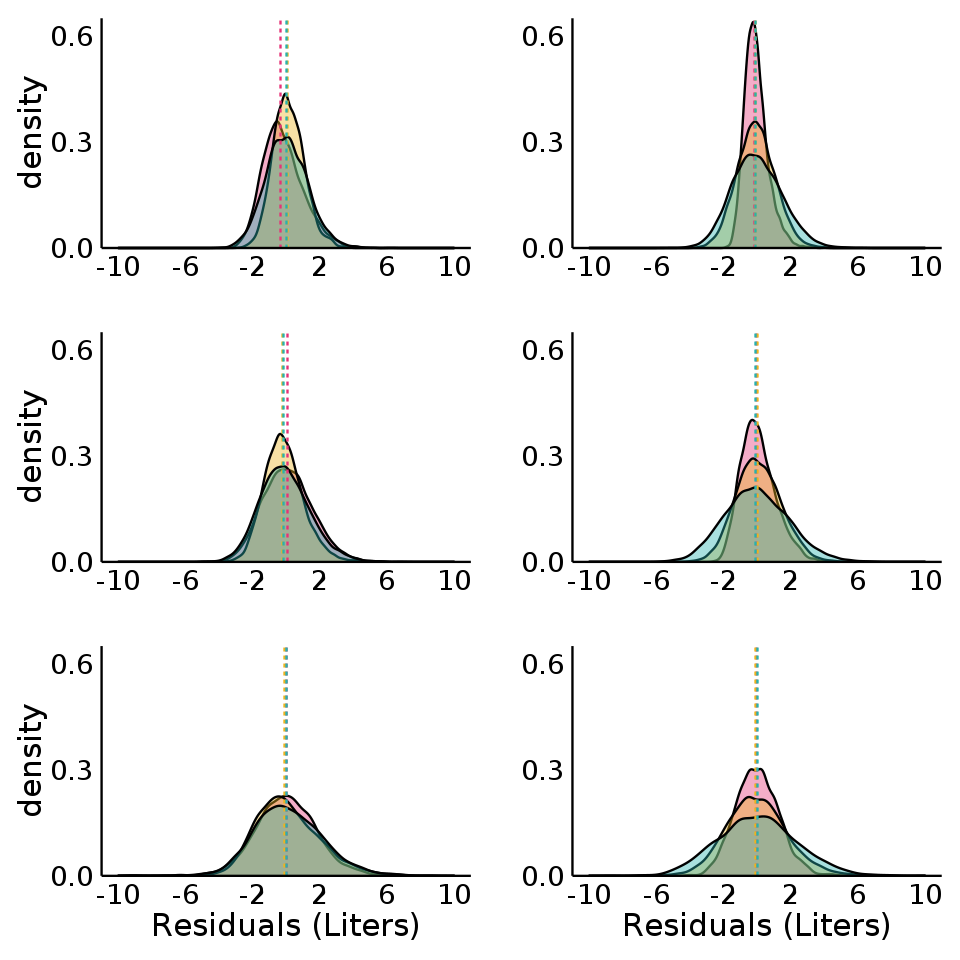

In [37]:
options(repr.plot.width=8,repr.plot.height=8)
allAdj <- MalePlotsAdj|FemalePlotsAdj
allAdj

# ggsave('/medpop/esp2/sagrawal/fat_distribution/2021.03.11_paperFigs/paper1_MLandEpi/vatAsatGfatAdjDensity_gfatupdate.pdf',
#       allAdj,height=8,width=8)

### Revision sensitivty analysis: show VAT, ASAT, GFAT distributions by self-reported ethnicity group using alternate BMI cutoffs for obesity reported here: https://pubmed.ncbi.nlm.nih.gov/24974975/

In [38]:
# options(repr.plot.width=6,repr.plot.height=3)
fatDensityByBmi_joint <- function(dat,bmiGroupChar,sexChar,ethnicityChar){
    g1 <- ggplot(dat[bmiDichotJoint==bmiGroupChar&sex==sexChar&ethnicity_group==ethnicityChar],aes(x=value,fill=variable))+
#     geom_histogram(alpha=0.4,position='identity')+
    geom_density(alpha=0.4)+
    geom_vline(aes(xintercept=valMedians,color=variable),linetype='dashed')+
    scale_x_continuous(limits=c(0,25),breaks=seq(0,20,10))+
#     scale_y_continuous(expand=expansion(c(0,0))) +
    xlab('Volume (Liters)') +
    ylab('density') +
    scale_fill_manual(values=c('#e53377','#ecb31f','#27b2af')) +
    scale_color_manual(values=c('#e53377','#ecb31f','#27b2af'))+
    theme_classic() +
    theme(axis.title.y = element_text(size=16),
          axis.text.y = element_text(size=14,color='black'),
          axis.ticks.y = element_blank(),
          axis.title.x = element_text(size=16),
          axis.text.x = element_text(size=14,color='black'),
          axis.ticks.x = element_blank(),
          legend.position='none',
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=14),
         legend.text = element_text(size=14))
    
    return(g1)
}

fatDensityByBmi_ethnicity <- function(dat,bmiGroupChar,sexChar,ethnicityChar){
    g1 <- ggplot(dat[bmiDichotEthnicity==bmiGroupChar&sex==sexChar&ethnicity_group==ethnicityChar],aes(x=value,fill=variable))+
#     geom_histogram(alpha=0.4,position='identity')+
    geom_density(alpha=0.4)+
    geom_vline(aes(xintercept=valMedians,color=variable),linetype='dashed')+
    scale_x_continuous(limits=c(0,25),breaks=seq(0,20,10))+
#     scale_y_continuous(expand=expansion(c(0,0))) +
    xlab('Volume (Liters)') +
    ylab('density') +
    scale_fill_manual(values=c('#e53377','#ecb31f','#27b2af')) +
    scale_color_manual(values=c('#e53377','#ecb31f','#27b2af'))+
    theme_classic() +
    theme(axis.title.y = element_text(size=16),
          axis.text.y = element_text(size=14,color='black'),
          axis.ticks.y = element_blank(),
          axis.title.x = element_text(size=16),
          axis.text.x = element_text(size=14,color='black'),
          axis.ticks.x = element_blank(),
          legend.position='none',
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=14),
         legend.text = element_text(size=14))
    
    return(g1)
}



In [39]:
densityPlotDat <- fatPhenoCovarLifestyle2[,c('bmiDichotJoint','bmiDichotEthnicity','ethnicity_group','sex','vat','asat','gfat')]

densityPlotDat.m1 <- melt(densityPlotDat,id.vars=c('bmiDichotJoint','ethnicity_group','sex'),
                         measure.vars=c('vat','asat','gfat'))
densityPlotDat.m1[,valMedians:=lapply(.SD,median),.SDcols=c('value'),by=c('bmiDichotJoint','ethnicity_group','sex','variable')]

densityPlotDat.m2 <- melt(densityPlotDat,id.vars=c('bmiDichotEthnicity','ethnicity_group','sex'),
                         measure.vars=c('vat','asat','gfat'))
densityPlotDat.m2[,valMedians:=lapply(.SD,median),.SDcols=c('value'),by=c('bmiDichotEthnicity','ethnicity_group','sex','variable')]


In [40]:
for(char1 in c('Low','High')){
    for(char2 in c('Black','East Asian','South Asian')){
        for(char3 in c('Male','Female')){
            assign(paste0(gsub(" ","",char2),'_',char1,'_',char3,'_jointplot'),
                  fatDensityByBmi_joint(densityPlotDat.m1,char1,char3,char2))
            
            assign(paste0(gsub(" ","",char2),'_',char1,'_',char3,'_ethnicityplot'),
                  fatDensityByBmi_ethnicity(densityPlotDat.m2,char1,char3,char2))
        }
    }
}

In [41]:
Black_plots <- (Black_Low_Male_jointplot | Black_Low_Female_jointplot)/
                (Black_High_Male_jointplot | Black_High_Female_jointplot)/
                (Black_Low_Male_ethnicityplot | Black_Low_Female_ethnicityplot)/
                (Black_High_Male_ethnicityplot | Black_High_Female_ethnicityplot)

EastAsian_plots <- (EastAsian_Low_Male_jointplot | EastAsian_Low_Female_jointplot)/
                (EastAsian_High_Male_jointplot | EastAsian_High_Female_jointplot)/
                (EastAsian_Low_Male_ethnicityplot | EastAsian_Low_Female_ethnicityplot)/
                (EastAsian_High_Male_ethnicityplot | EastAsian_High_Female_ethnicityplot)

SouthAsian_plots <- (SouthAsian_Low_Male_jointplot | SouthAsian_Low_Female_jointplot)/
                (SouthAsian_High_Male_jointplot | SouthAsian_High_Female_jointplot)/
                (SouthAsian_Low_Male_ethnicityplot | SouthAsian_Low_Female_ethnicityplot)/
                (SouthAsian_High_Male_ethnicityplot | SouthAsian_High_Female_ethnicityplot)

Warning message:
"Removed 1 rows containing non-finite values (stat_density)."
Warning message:
"Removed 1 rows containing non-finite values (stat_density)."
Warning message:
"Removed 1 rows containing non-finite values (stat_density)."
Warning message:
"Removed 1 rows containing non-finite values (stat_density)."


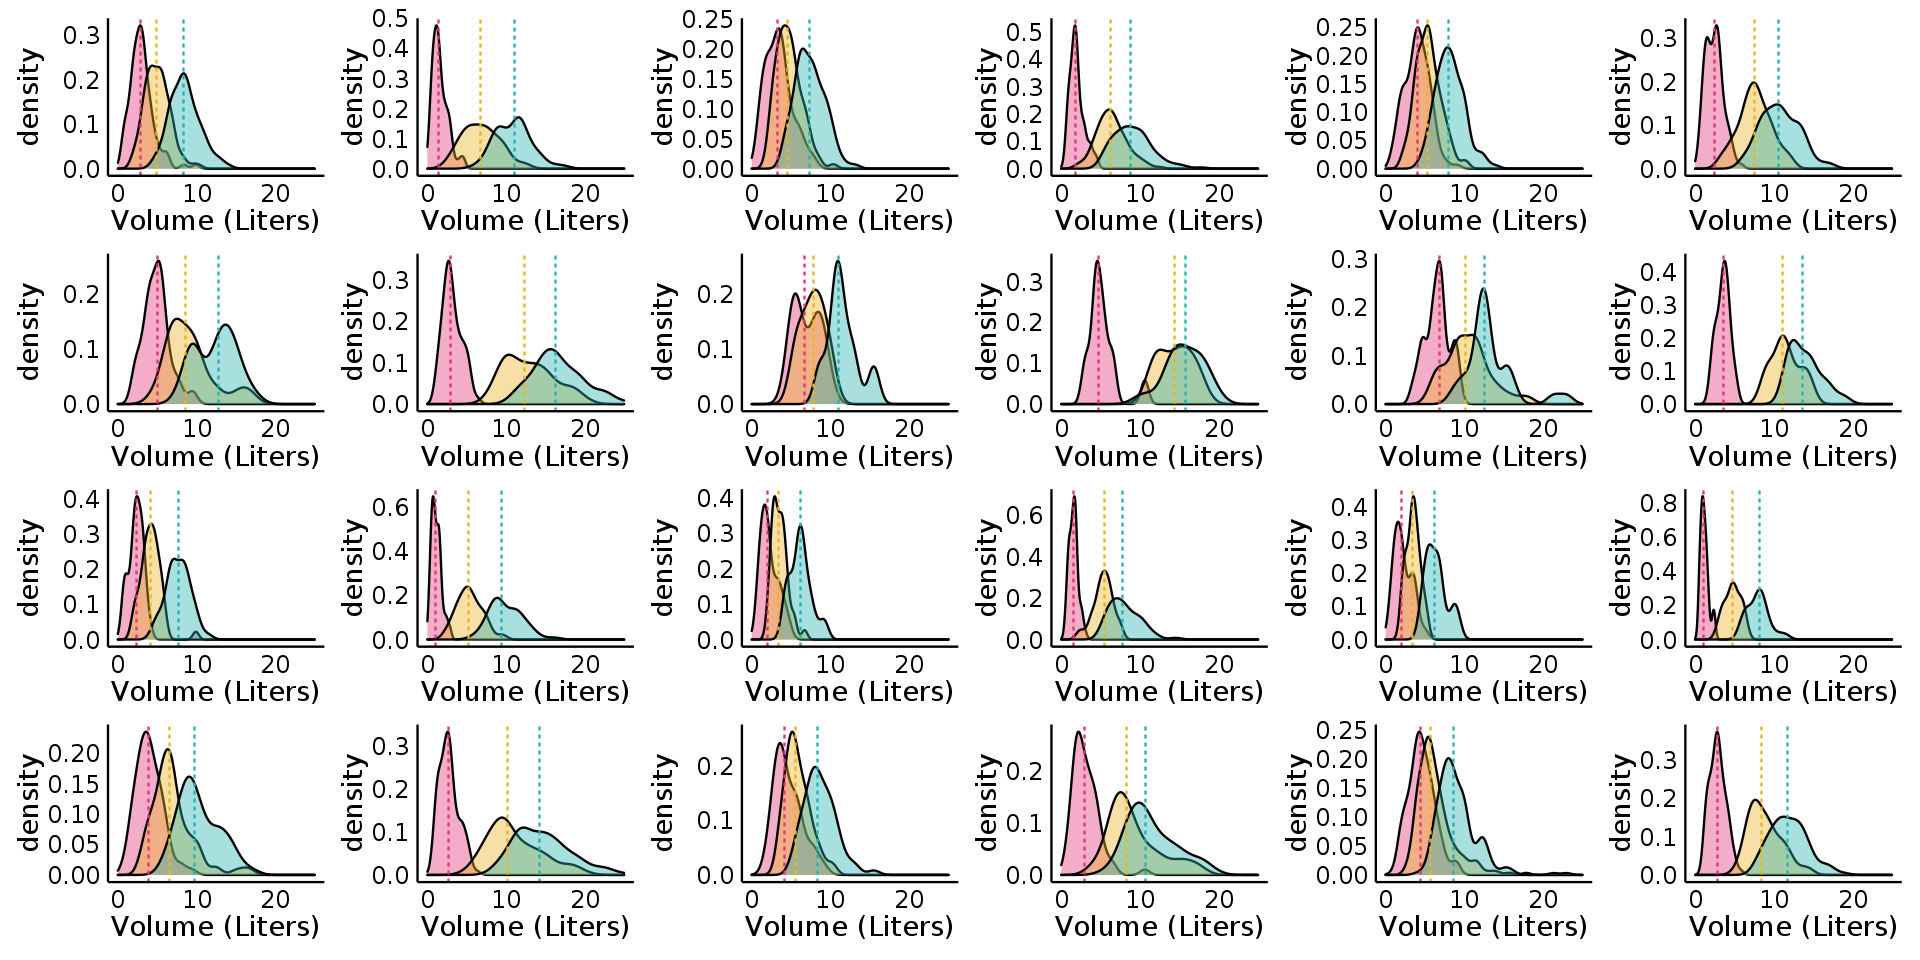

In [42]:
options(repr.plot.width=16,repr.plot.height=8)
outplots <- Black_plots | EastAsian_plots | SouthAsian_plots
outplots

# ggsave('/medpop/esp2/sagrawal/fat_distribution/2021.03.11_paperFigs/paper1_MLandEpi/revisions/densityplots_ethnicitybmi.pdf',
#       outplots,height=8,width=16)



# Logistic regression

In [43]:
#No significance to renaming here
trainDat <- copy(fatPhenoCovarLifestyle2)

In [44]:
table(trainDat$mriNum,useNA = 'always')


 41754 141243 141631   <NA> 
 23689  10466   5877      0 

In [45]:
trainDat[,mriNum_141243:=ifelse(mriNum==141243,1,0)]
trainDat[,mriNum_141631:=ifelse(mriNum==141631,1,0)]

In [46]:
returnORwrapper <- function(mod,subgroupName){
    sumtempMod <- summary(mod)
    tempCoef <- sumtempMod$coefficients
    
    temprowNames <- row.names(tempCoef)
    bmiCalcIndex <- which(temprowNames=='bmiCalcScaled')
    vatadjbmiIndex <- which(temprowNames=='vatadjbmiScaled')
    asatadjbmiIndex <- which(temprowNames=='asatadjbmiScaled')
    gfatadjbmiIndex <- which(temprowNames=='gfatadjbmiScaled')
    
    ORupperlower <- function(indexVal){
        tempOR <- exp(tempCoef[indexVal,1])
        tempUpper <- exp(tempCoef[indexVal,1]+(1.96*tempCoef[indexVal,2]))
        tempLower <- exp(tempCoef[indexVal,1]-(1.96*tempCoef[indexVal,2]))
        tempORwCI <- paste0(format(round(tempOR,2),nsmall=2),
                            ' ',
                            '(',
                            format(round(tempLower,2),nsmall=2),
                            '-',
                            format(round(tempUpper,2),nsmall=2),
                            ')')
        
        tempPval <- tempCoef[indexVal,4]
        if(tempPval < 0.001){
            tempPval <- formatC(tempPval,format='e',digits=1)
        } else {
            tempPval <- format(round(tempPval,3),nsmall=3)
        }
        
        return(c(tempOR,tempUpper,tempLower,tempORwCI,tempPval))
    }
    
    bmiCalcVec <- ORupperlower(bmiCalcIndex)
    vatadjbmiVec <- ORupperlower(vatadjbmiIndex)
    asatadjbmiVec <- ORupperlower(asatadjbmiIndex)
    gfatadjbmiVec <- ORupperlower(gfatadjbmiIndex)
    
    outDat <- data.table('subgroupName'=subgroupName,'bmiCalc_OR'=bmiCalcVec[1],
                        'bmiCalc_upper'=bmiCalcVec[2], 'bmiCalc_lower'=bmiCalcVec[3],
                         'bmiCalc_ORwCI'=bmiCalcVec[4],'bmiCalc_Pval'=bmiCalcVec[5],
                        'vatadjbmi_OR'=vatadjbmiVec[1], 'vatadjbmi_upper'=vatadjbmiVec[2],
                        'vatadjbmi_lower'=vatadjbmiVec[3], 'vatadjbmi_ORwCI'=vatadjbmiVec[4],
                         'vatadjbmi_Pval'=vatadjbmiVec[5], 'asatadjbmi_OR'=asatadjbmiVec[1],
                        'asatadjbmi_upper'=asatadjbmiVec[2], 'asatadjbmi_lower'=asatadjbmiVec[3],
                         'asatadjbmi_ORwCI'=asatadjbmiVec[4],'asatadjbmi_Pval'=asatadjbmiVec[5],
                        'gfatadjbmi_OR'=gfatadjbmiVec[1], 'gfatadjbmi_upper'=gfatadjbmiVec[2],
                        'gfatadjbmi_lower'=gfatadjbmiVec[3],'gfatadjbmi_ORwCI'=gfatadjbmiVec[4],
                        'gfatadjbmi_Pval'=gfatadjbmiVec[5])
    
    return(outDat)
}

In [47]:
giveORwCI <- function(mod,var){
    tempCoef <- summary(mod)$coefficients
    temprowNames <- row.names(tempCoef)
    indexVal <- which(temprowNames==var)

    tempOR <- exp(tempCoef[indexVal,1])
    tempUpper <- exp(tempCoef[indexVal,1]+(1.96*tempCoef[indexVal,2]))
    tempLower <- exp(tempCoef[indexVal,1]-(1.96*tempCoef[indexVal,2]))
    tempORwCI <- paste0(format(round(tempOR,2),nsmall=2),
                            ' ',
                            '(',
                            format(round(tempLower,2),nsmall=2),
                            '-',
                            format(round(tempUpper,2),nsmall=2),
                            ')')
    return(tempORwCI)
}


In [48]:
prev_T2D_all <- glm(prev_T2D~age_instance2+
                      sex+bmiCalcScaled+mriNum_141243+mriNum_141631,
                      data=trainDat,family='binomial')

summary(prev_T2D_all)$coefficients
giveORwCI(prev_T2D_all,'bmiCalcScaled')

prev_T2D_all <- glm(prev_T2D~age_instance2+
                      sex+vatScaled+mriNum_141243+mriNum_141631,
                      data=trainDat,family='binomial')

summary(prev_T2D_all)$coefficients
giveORwCI(prev_T2D_all,'vatScaled')

prev_T2D_all <- glm(prev_T2D~age_instance2+
                      sex+asatScaled+mriNum_141243+mriNum_141631,
                      data=trainDat,family='binomial')

summary(prev_T2D_all)$coefficients
giveORwCI(prev_T2D_all,'asatScaled')

prev_T2D_all <- glm(prev_T2D~age_instance2+
                      sex+gfatScaled+mriNum_141243+mriNum_141631,
                      data=trainDat,family='binomial')

summary(prev_T2D_all)$coefficients
giveORwCI(prev_T2D_all,'gfatScaled')

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-6.17443250,0.232444772,-26.5630088,1.817113e-155
age_instance2,0.05072354,0.003424383,14.8124587,1.217057e-49
sexFemale,-0.75697452,0.051806986,-14.6114372,2.374553e-48
bmiCalcScaled,0.62821538,0.020189860,31.1153913,1.491420e-212
mriNum_141243,-0.08218798,0.058497542,-1.4049818,1.600267e-01
mriNum_141631,-0.04032440,0.074291339,-0.5427874,5.872762e-01


[1] "1.87 (1.80-1.95)"

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-5.39563366,0.227790861,-23.6867872,4.933871e-124
age_instance2,0.03775723,0.003379529,11.1723333,5.569822e-29
sexFemale,-0.78783012,0.051253244,-15.3713222,2.549133e-53
vatScaled,0.75956325,0.021408324,35.4798094,1.006938e-275
mriNum_141243,-0.12367654,0.057517389,-2.1502461,3.153576e-02
mriNum_141631,-0.04197342,0.071995755,-0.5829985,5.598943e-01


[1] "2.14 (2.05-2.23)"

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-6.12889156,0.227464599,-26.9443754,6.639205e-160
age_instance2,0.05073678,0.003348936,15.1501208,7.562752e-52
sexFemale,-0.71817104,0.050469084,-14.2299203,5.974987e-46
asatScaled,0.52405791,0.019506583,26.8656948,5.530228e-159
mriNum_141243,-0.06987345,0.056905972,-1.2278756,2.194937e-01
mriNum_141631,-0.07118231,0.071182856,-0.9999924,3.173142e-01


[1] "1.69 (1.63-1.75)"

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-5.50821931,0.221055058,-24.917861,4.764861e-137
age_instance2,0.04225426,0.003272204,12.913086,3.797709e-38
sexFemale,-0.71988886,0.050248524,-14.326567,1.493210e-46
gfatScaled,0.39255024,0.020672962,18.988583,2.119728e-80
mriNum_141243,-0.06619613,0.056563701,-1.170294,2.418829e-01
mriNum_141631,-0.11067924,0.070667086,-1.566206,1.173003e-01


[1] "1.48 (1.42-1.54)"

In [49]:
prev_CAD_int_all <- glm(prev_CAD_int~age_instance2+
                      sex+bmiCalcScaled+mriNum_141243+mriNum_141631,
                      data=trainDat,family='binomial')

summary(prev_CAD_int_all)$coefficients
giveORwCI(prev_CAD_int_all,'bmiCalcScaled')

prev_CAD_int_all <- glm(prev_CAD_int~age_instance2+
                      sex+vatScaled+mriNum_141243+mriNum_141631,
                      data=trainDat,family='binomial')

summary(prev_CAD_int_all)$coefficients
giveORwCI(prev_CAD_int_all,'vatScaled')

prev_CAD_int_all <- glm(prev_CAD_int~age_instance2+
                      sex+asatScaled+mriNum_141243+mriNum_141631,
                      data=trainDat,family='binomial')

summary(prev_CAD_int_all)$coefficients
giveORwCI(prev_CAD_int_all,'asatScaled')

prev_CAD_int_all <- glm(prev_CAD_int~age_instance2+
                      sex+gfatScaled+mriNum_141243+mriNum_141631,
                      data=trainDat,family='binomial')

summary(prev_CAD_int_all)$coefficients
giveORwCI(prev_CAD_int_all,'gfatScaled')

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-8.83476034,0.255212878,-34.6172200,1.391467e-262
age_instance2,0.09477702,0.003686846,25.7067992,9.812006e-146
sexFemale,-1.35182975,0.058272781,-23.1983048,4.736185e-119
bmiCalcScaled,0.27161495,0.022566506,12.0361988,2.292790e-33
mriNum_141243,0.05027581,0.055709478,0.9024642,3.668103e-01
mriNum_141631,-0.27514837,0.076455676,-3.5987958,3.196940e-04


[1] "1.31 (1.26-1.37)"

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-8.50656968,0.249213939,-34.1336030,2.341615e-255
age_instance2,0.08971203,0.003606957,24.8719465,1.497158e-136
sexFemale,-1.34499176,0.056955411,-23.6148199,2.714633e-123
vatScaled,0.29906391,0.022375616,13.3656167,9.603578e-41
mriNum_141243,0.03970328,0.054358078,0.7304025,4.651442e-01
mriNum_141631,-0.28754004,0.073912830,-3.8902588,1.001374e-04


[1] "1.35 (1.29-1.41)"

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-8.74735121,0.249631765,-35.041018,5.343024e-269
age_instance2,0.09367675,0.003606327,25.975670,9.328056e-149
sexFemale,-1.33000854,0.056856426,-23.392405,5.106263e-121
asatScaled,0.20558757,0.022552493,9.115958,7.797870e-20
mriNum_141243,0.05799873,0.054271893,1.068670,2.852185e-01
mriNum_141631,-0.30265180,0.073783723,-4.101878,4.098112e-05


[1] "1.23 (1.18-1.28)"

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-8.54967728,0.247380723,-34.560806,9.808765e-262
age_instance2,0.09077924,0.003578293,25.369425,5.486788e-142
sexFemale,-1.32540231,0.056843466,-23.316705,3.001350e-120
gfatScaled,0.15514953,0.022833231,6.794901,1.083873e-11
mriNum_141243,0.06021403,0.054272927,1.109467,2.672287e-01
mriNum_141631,-0.31261047,0.073695266,-4.241934,2.216016e-05


[1] "1.17 (1.12-1.22)"

# Revision: Sensitivity analysis with adjustment for additional covariates

In [50]:
prev_T2D_all_original <- glm(prev_T2D~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat,family='binomial')

# summary(prev_T2D_all_original)

prev_T2D_all_Snadjust1 <- glm(prev_T2D~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631+weightInstance2+heightInstance2+smokingStrat+ethnicity_group,
                      data=trainDat,family='binomial')

# summary(prev_T2D_all_Snadjust1)

T2D_out <- data.table()
T2D_out <- rbind(T2D_out,returnORwrapper(prev_T2D_all_original,'Model1'))
T2D_out <- rbind(T2D_out,returnORwrapper(prev_T2D_all_Snadjust1,'Model2'))

T2D_out <- T2D_out[,c('subgroupName',
                      'vatadjbmi_ORwCI','vatadjbmi_Pval',
                      'asatadjbmi_ORwCI','asatadjbmi_Pval',
                      'gfatadjbmi_ORwCI','gfatadjbmi_Pval')]

T2D_out

# write.csv(T2D_out,
#          './2021.03.11_paperFigs/paper1_MLandEpi/revisions/prev_t2d_model_sn.csv',
#          row.names=FALSE)


subgroupName,vatadjbmi_ORwCI,vatadjbmi_Pval,asatadjbmi_ORwCI,asatadjbmi_Pval,gfatadjbmi_ORwCI,gfatadjbmi_Pval
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Model1,1.49 (1.43-1.55),9.9e-76,1.08 (1.03-1.14),0.002,0.75 (0.71-0.79),6.4e-28
Model2,1.53 (1.46-1.60),3.4e-74,1.07 (1.01-1.12),0.013,0.75 (0.71-0.80),1.1e-21


In [51]:
prev_CAD_int_all_original <- glm(prev_CAD_int~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat,family='binomial')

# summary(prev_CAD_int_all_original)



prev_CAD_int_all_Snadjust1 <- glm(prev_CAD_int~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631+weightInstance2+heightInstance2+smokingStrat+ethnicity_group,
                      data=trainDat,family='binomial')

# summary(prev_CAD_int_all_Snadjust1)


prev_CAD_int_all_Snadjust2 <- glm(prev_CAD_int~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631+prev_T2D,
                      data=trainDat,family='binomial')

# summary(prev_CAD_int_all_Snadjust2)

CAD_int_out <- data.table()
CAD_int_out <- rbind(CAD_int_out,returnORwrapper(prev_CAD_int_all_original,'Model1'))
CAD_int_out <- rbind(CAD_int_out,returnORwrapper(prev_CAD_int_all_Snadjust1,'Model2'))
CAD_int_out <- rbind(CAD_int_out,returnORwrapper(prev_CAD_int_all_Snadjust2,'Model3'))

CAD_int_out <- CAD_int_out[,c('subgroupName',
                      'vatadjbmi_ORwCI','vatadjbmi_Pval',
                      'asatadjbmi_ORwCI','asatadjbmi_Pval',
                      'gfatadjbmi_ORwCI','gfatadjbmi_Pval')]

CAD_int_out

# write.csv(CAD_int_out,
#          './2021.03.11_paperFigs/paper1_MLandEpi/revisions/prev_cad_model_sn.csv',
#          row.names=FALSE)



subgroupName,vatadjbmi_ORwCI,vatadjbmi_Pval,asatadjbmi_ORwCI,asatadjbmi_Pval,gfatadjbmi_ORwCI,gfatadjbmi_Pval
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Model1,1.17 (1.11-1.22),3.0e-11,1.00 (0.94-1.05),0.921,0.89 (0.84-0.94),3.5e-05
Model2,1.20 (1.14-1.26),1.4e-13,1.00 (0.94-1.06),0.956,0.94 (0.88-1.00),0.051
Model3,1.14 (1.09-1.19),3.2e-08,0.99 (0.94-1.05),0.773,0.91 (0.86-0.96),5.5e-04


## Revision: Explicitly modeling interaction term with BMI

In [52]:
prev_T2D_all_original <- glm(prev_T2D~age_instance2+
                      sex+bmiCalcScaled*(vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled)+mriNum_141243+mriNum_141631,
                      data=trainDat,family='binomial')

summary(prev_T2D_all_original)

prev_CAD_all_original <- glm(prev_CAD_int~age_instance2+
                      sex+bmiCalcScaled*(vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled)+mriNum_141243+mriNum_141631,
                      data=trainDat,family='binomial')

summary(prev_CAD_all_original)


Call:
glm(formula = prev_T2D ~ age_instance2 + sex + bmiCalcScaled * 
    (vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled) + 
    mriNum_141243 + mriNum_141631, family = "binomial", data = trainDat)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1087  -0.3358  -0.2289  -0.1528   3.4726  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    -5.980401   0.243171 -24.593  < 2e-16 ***
age_instance2                   0.045953   0.003603  12.754  < 2e-16 ***
sexFemale                      -0.859929   0.053645 -16.030  < 2e-16 ***
bmiCalcScaled                   0.663563   0.021886  30.319  < 2e-16 ***
vatadjbmiScaled                 0.489503   0.026661  18.360  < 2e-16 ***
asatadjbmiScaled                0.108864   0.035798   3.041  0.00236 ** 
gfatadjbmiScaled               -0.386056   0.036229 -10.656  < 2e-16 ***
mriNum_141243                  -0.148954   0.059171  -2.517  0.01182 *  
mriNum_


Call:
glm(formula = prev_CAD_int ~ age_instance2 + sex + bmiCalcScaled * 
    (vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled) + 
    mriNum_141243 + mriNum_141631, family = "binomial", data = trainDat)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3265  -0.3510  -0.2316  -0.1539   3.3822  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    -8.764295   0.262031 -33.448  < 2e-16 ***
age_instance2                   0.093575   0.003800  24.624  < 2e-16 ***
sexFemale                      -1.375261   0.058588 -23.473  < 2e-16 ***
bmiCalcScaled                   0.271262   0.023330  11.627  < 2e-16 ***
vatadjbmiScaled                 0.153099   0.026002   5.888 3.91e-09 ***
asatadjbmiScaled                0.013086   0.034916   0.375 0.707808    
gfatadjbmiScaled               -0.125433   0.033293  -3.768 0.000165 ***
mriNum_141243                   0.024654   0.055934   0.441 0.659382    
mri

In [53]:
#### Entire cohort ####

prev_T2D_all <- glm(prev_T2D~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat,family='binomial')

summary(prev_T2D_all)

#### Age subgroups ####

prev_T2D_under60 <- glm(prev_T2D~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[ageGroup=='Under 60'],family='binomial')

summary(prev_T2D_under60)


prev_T2D_60to70 <- glm(prev_T2D~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[ageGroup=='60 to 70'],family='binomial')

summary(prev_T2D_60to70)


prev_T2D_over70 <- glm(prev_T2D~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[ageGroup=='Over 70'],family='binomial')

summary(prev_T2D_over70)

#### Sex subgroups #### (sex covariate removed)

prev_T2D_male <- glm(prev_T2D~age_instance2+
                      bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[sex=='Male'],family='binomial')

summary(prev_T2D_male)


prev_T2D_female <- glm(prev_T2D~age_instance2+
                      bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[sex=='Female'],family='binomial')

summary(prev_T2D_female)

#### BMI subgroups ####

prev_T2D_bmiNormal <- glm(prev_T2D~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[bmiGroup=='Normal'],family='binomial')

summary(prev_T2D_bmiNormal)


prev_T2D_bmiOverweight <- glm(prev_T2D~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[bmiGroup=='Overweight'],family='binomial')

summary(prev_T2D_bmiOverweight)


prev_T2D_bmiObese <- glm(prev_T2D~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[bmiGroup=='Obese'],family='binomial')

summary(prev_T2D_bmiObese)

#### Ethnic subgroups ####

prev_T2D_white <- glm(prev_T2D~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[ethnicity_group=='White'],family='binomial')

summary(prev_T2D_white)


prev_T2D_black <- glm(prev_T2D~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[ethnicity_group=='Black'],family='binomial')

summary(prev_T2D_black)


prev_T2D_eastAsian <- glm(prev_T2D~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[ethnicity_group=='East Asian'],family='binomial')

summary(prev_T2D_eastAsian)


prev_T2D_southAsian <- glm(prev_T2D~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[ethnicity_group=='South Asian'],family='binomial')

summary(prev_T2D_southAsian)


prev_T2D_other <- glm(prev_T2D~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[ethnicity_group=='Other'],family='binomial')

summary(prev_T2D_other)



Call:
glm(formula = prev_T2D ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9061  -0.3312  -0.2322  -0.1612   3.3448  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -5.992808   0.242936 -24.668  < 2e-16 ***
age_instance2     0.046681   0.003598  12.976  < 2e-16 ***
sexFemale        -0.844853   0.052983 -15.946  < 2e-16 ***
bmiCalcScaled     0.648515   0.021404  30.299  < 2e-16 ***
vatadjbmiScaled   0.397052   0.021561  18.415  < 2e-16 ***
asatadjbmiScaled  0.077093   0.025341   3.042  0.00235 ** 
gfatadjbmiScaled -0.294024   0.026843 -10.954  < 2e-16 ***
mriNum_141243    -0.139735   0.059214  -2.360  0.01828 *  
mriNum_141631    -0.001808   0.075031  -0.024  0.98077    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispers


Call:
glm(formula = prev_T2D ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[ageGroup == 
    "Under 60"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7187  -0.2568  -0.1785  -0.1271   3.3487  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -5.99312    1.03033  -5.817 6.00e-09 ***
age_instance2     0.04599    0.01858   2.476   0.0133 *  
sexFemale        -0.81285    0.11595  -7.010 2.38e-12 ***
bmiCalcScaled     0.70380    0.04290  16.406  < 2e-16 ***
vatadjbmiScaled   0.35481    0.04787   7.412 1.25e-13 ***
asatadjbmiScaled  0.11913    0.04893   2.435   0.0149 *  
gfatadjbmiScaled -0.30863    0.05477  -5.635 1.75e-08 ***
mriNum_141243    -0.21055    0.14024  -1.501   0.1333    
mriNum_141631     0.07117    0.18083   0.394   0.6939    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 


Call:
glm(formula = prev_T2D ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[ageGroup == 
    "60 to 70"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7189  -0.3244  -0.2282  -0.1618   3.3110  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -4.97725    0.88554  -5.621 1.90e-08 ***
age_instance2     0.03179    0.01348   2.358  0.01837 *  
sexFemale        -0.96824    0.08222 -11.777  < 2e-16 ***
bmiCalcScaled     0.67570    0.03260  20.730  < 2e-16 ***
vatadjbmiScaled   0.39553    0.03345  11.824  < 2e-16 ***
asatadjbmiScaled  0.05847    0.03908   1.496  0.13461    
gfatadjbmiScaled -0.24894    0.04127  -6.031 1.62e-09 ***
mriNum_141243    -0.26964    0.09508  -2.836  0.00457 ** 
mriNum_141631    -0.05222    0.12465  -0.419  0.67523    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 


Call:
glm(formula = prev_T2D ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[ageGroup == 
    "Over 70"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9393  -0.4021  -0.3013  -0.2235   3.0490  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -6.396645   1.088198  -5.878 4.15e-09 ***
age_instance2     0.051441   0.014741   3.490 0.000484 ***
sexFemale        -0.719913   0.086886  -8.286  < 2e-16 ***
bmiCalcScaled     0.558170   0.039263  14.216  < 2e-16 ***
vatadjbmiScaled   0.431853   0.035113  12.299  < 2e-16 ***
asatadjbmiScaled  0.044965   0.046498   0.967 0.333533    
gfatadjbmiScaled -0.318797   0.047054  -6.775 1.24e-11 ***
mriNum_141243    -0.004594   0.091961  -0.050 0.960158    
mriNum_141631     0.014675   0.111491   0.132 0.895280    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 


Call:
glm(formula = prev_T2D ~ age_instance2 + bmiCalcScaled + vatadjbmiScaled + 
    asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + mriNum_141631, 
    family = "binomial", data = trainDat[sex == "Male"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6983  -0.3914  -0.2957  -0.2215   3.1105  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -5.817923   0.295790 -19.669  < 2e-16 ***
age_instance2     0.044357   0.004394  10.096  < 2e-16 ***
bmiCalcScaled     0.578409   0.027102  21.342  < 2e-16 ***
vatadjbmiScaled   0.429344   0.028227  15.211  < 2e-16 ***
asatadjbmiScaled  0.178551   0.034485   5.178 2.25e-07 ***
gfatadjbmiScaled -0.343480   0.037149  -9.246  < 2e-16 ***
mriNum_141243    -0.087448   0.072574  -1.205    0.228    
mriNum_141631    -0.060545   0.094096  -0.643    0.520    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)




Call:
glm(formula = prev_T2D ~ age_instance2 + bmiCalcScaled + vatadjbmiScaled + 
    asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + mriNum_141631, 
    family = "binomial", data = trainDat[sex == "Female"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7562  -0.2516  -0.1763  -0.1289   3.3561  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -7.307629   0.421076 -17.355  < 2e-16 ***
age_instance2     0.053051   0.006295   8.427  < 2e-16 ***
bmiCalcScaled     0.742018   0.035131  21.122  < 2e-16 ***
vatadjbmiScaled   0.361316   0.034611  10.439  < 2e-16 ***
asatadjbmiScaled -0.028767   0.039885  -0.721   0.4708    
gfatadjbmiScaled -0.300309   0.041720  -7.198  6.1e-13 ***
mriNum_141243    -0.247743   0.102668  -2.413   0.0158 *  
mriNum_141631     0.089638   0.124291   0.721   0.4708    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)


Call:
glm(formula = prev_T2D ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[bmiGroup == 
    "Normal"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8510  -0.2190  -0.1561  -0.1118   3.6253  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -5.966685   0.595960 -10.012  < 2e-16 ***
age_instance2     0.043632   0.008458   5.159 2.49e-07 ***
sexFemale        -1.205783   0.130489  -9.240  < 2e-16 ***
bmiCalcScaled     0.395858   0.176771   2.239   0.0251 *  
vatadjbmiScaled   0.648023   0.068544   9.454  < 2e-16 ***
asatadjbmiScaled  0.086088   0.097007   0.887   0.3748    
gfatadjbmiScaled -0.411392   0.089833  -4.580 4.66e-06 ***
mriNum_141243    -0.200419   0.144529  -1.387   0.1655    
mriNum_141631     0.068647   0.160940   0.427   0.6697    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0


Call:
glm(formula = prev_T2D ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[bmiGroup == 
    "Overweight"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.9933  -0.3485  -0.2618  -0.1913   3.2908  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -6.348618   0.373836 -16.982  < 2e-16 ***
age_instance2     0.051295   0.005529   9.277  < 2e-16 ***
sexFemale        -0.793564   0.087215  -9.099  < 2e-16 ***
bmiCalcScaled     0.554056   0.108412   5.111 3.21e-07 ***
vatadjbmiScaled   0.463961   0.034555  13.427  < 2e-16 ***
asatadjbmiScaled  0.011392   0.049626   0.230    0.818    
gfatadjbmiScaled -0.307586   0.047671  -6.452 1.10e-10 ***
mriNum_141243    -0.126400   0.088502  -1.428    0.153    
mriNum_141631    -0.061990   0.114519  -0.541    0.588    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '


Call:
glm(formula = prev_T2D ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[bmiGroup == 
    "Obese"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6674  -0.5092  -0.4018  -0.2977   2.8408  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -5.444832   0.393176 -13.848  < 2e-16 ***
age_instance2     0.039884   0.005741   6.947 3.73e-12 ***
sexFemale        -0.662640   0.082809  -8.002 1.22e-15 ***
bmiCalcScaled     0.585695   0.046567  12.578  < 2e-16 ***
vatadjbmiScaled   0.283898   0.031533   9.003  < 2e-16 ***
asatadjbmiScaled  0.072145   0.031517   2.289   0.0221 *  
gfatadjbmiScaled -0.255486   0.034805  -7.340 2.13e-13 ***
mriNum_141243    -0.147450   0.095083  -1.551   0.1210    
mriNum_141631     0.041003   0.126329   0.325   0.7455    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.


Call:
glm(formula = prev_T2D ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[ethnicity_group == 
    "White"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9264  -0.3216  -0.2223  -0.1525   3.4377  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -6.233449   0.256107 -24.339  < 2e-16 ***
age_instance2     0.049307   0.003782  13.038  < 2e-16 ***
sexFemale        -0.860631   0.055397 -15.536  < 2e-16 ***
bmiCalcScaled     0.655344   0.022335  29.341  < 2e-16 ***
vatadjbmiScaled   0.434046   0.022469  19.318  < 2e-16 ***
asatadjbmiScaled  0.069924   0.026486   2.640  0.00829 ** 
gfatadjbmiScaled -0.285447   0.027898 -10.232  < 2e-16 ***
mriNum_141243    -0.108671   0.060423  -1.798  0.07210 .  
mriNum_141631    -0.173971   0.083606  -2.081  0.03745 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01


Call:
glm(formula = prev_T2D ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[ethnicity_group == 
    "Black"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3241  -0.4981  -0.3058  -0.1666   2.5771  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -9.04300    1.88765  -4.791 1.66e-06 ***
age_instance2     0.10702    0.02787   3.839 0.000123 ***
sexFemale        -0.64020    0.41936  -1.527 0.126856    
bmiCalcScaled     0.95427    0.20239   4.715 2.42e-06 ***
vatadjbmiScaled   0.03376    0.19792   0.171 0.864574    
asatadjbmiScaled  0.23220    0.17525   1.325 0.185189    
gfatadjbmiScaled -0.47214    0.18770  -2.515 0.011892 *  
mriNum_141243    -1.51113    1.12119  -1.348 0.177726    
mriNum_141631     0.66371    0.40964   1.620 0.105185    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 


Call:
glm(formula = prev_T2D ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[ethnicity_group == 
    "East Asian"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5312  -0.4208  -0.2902  -0.2073   2.6541  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -5.19101    2.26914  -2.288   0.0222 *  
age_instance2     0.05321    0.03473   1.532   0.1255    
sexFemale        -0.87840    0.51363  -1.710   0.0872 .  
bmiCalcScaled     0.88052    0.22096   3.985 6.75e-05 ***
vatadjbmiScaled   0.24653    0.24753   0.996   0.3193    
asatadjbmiScaled -0.12806    0.29151  -0.439   0.6604    
gfatadjbmiScaled  0.18163    0.24291   0.748   0.4546    
mriNum_141243    -0.10865    0.74059  -0.147   0.8834    
mriNum_141631     0.35332    0.54728   0.646   0.5185    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 


Call:
glm(formula = prev_T2D ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[ethnicity_group == 
    "South Asian"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8441  -0.6214  -0.4376  -0.2306   2.4364  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -5.12761    1.23319  -4.158 3.21e-05 ***
age_instance2     0.05929    0.01905   3.113 0.001855 ** 
sexFemale        -1.07582    0.36239  -2.969 0.002991 ** 
bmiCalcScaled     0.49120    0.17741   2.769 0.005627 ** 
vatadjbmiScaled   0.72222    0.18636   3.875 0.000106 ***
asatadjbmiScaled  0.22854    0.16978   1.346 0.178268    
gfatadjbmiScaled -0.56292    0.21402  -2.630 0.008534 ** 
mriNum_141243     0.06626    0.59164   0.112 0.910822    
mriNum_141631     0.07687    0.32742   0.235 0.814390    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*'


Call:
glm(formula = prev_T2D ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[ethnicity_group == 
    "Other"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1701  -0.3356  -0.2437  -0.1725   2.8898  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -6.31710    2.42591  -2.604 0.009214 ** 
age_instance2     0.05042    0.03637   1.386 0.165650    
sexFemale        -0.35324    0.51071  -0.692 0.489156    
bmiCalcScaled     0.77181    0.22048   3.501 0.000464 ***
vatadjbmiScaled   0.26491    0.20409   1.298 0.194282    
asatadjbmiScaled -0.11716    0.22867  -0.512 0.608394    
gfatadjbmiScaled -0.22231    0.23807  -0.934 0.350418    
mriNum_141243    -0.26316    0.82072  -0.321 0.748483    
mriNum_141631     0.11555    0.56022   0.206 0.836587    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 

In [54]:
prev_T2D_dataOR <- data.table()
prev_T2D_dataOR <- rbind(prev_T2D_dataOR,returnORwrapper(prev_T2D_all,'Entire Cohort'))

prev_T2D_dataOR <- rbind(prev_T2D_dataOR,returnORwrapper(prev_T2D_under60,'Under 60'))
prev_T2D_dataOR <- rbind(prev_T2D_dataOR,returnORwrapper(prev_T2D_60to70,'60 to 70'))
prev_T2D_dataOR <- rbind(prev_T2D_dataOR,returnORwrapper(prev_T2D_bmiObese,'Over 70'))

prev_T2D_dataOR <- rbind(prev_T2D_dataOR,returnORwrapper(prev_T2D_male,'Male'))
prev_T2D_dataOR <- rbind(prev_T2D_dataOR,returnORwrapper(prev_T2D_female,'Female'))

prev_T2D_dataOR <- rbind(prev_T2D_dataOR,returnORwrapper(prev_T2D_bmiNormal,'Under 25'))
prev_T2D_dataOR <- rbind(prev_T2D_dataOR,returnORwrapper(prev_T2D_bmiOverweight,'25 to 30'))
prev_T2D_dataOR <- rbind(prev_T2D_dataOR,returnORwrapper(prev_T2D_bmiObese,'Over 30'))

prev_T2D_dataOR <- rbind(prev_T2D_dataOR,returnORwrapper(prev_T2D_white,'White'))
prev_T2D_dataOR <- rbind(prev_T2D_dataOR,returnORwrapper(prev_T2D_black,'Black'))
prev_T2D_dataOR <- rbind(prev_T2D_dataOR,returnORwrapper(prev_T2D_eastAsian,'East Asian'))
prev_T2D_dataOR <- rbind(prev_T2D_dataOR,returnORwrapper(prev_T2D_southAsian,'South Asian'))
prev_T2D_dataOR <- rbind(prev_T2D_dataOR,returnORwrapper(prev_T2D_other,'Other'))

In [55]:
# nrow(trainDat)

prev_T2D_all_Nall <- nrow(trainDat[!is.na(bmiCalcScaled)])
prev_T2D_all_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_T2D==1])

prev_T2D_under60_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & ageGroup=='Under 60'])
prev_T2D_under60_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_T2D==1 & ageGroup=='Under 60'])

prev_T2D_60to70_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & ageGroup=='60 to 70'])
prev_T2D_60to70_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_T2D==1 & ageGroup=='60 to 70'])

prev_T2D_over70_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & ageGroup=='Over 70'])
prev_T2D_over70_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_T2D==1 & ageGroup=='Over 70'])

prev_T2D_male_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & sex=='Male'])
prev_T2D_male_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_T2D==1 & sex=='Male'])

prev_T2D_female_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & sex=='Female'])
prev_T2D_female_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_T2D==1 & sex=='Female'])

prev_T2D_bmiNormal_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & bmiGroup=='Normal'])
prev_T2D_bmiNormal_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_T2D==1 & bmiGroup=='Normal'])

prev_T2D_bmiOverweight_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & bmiGroup=='Overweight'])
prev_T2D_bmiOverweight_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_T2D==1 & bmiGroup=='Overweight'])

prev_T2D_bmiObese_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & bmiGroup=='Obese'])
prev_T2D_bmiObese_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_T2D==1 & bmiGroup=='Obese'])

prev_T2D_white_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & ethnicity_group=='White'])
prev_T2D_white_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_T2D==1 & ethnicity_group=='White'])

prev_T2D_black_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & ethnicity_group=='Black'])
prev_T2D_black_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_T2D==1 & ethnicity_group=='Black'])

prev_T2D_eastAsian_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & ethnicity_group=='East Asian'])
prev_T2D_eastAsian_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_T2D==1 & ethnicity_group=='East Asian'])

prev_T2D_southAsian_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & ethnicity_group=='South Asian'])
prev_T2D_southAsian_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_T2D==1 & ethnicity_group=='South Asian'])

prev_T2D_other_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & ethnicity_group=='Other'])
prev_T2D_other_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_T2D==1 & ethnicity_group=='Other'])

prev_T2D_dataOR$Nall <- c(prev_T2D_all_Nall,prev_T2D_under60_Nall,prev_T2D_60to70_Nall,
                         prev_T2D_over70_Nall,prev_T2D_male_Nall,prev_T2D_female_Nall,
                         prev_T2D_bmiNormal_Nall,prev_T2D_bmiOverweight_Nall,prev_T2D_bmiObese_Nall,
                         prev_T2D_white_Nall,prev_T2D_black_Nall,
                         prev_T2D_eastAsian_Nall,prev_T2D_southAsian_Nall,prev_T2D_other_Nall)

prev_T2D_dataOR$Ncase <- c(prev_T2D_all_Ncase,prev_T2D_under60_Ncase,prev_T2D_60to70_Ncase,
                         prev_T2D_over70_Ncase,prev_T2D_male_Ncase,prev_T2D_female_Ncase,
                         prev_T2D_bmiNormal_Ncase,prev_T2D_bmiOverweight_Ncase,prev_T2D_bmiObese_Ncase,
                         prev_T2D_white_Ncase,prev_T2D_black_Ncase,
                         prev_T2D_eastAsian_Ncase,prev_T2D_southAsian_Ncase,prev_T2D_other_Ncase)

In [56]:
prev_T2D_dataOR$Nfrac<-paste0(prev_T2D_dataOR$Ncase,'/',prev_T2D_dataOR$Nall)
prev_T2D_dataOR$Ndec <- format(round(prev_T2D_dataOR$Ncase/prev_T2D_dataOR$Nall*100,1),nsmall=1,trim=TRUE)
prev_T2D_dataOR$Nfracdec <- paste0(prev_T2D_dataOR$Nfrac,' (',prev_T2D_dataOR$Ndec,'%)')

prev_T2D_dataOR$bmiCalc_OR <- as.numeric(prev_T2D_dataOR$bmiCalc_OR)
prev_T2D_dataOR$bmiCalc_upper <- as.numeric(prev_T2D_dataOR$bmiCalc_upper)
prev_T2D_dataOR$bmiCalc_lower <- as.numeric(prev_T2D_dataOR$bmiCalc_lower)

prev_T2D_dataOR$vatadjbmi_OR <- as.numeric(prev_T2D_dataOR$vatadjbmi_OR)
prev_T2D_dataOR$vatadjbmi_upper <- as.numeric(prev_T2D_dataOR$vatadjbmi_upper)
prev_T2D_dataOR$vatadjbmi_lower <- as.numeric(prev_T2D_dataOR$vatadjbmi_lower)

prev_T2D_dataOR$asatadjbmi_OR <- as.numeric(prev_T2D_dataOR$asatadjbmi_OR)
prev_T2D_dataOR$asatadjbmi_upper <- as.numeric(prev_T2D_dataOR$asatadjbmi_upper)
prev_T2D_dataOR$asatadjbmi_lower <- as.numeric(prev_T2D_dataOR$asatadjbmi_lower)

prev_T2D_dataOR$gfatadjbmi_OR <- as.numeric(prev_T2D_dataOR$gfatadjbmi_OR)
prev_T2D_dataOR$gfatadjbmi_upper <- as.numeric(prev_T2D_dataOR$gfatadjbmi_upper)
prev_T2D_dataOR$gfatadjbmi_lower <- as.numeric(prev_T2D_dataOR$gfatadjbmi_lower)

prev_T2D_dataOR

prev_T2D_dataOR_print <- prev_T2D_dataOR[,c('subgroupName','Nfracdec',
                      'vatadjbmi_ORwCI','vatadjbmi_Pval',
                      'asatadjbmi_ORwCI','asatadjbmi_Pval',
                      'gfatadjbmi_ORwCI','gfatadjbmi_Pval')]

# write.csv(prev_T2D_dataOR_print,
#           './2021.03.11_paperFigs/paper1_MLandEpi/revisions/prev_t2d_subgroups.csv',
#           row.names=FALSE)

subgroupName,bmiCalc_OR,bmiCalc_upper,bmiCalc_lower,bmiCalc_ORwCI,bmiCalc_Pval,vatadjbmi_OR,vatadjbmi_upper,vatadjbmi_lower,vatadjbmi_ORwCI,...,gfatadjbmi_OR,gfatadjbmi_upper,gfatadjbmi_lower,gfatadjbmi_ORwCI,gfatadjbmi_Pval,Nall,Ncase,Nfrac,Ndec,Nfracdec
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,...,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
Entire Cohort,1.912699,1.994647,1.834118,1.91 (1.83-1.99),1.2e-201,1.487434,1.551638,1.4258856,1.49 (1.43-1.55),...,0.7452585,0.7855177,0.7070627,0.75 (0.71-0.79),6.4e-28,38680,1838,1838/38680,4.8,1838/38680 (4.8%)
Under 60,2.021419,2.198737,1.858401,2.02 (1.86-2.20),1.7e-60,1.425915,1.566182,1.2982108,1.43 (1.30-1.57),...,0.7344561,0.8176819,0.6597012,0.73 (0.66-0.82),1.7e-08,11576,353,353/11576,3.0,353/11576 (3.0%)
60 to 70,1.965414,2.095075,1.843778,1.97 (1.84-2.10),1.8e-95,1.485165,1.585799,1.3909177,1.49 (1.39-1.59),...,0.7796241,0.8453146,0.7190385,0.78 (0.72-0.85),1.6e-09,16604,765,765/16604,4.6,765/16604 (4.6%)
Over 70,1.796238,1.967896,1.639554,1.80 (1.64-1.97),2.8e-36,1.328298,1.412984,1.2486870,1.33 (1.25-1.41),...,0.7745403,0.8292224,0.7234642,0.77 (0.72-0.83),2.1e-13,10500,720,720/10500,6.9,720/10500 (6.9%)
Male,1.783199,1.880485,1.690946,1.78 (1.69-1.88),4.7e-101,1.536249,1.623635,1.4535655,1.54 (1.45-1.62),...,0.7092979,0.7628704,0.6594875,0.71 (0.66-0.76),2.3e-20,18810,1228,1228/18810,6.5,1228/18810 (6.5%)
Female,2.100170,2.249876,1.960426,2.10 (1.96-2.25),5.0e-99,1.435217,1.535958,1.3410841,1.44 (1.34-1.54),...,0.7405893,0.8036933,0.6824400,0.74 (0.68-0.80),6.1e-13,19870,610,610/19870,3.1,610/19870 (3.1%)
Under 25,1.485659,2.100823,1.050627,1.49 (1.05-2.10),0.025,1.911758,2.186648,1.6714250,1.91 (1.67-2.19),...,0.6627273,0.7903182,0.5557349,0.66 (0.56-0.79),4.7e-06,15446,302,302/15446,2.0,302/15446 (2.0%)
25 to 30,1.740298,2.152314,1.407153,1.74 (1.41-2.15),3.2e-07,1.590361,1.701803,1.4862161,1.59 (1.49-1.70),...,0.7352195,0.8072263,0.6696360,0.74 (0.67-0.81),1.1e-10,16179,773,773/16179,4.8,773/16179 (4.8%)
Over 30,1.796238,1.967896,1.639554,1.80 (1.64-1.97),2.8e-36,1.328298,1.412984,1.2486870,1.33 (1.25-1.41),...,0.7745403,0.8292224,0.7234642,0.77 (0.72-0.83),2.1e-13,7055,763,763/7055,10.8,763/7055 (10.8%)


In [57]:
#### Entire cohort ####

prev_CAD_int_all <- glm(prev_CAD_int~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat,family='binomial')

summary(prev_CAD_int_all)

#### Age subgroups ####

prev_CAD_int_under60 <- glm(prev_CAD_int~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[ageGroup=='Under 60'],family='binomial')

summary(prev_CAD_int_under60)


prev_CAD_int_60to70 <- glm(prev_CAD_int~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[ageGroup=='60 to 70'],family='binomial')

summary(prev_CAD_int_60to70)


prev_CAD_int_over70 <- glm(prev_CAD_int~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[ageGroup=='Over 70'],family='binomial')

summary(prev_CAD_int_over70)

#### Sex subgroups #### (sex covariate removed)

prev_CAD_int_male <- glm(prev_CAD_int~age_instance2+
                      bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[sex=='Male'],family='binomial')

summary(prev_CAD_int_male)


prev_CAD_int_female <- glm(prev_CAD_int~age_instance2+
                      bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[sex=='Female'],family='binomial')

summary(prev_CAD_int_female)

#### BMI subgroups ####

prev_CAD_int_bmiNormal <- glm(prev_CAD_int~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[bmiGroup=='Normal'],family='binomial')

summary(prev_CAD_int_bmiNormal)


prev_CAD_int_bmiOverweight <- glm(prev_CAD_int~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[bmiGroup=='Overweight'],family='binomial')

summary(prev_CAD_int_bmiOverweight)


prev_CAD_int_bmiObese <- glm(prev_CAD_int~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[bmiGroup=='Obese'],family='binomial')

summary(prev_CAD_int_bmiObese)

#### Ethnic subgroups ####

prev_CAD_int_white <- glm(prev_CAD_int~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[ethnicity_group=='White'],family='binomial')

summary(prev_CAD_int_white)


prev_CAD_int_black <- glm(prev_CAD_int~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[ethnicity_group=='Black'],family='binomial')

summary(prev_CAD_int_black)


prev_CAD_int_eastAsian <- glm(prev_CAD_int~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[ethnicity_group=='East Asian'],family='binomial')

summary(prev_CAD_int_eastAsian)


prev_CAD_int_southAsian <- glm(prev_CAD_int~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[ethnicity_group=='South Asian'],family='binomial')

summary(prev_CAD_int_southAsian)


prev_CAD_int_other <- glm(prev_CAD_int~age_instance2+
                      sex+bmiCalcScaled+vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+mriNum_141243+mriNum_141631,
                      data=trainDat[ethnicity_group=='Other'],family='binomial')

summary(prev_CAD_int_other)




Call:
glm(formula = prev_CAD_int ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2456  -0.3514  -0.2314  -0.1540   3.3782  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -8.765486   0.261784 -33.484  < 2e-16 ***
age_instance2     0.093585   0.003795  24.658  < 2e-16 ***
sexFemale        -1.373183   0.058492 -23.476  < 2e-16 ***
bmiCalcScaled     0.270196   0.023034  11.730  < 2e-16 ***
vatadjbmiScaled   0.152821   0.022990   6.647 2.98e-11 ***
asatadjbmiScaled -0.002824   0.028557  -0.099 0.921234    
gfatadjbmiScaled -0.118493   0.028611  -4.141 3.45e-05 ***
mriNum_141243     0.025355   0.055910   0.453 0.650189    
mriNum_141631    -0.263425   0.076573  -3.440 0.000581 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dis


Call:
glm(formula = prev_CAD_int ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[ageGroup == 
    "Under 60"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7854  -0.1995  -0.1409  -0.1025   3.5129  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -11.442498   1.552241  -7.372 1.69e-13 ***
age_instance2      0.137549   0.027581   4.987 6.13e-07 ***
sexFemale         -1.168529   0.168313  -6.943 3.85e-12 ***
bmiCalcScaled      0.301393   0.064719   4.657 3.21e-06 ***
vatadjbmiScaled    0.290077   0.070439   4.118 3.82e-05 ***
asatadjbmiScaled   0.004420   0.079217   0.056    0.956    
gfatadjbmiScaled  -0.195302   0.080274  -2.433    0.015 *  
mriNum_141243      0.005986   0.182783   0.033    0.974    
mriNum_141631      0.104950   0.237736   0.441    0.659    
---
Signif. codes:  0 '***' 0.001


Call:
glm(formula = prev_CAD_int ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[ageGroup == 
    "60 to 70"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1186  -0.3561  -0.2341  -0.1636   3.2777  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -8.969671   0.916563  -9.786  < 2e-16 ***
age_instance2     0.097650   0.013869   7.041 1.91e-12 ***
sexFemale        -1.498276   0.092727 -16.158  < 2e-16 ***
bmiCalcScaled     0.303848   0.034806   8.730  < 2e-16 ***
vatadjbmiScaled   0.153618   0.036646   4.192 2.77e-05 ***
asatadjbmiScaled  0.029317   0.043976   0.667   0.5050    
gfatadjbmiScaled -0.179667   0.045014  -3.991 6.57e-05 ***
mriNum_141243     0.008724   0.089629   0.097   0.9225    
mriNum_141631    -0.357475   0.138976  -2.572   0.0101 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01


Call:
glm(formula = prev_CAD_int ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[ageGroup == 
    "Over 70"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0372  -0.5167  -0.3690  -0.2623   2.8070  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -6.81248    0.92219  -7.387 1.50e-13 ***
age_instance2     0.06674    0.01249   5.344 9.09e-08 ***
sexFemale        -1.31168    0.08463 -15.499  < 2e-16 ***
bmiCalcScaled     0.21418    0.03551   6.032 1.62e-09 ***
vatadjbmiScaled   0.12625    0.03254   3.880 0.000104 ***
asatadjbmiScaled -0.04664    0.04325  -1.079 0.280780    
gfatadjbmiScaled -0.03253    0.04190  -0.776 0.437510    
mriNum_141243     0.06145    0.07808   0.787 0.431219    
mriNum_141631    -0.23688    0.10028  -2.362 0.018170 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '


Call:
glm(formula = prev_CAD_int ~ age_instance2 + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[sex == 
    "Male"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2365  -0.4596  -0.3470  -0.2437   2.9926  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -8.751391   0.298651 -29.303  < 2e-16 ***
age_instance2     0.093223   0.004332  21.519  < 2e-16 ***
bmiCalcScaled     0.248974   0.026459   9.410  < 2e-16 ***
vatadjbmiScaled   0.154889   0.026644   5.813 6.13e-09 ***
asatadjbmiScaled -0.003905   0.035040  -0.111 0.911260    
gfatadjbmiScaled -0.125631   0.035208  -3.568 0.000359 ***
mriNum_141243     0.054803   0.063581   0.862 0.388722    
mriNum_141631    -0.215998   0.086097  -2.509 0.012115 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken t


Call:
glm(formula = prev_CAD_int ~ age_instance2 + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[sex == 
    "Female"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6801  -0.2277  -0.1698  -0.1223   3.3912  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -10.235410   0.541580 -18.899  < 2e-16 ***
age_instance2      0.095509   0.007949  12.015  < 2e-16 ***
bmiCalcScaled      0.339482   0.046642   7.278 3.38e-13 ***
vatadjbmiScaled    0.147782   0.047157   3.134  0.00173 ** 
asatadjbmiScaled   0.014587   0.052476   0.278  0.78104    
gfatadjbmiScaled  -0.097610   0.053121  -1.838  0.06613 .  
mriNum_141243     -0.075237   0.117363  -0.641  0.52148    
mriNum_141631     -0.429700   0.168503  -2.550  0.01077 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial fam


Call:
glm(formula = prev_CAD_int ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[bmiGroup == 
    "Normal"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7705  -0.2739  -0.1745  -0.1134   3.5025  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -9.156422   0.533929 -17.149  < 2e-16 ***
age_instance2     0.102259   0.007439  13.747  < 2e-16 ***
sexFemale        -1.632811   0.113361 -14.404  < 2e-16 ***
bmiCalcScaled     0.410185   0.140557   2.918 0.003520 ** 
vatadjbmiScaled   0.211771   0.060312   3.511 0.000446 ***
asatadjbmiScaled  0.050496   0.081256   0.621 0.534311    
gfatadjbmiScaled -0.223368   0.071564  -3.121 0.001801 ** 
mriNum_141243    -0.084993   0.109139  -0.779 0.436121    
mriNum_141631    -0.487131   0.145870  -3.339 0.000839 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '


Call:
glm(formula = prev_CAD_int ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[bmiGroup == 
    "Overweight"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8501  -0.3881  -0.2641  -0.1821   3.3000  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -8.612706   0.378319 -22.766  < 2e-16 ***
age_instance2     0.091109   0.005493  16.587  < 2e-16 ***
sexFemale        -1.220545   0.091122 -13.395  < 2e-16 ***
bmiCalcScaled     0.138806   0.100193   1.385 0.165934    
vatadjbmiScaled   0.123923   0.033814   3.665 0.000248 ***
asatadjbmiScaled -0.019481   0.047957  -0.406 0.684584    
gfatadjbmiScaled -0.086959   0.045145  -1.926 0.054076 .  
mriNum_141243     0.034743   0.080739   0.430 0.666968    
mriNum_141631    -0.147831   0.108300  -1.365 0.172249    
---
Signif. codes:  0 '***' 0.001 '**' 0.


Call:
glm(formula = prev_CAD_int ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[bmiGroup == 
    "Obese"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1406  -0.4217  -0.2898  -0.1981   3.0217  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -8.249120   0.519528 -15.878  < 2e-16 ***
age_instance2     0.088186   0.007467  11.810  < 2e-16 ***
sexFemale        -1.266679   0.113750 -11.136  < 2e-16 ***
bmiCalcScaled     0.163092   0.064068   2.546 0.010909 *  
vatadjbmiScaled   0.141853   0.039691   3.574 0.000352 ***
asatadjbmiScaled -0.014564   0.041864  -0.348 0.727923    
gfatadjbmiScaled -0.107148   0.044441  -2.411 0.015907 *  
mriNum_141243     0.109994   0.110118   0.999 0.317858    
mriNum_141631    -0.217773   0.162219  -1.342 0.179445    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*


Call:
glm(formula = prev_CAD_int ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[ethnicity_group == 
    "White"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2637  -0.3505  -0.2310  -0.1537   3.3815  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -8.828272   0.268739 -32.851  < 2e-16 ***
age_instance2     0.094374   0.003892  24.248  < 2e-16 ***
sexFemale        -1.360637   0.059414 -22.901  < 2e-16 ***
bmiCalcScaled     0.272311   0.023450  11.613  < 2e-16 ***
vatadjbmiScaled   0.154417   0.023436   6.589 4.43e-11 ***
asatadjbmiScaled -0.011317   0.029166  -0.388    0.698    
gfatadjbmiScaled -0.117516   0.029148  -4.032 5.54e-05 ***
mriNum_141243     0.018507   0.056516   0.327    0.743    
mriNum_141631    -0.339399   0.080864  -4.197 2.70e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 


Call:
glm(formula = prev_CAD_int ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[ethnicity_group == 
    "Black"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8808  -0.2238  -0.1552  -0.1141   2.9087  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)   
(Intercept)      -9.15356    3.40030  -2.692   0.0071 **
age_instance2     0.08300    0.05011   1.656   0.0976 . 
sexFemale        -0.71691    0.79890  -0.897   0.3695   
bmiCalcScaled     0.21145    0.39364   0.537   0.5912   
vatadjbmiScaled   0.16830    0.37220   0.452   0.6511   
asatadjbmiScaled -0.21665    0.40750  -0.532   0.5950   
gfatadjbmiScaled  0.20424    0.34244   0.596   0.5509   
mriNum_141243     2.17402    1.06942   2.033   0.0421 * 
mriNum_141631     0.96170    0.91956   1.046   0.2956   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.


Call:
glm(formula = prev_CAD_int ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[ethnicity_group == 
    "East Asian"])

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.58030  -0.19150  -0.00002  -0.00001   2.67554  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)   
(Intercept)       -11.41936    4.11959  -2.772  0.00557 **
age_instance2       0.14677    0.06040   2.430  0.01510 * 
sexFemale         -20.40226 2110.36258  -0.010  0.99229   
bmiCalcScaled       0.82360    0.45515   1.810  0.07037 . 
vatadjbmiScaled     0.88251    0.48632   1.815  0.06957 . 
asatadjbmiScaled   -0.06083    0.64931  -0.094  0.92536   
gfatadjbmiScaled    0.35180    0.61695   0.570  0.56852   
mriNum_141243      -0.08558    1.09319  -0.078  0.93760   
mriNum_141631      -0.01609    0.82779  -0.019  0.98449   
---
Signif. codes:  0 '*


Call:
glm(formula = prev_CAD_int ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[ethnicity_group == 
    "South Asian"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0834  -0.4736  -0.3264  -0.2052   2.6785  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -7.78161    1.63384  -4.763 1.91e-06 ***
age_instance2     0.08728    0.02432   3.589 0.000332 ***
sexFemale        -1.36879    0.51728  -2.646 0.008142 ** 
bmiCalcScaled     0.31179    0.21047   1.481 0.138509    
vatadjbmiScaled  -0.02623    0.22326  -0.117 0.906466    
asatadjbmiScaled -0.03985    0.21852  -0.182 0.855302    
gfatadjbmiScaled -0.02435    0.24794  -0.098 0.921773    
mriNum_141243     0.93616    0.64555   1.450 0.147009    
mriNum_141631     0.69434    0.40488   1.715 0.086358 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01


Call:
glm(formula = prev_CAD_int ~ age_instance2 + sex + bmiCalcScaled + 
    vatadjbmiScaled + asatadjbmiScaled + gfatadjbmiScaled + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[ethnicity_group == 
    "Other"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6279  -0.3147  -0.1909  -0.1097   3.0802  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)   
(Intercept)      -8.75605    2.89821  -3.021  0.00252 **
age_instance2     0.09270    0.04250   2.181  0.02919 * 
sexFemale        -1.80000    0.79161  -2.274  0.02298 * 
bmiCalcScaled     0.04988    0.27330   0.183  0.85518   
vatadjbmiScaled   0.03234    0.28221   0.115  0.90876   
asatadjbmiScaled  0.23751    0.32004   0.742  0.45801   
gfatadjbmiScaled -0.25990    0.32697  -0.795  0.42667   
mriNum_141243    -0.09946    0.83910  -0.119  0.90565   
mriNum_141631     0.02070    0.65941   0.031  0.97496   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.

In [58]:
prev_CAD_int_dataOR <- data.table()
prev_CAD_int_dataOR <- rbind(prev_CAD_int_dataOR,returnORwrapper(prev_CAD_int_all,'Entire Cohort'))

prev_CAD_int_dataOR <- rbind(prev_CAD_int_dataOR,returnORwrapper(prev_CAD_int_under60,'Under 60'))
prev_CAD_int_dataOR <- rbind(prev_CAD_int_dataOR,returnORwrapper(prev_CAD_int_60to70,'60 to 70'))
prev_CAD_int_dataOR <- rbind(prev_CAD_int_dataOR,returnORwrapper(prev_CAD_int_bmiObese,'Over 70'))

prev_CAD_int_dataOR <- rbind(prev_CAD_int_dataOR,returnORwrapper(prev_CAD_int_male,'Male'))
prev_CAD_int_dataOR <- rbind(prev_CAD_int_dataOR,returnORwrapper(prev_CAD_int_female,'Female'))

prev_CAD_int_dataOR <- rbind(prev_CAD_int_dataOR,returnORwrapper(prev_CAD_int_bmiNormal,'Under 25'))
prev_CAD_int_dataOR <- rbind(prev_CAD_int_dataOR,returnORwrapper(prev_CAD_int_bmiOverweight,'25 to 30'))
prev_CAD_int_dataOR <- rbind(prev_CAD_int_dataOR,returnORwrapper(prev_CAD_int_bmiObese,'Over 30'))

prev_CAD_int_dataOR <- rbind(prev_CAD_int_dataOR,returnORwrapper(prev_CAD_int_white,'White'))
prev_CAD_int_dataOR <- rbind(prev_CAD_int_dataOR,returnORwrapper(prev_CAD_int_black,'Black'))
prev_CAD_int_dataOR <- rbind(prev_CAD_int_dataOR,returnORwrapper(prev_CAD_int_eastAsian,'East Asian'))
prev_CAD_int_dataOR <- rbind(prev_CAD_int_dataOR,returnORwrapper(prev_CAD_int_southAsian,'South Asian'))
prev_CAD_int_dataOR <- rbind(prev_CAD_int_dataOR,returnORwrapper(prev_CAD_int_other,'Other'))

In [59]:
# nrow(trainDat)

prev_CAD_int_all_Nall <- nrow(trainDat[!is.na(bmiCalcScaled)])
prev_CAD_int_all_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_CAD_int==1])

prev_CAD_int_under60_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & ageGroup=='Under 60'])
prev_CAD_int_under60_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_CAD_int==1 & ageGroup=='Under 60'])

prev_CAD_int_60to70_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & ageGroup=='60 to 70'])
prev_CAD_int_60to70_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_CAD_int==1 & ageGroup=='60 to 70'])

prev_CAD_int_over70_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & ageGroup=='Over 70'])
prev_CAD_int_over70_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_CAD_int==1 & ageGroup=='Over 70'])

prev_CAD_int_male_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & sex=='Male'])
prev_CAD_int_male_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_CAD_int==1 & sex=='Male'])

prev_CAD_int_female_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & sex=='Female'])
prev_CAD_int_female_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_CAD_int==1 & sex=='Female'])

prev_CAD_int_bmiNormal_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & bmiGroup=='Normal'])
prev_CAD_int_bmiNormal_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_CAD_int==1 & bmiGroup=='Normal'])

prev_CAD_int_bmiOverweight_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & bmiGroup=='Overweight'])
prev_CAD_int_bmiOverweight_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_CAD_int==1 & bmiGroup=='Overweight'])

prev_CAD_int_bmiObese_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & bmiGroup=='Obese'])
prev_CAD_int_bmiObese_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_CAD_int==1 & bmiGroup=='Obese'])

prev_CAD_int_white_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & ethnicity_group=='White'])
prev_CAD_int_white_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_CAD_int==1 & ethnicity_group=='White'])

prev_CAD_int_black_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & ethnicity_group=='Black'])
prev_CAD_int_black_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_CAD_int==1 & ethnicity_group=='Black'])

prev_CAD_int_eastAsian_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & ethnicity_group=='East Asian'])
prev_CAD_int_eastAsian_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_CAD_int==1 & ethnicity_group=='East Asian'])

prev_CAD_int_southAsian_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & ethnicity_group=='South Asian'])
prev_CAD_int_southAsian_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_CAD_int==1 & ethnicity_group=='South Asian'])

prev_CAD_int_other_Nall <- nrow(trainDat[!is.na(bmiCalcScaled) & ethnicity_group=='Other'])
prev_CAD_int_other_Ncase <- nrow(trainDat[!is.na(bmiCalcScaled) & prev_CAD_int==1 & ethnicity_group=='Other'])

prev_CAD_int_dataOR$Nall <- c(prev_CAD_int_all_Nall,prev_CAD_int_under60_Nall,prev_CAD_int_60to70_Nall,
                         prev_CAD_int_over70_Nall,prev_CAD_int_male_Nall,prev_CAD_int_female_Nall,
                         prev_CAD_int_bmiNormal_Nall,prev_CAD_int_bmiOverweight_Nall,prev_CAD_int_bmiObese_Nall,
                         prev_CAD_int_white_Nall,prev_CAD_int_black_Nall,
                         prev_CAD_int_eastAsian_Nall,prev_CAD_int_southAsian_Nall,prev_CAD_int_other_Nall)

prev_CAD_int_dataOR$Ncase <- c(prev_CAD_int_all_Ncase,prev_CAD_int_under60_Ncase,prev_CAD_int_60to70_Ncase,
                         prev_CAD_int_over70_Ncase,prev_CAD_int_male_Ncase,prev_CAD_int_female_Ncase,
                         prev_CAD_int_bmiNormal_Ncase,prev_CAD_int_bmiOverweight_Ncase,prev_CAD_int_bmiObese_Ncase,
                         prev_CAD_int_white_Ncase,prev_CAD_int_black_Ncase,
                         prev_CAD_int_eastAsian_Ncase,prev_CAD_int_southAsian_Ncase,prev_CAD_int_other_Ncase)

In [60]:
prev_CAD_int_dataOR$Nfrac<-paste0(prev_CAD_int_dataOR$Ncase,'/',prev_CAD_int_dataOR$Nall)
prev_CAD_int_dataOR$Ndec <- format(round(prev_CAD_int_dataOR$Ncase/prev_CAD_int_dataOR$Nall*100,1),nsmall=1,trim=TRUE)
prev_CAD_int_dataOR$Nfracdec <- paste0(prev_CAD_int_dataOR$Nfrac,' (',prev_CAD_int_dataOR$Ndec,'%)')

prev_CAD_int_dataOR$bmiCalc_OR <- as.numeric(prev_CAD_int_dataOR$bmiCalc_OR)
prev_CAD_int_dataOR$bmiCalc_upper <- as.numeric(prev_CAD_int_dataOR$bmiCalc_upper)
prev_CAD_int_dataOR$bmiCalc_lower <- as.numeric(prev_CAD_int_dataOR$bmiCalc_lower)

prev_CAD_int_dataOR$vatadjbmi_OR <- as.numeric(prev_CAD_int_dataOR$vatadjbmi_OR)
prev_CAD_int_dataOR$vatadjbmi_upper <- as.numeric(prev_CAD_int_dataOR$vatadjbmi_upper)
prev_CAD_int_dataOR$vatadjbmi_lower <- as.numeric(prev_CAD_int_dataOR$vatadjbmi_lower)

prev_CAD_int_dataOR$asatadjbmi_OR <- as.numeric(prev_CAD_int_dataOR$asatadjbmi_OR)
prev_CAD_int_dataOR$asatadjbmi_upper <- as.numeric(prev_CAD_int_dataOR$asatadjbmi_upper)
prev_CAD_int_dataOR$asatadjbmi_lower <- as.numeric(prev_CAD_int_dataOR$asatadjbmi_lower)

prev_CAD_int_dataOR$gfatadjbmi_OR <- as.numeric(prev_CAD_int_dataOR$gfatadjbmi_OR)
prev_CAD_int_dataOR$gfatadjbmi_upper <- as.numeric(prev_CAD_int_dataOR$gfatadjbmi_upper)
prev_CAD_int_dataOR$gfatadjbmi_lower <- as.numeric(prev_CAD_int_dataOR$gfatadjbmi_lower)

prev_CAD_int_dataOR

prev_CAD_int_dataOR_print <- prev_CAD_int_dataOR[,c('subgroupName','Nfracdec',
                      'vatadjbmi_ORwCI','vatadjbmi_Pval',
                      'asatadjbmi_ORwCI','asatadjbmi_Pval',
                      'gfatadjbmi_ORwCI','gfatadjbmi_Pval')]

# write.csv(prev_CAD_int_dataOR_print,
#           './2021.03.11_paperFigs/paper1_MLandEpi/revisions/prev_cad_subgroups.csv',
#           row.names=FALSE)


subgroupName,bmiCalc_OR,bmiCalc_upper,bmiCalc_lower,bmiCalc_ORwCI,bmiCalc_Pval,vatadjbmi_OR,vatadjbmi_upper,vatadjbmi_lower,vatadjbmi_ORwCI,...,gfatadjbmi_OR,gfatadjbmi_upper,gfatadjbmi_lower,gfatadjbmi_ORwCI,gfatadjbmi_Pval,Nall,Ncase,Nfrac,Ndec,Nfracdec
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,...,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
Entire Cohort,1.310221,1.370728,1.2523844,1.31 (1.25-1.37),8.9e-32,1.1651166,1.218817,1.1137819,1.17 (1.11-1.22),...,0.8882578,0.9394930,0.8398167,0.89 (0.84-0.94),3.5e-05,38680,1885,1885/38680,4.9,1885/38680 (4.9%)
Under 60,1.351740,1.534556,1.1907039,1.35 (1.19-1.53),3.2e-06,1.3365310,1.534398,1.1641795,1.34 (1.16-1.53),...,0.8225866,0.9627463,0.7028318,0.82 (0.70-0.96),0.015,11576,177,177/11576,1.5,177/11576 (1.5%)
60 to 70,1.355063,1.450733,1.2657029,1.36 (1.27-1.45),2.6e-18,1.1660452,1.252878,1.0852306,1.17 (1.09-1.25),...,0.8355481,0.9126158,0.7649885,0.84 (0.76-0.91),6.6e-05,16604,736,736/16604,4.4,736/16604 (4.4%)
Over 70,1.177145,1.334646,1.0382315,1.18 (1.04-1.33),0.011,1.1524071,1.245637,1.0661547,1.15 (1.07-1.25),...,0.8983926,0.9801551,0.8234505,0.90 (0.82-0.98),0.016,10500,972,972/10500,9.3,972/10500 (9.3%)
Male,1.282708,1.350984,1.2178832,1.28 (1.22-1.35),5.0e-21,1.1675286,1.230121,1.1081215,1.17 (1.11-1.23),...,0.8819403,0.9449493,0.8231328,0.88 (0.82-0.94),3.6e-04,18810,1492,1492/18810,7.9,1492/18810 (7.9%)
Female,1.404220,1.538642,1.2815416,1.40 (1.28-1.54),3.4e-13,1.1592603,1.271516,1.0569151,1.16 (1.06-1.27),...,0.9070027,1.0065276,0.8173187,0.91 (0.82-1.01),0.066,19870,393,393/19870,2.0,393/19870 (2.0%)
Under 25,1.507096,1.985114,1.1441854,1.51 (1.14-1.99),0.004,1.2358646,1.390944,1.0980756,1.24 (1.10-1.39),...,0.7998204,0.9202574,0.6951453,0.80 (0.70-0.92),0.002,15446,495,495/15446,3.2,495/15446 (3.2%)
25 to 30,1.148901,1.398197,0.9440538,1.15 (0.94-1.40),0.166,1.1319291,1.209491,1.0593413,1.13 (1.06-1.21),...,0.9167147,1.0015260,0.8390854,0.92 (0.84-1.00),0.054,16179,899,899/16179,5.6,899/16179 (5.6%)
Over 30,1.177145,1.334646,1.0382315,1.18 (1.04-1.33),0.011,1.1524071,1.245637,1.0661547,1.15 (1.07-1.25),...,0.8983926,0.9801551,0.8234505,0.90 (0.82-0.98),0.016,7055,491,491/7055,7.0,491/7055 (7.0%)


## Revision: test for heterogeneity across ethnicity_subgroups

In [61]:
library(metafor)

Loading required package: Matrix

Loading 'metafor' package (version 2.4-0). For an overview 
and introduction to the package please type: help(metafor).



In [62]:
metaSetup <- function(mod,subgroupName){
    sumtempMod <- summary(mod)
    tempCoef <- sumtempMod$coefficients
    
    temprowNames <- row.names(tempCoef)
    bmiCalcIndex <- which(temprowNames=='bmiCalcScaled')
    vatadjbmiIndex <- which(temprowNames=='vatadjbmiScaled')
    asatadjbmiIndex <- which(temprowNames=='asatadjbmiScaled')
    gfatadjbmiIndex <- which(temprowNames=='gfatadjbmiScaled')
    
    outDat <- data.table('subgroupName'=subgroupName,
                         'bmiCalc_logOR'=tempCoef[bmiCalcIndex,1],'bmiCalc_SE'=tempCoef[bmiCalcIndex,2],
                        'vatadjbmi_logOR'=tempCoef[vatadjbmiIndex,1], 'vatadjbmi_SE'=tempCoef[vatadjbmiIndex,2],
                        'asatadjbmi_logOR'=tempCoef[asatadjbmiIndex,1],'asatadjbmi_SE'=tempCoef[asatadjbmiIndex,2],
                        'gfatadjbmi_logOR'=tempCoef[gfatadjbmiIndex,1], 'gfatadjbmi_SE'=tempCoef[gfatadjbmiIndex,2])
    
    return(outDat)
}

In [63]:
prev_T2D_meta <- rbind(metaSetup(prev_T2D_white,'White'),
                      metaSetup(prev_T2D_black,'Black'),
                      metaSetup(prev_T2D_eastAsian,'East Asian'),
                      metaSetup(prev_T2D_southAsian,'South Asian'),
                      metaSetup(prev_T2D_other,'Other'))

prev_T2D_meta

rma(vatadjbmi_logOR,vatadjbmi_SE,data=prev_T2D_meta,method='FE')
rma(asatadjbmi_logOR,asatadjbmi_SE,data=prev_T2D_meta,method='FE')
rma(gfatadjbmi_logOR,gfatadjbmi_SE,data=prev_T2D_meta,method='FE')

subgroupName,bmiCalc_logOR,bmiCalc_SE,vatadjbmi_logOR,vatadjbmi_SE,asatadjbmi_logOR,asatadjbmi_SE,gfatadjbmi_logOR,gfatadjbmi_SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
White,0.6553438,0.02233515,0.43404610,0.02246869,0.06992435,0.02648574,-0.2854468,0.02789844
Black,0.9542720,0.20238635,0.03375613,0.19792021,0.23219722,0.17525015,-0.4721372,0.18770436
East Asian,0.8805216,0.22096227,0.24652694,0.24753320,-0.12806407,0.29151050,0.1816274,0.24290859
South Asian,0.4911993,0.17740715,0.72221612,0.18636004,0.22853606,0.16977565,-0.5629200,0.21402209
Other,0.7718124,0.22048126,0.26490661,0.20408604,-0.11716189,0.22866781,-0.2223070,0.23807216



Fixed-Effects Model (k = 5)

I^2 (total heterogeneity / total variability):   0.00%
H^2 (total variability / sampling variability):  0.37

Test for Heterogeneity:
Q(df = 4) = 1.4708, p-val = 0.8318

Model Results:

estimate      se    zval    pval   ci.lb   ci.ub 
  0.4018  0.1251  3.2106  0.0013  0.1565  0.6470  ** 

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Fixed-Effects Model (k = 5)

I^2 (total heterogeneity / total variability):   0.00%
H^2 (total variability / sampling variability):  0.15

Test for Heterogeneity:
Q(df = 4) = 0.5837, p-val = 0.9649

Model Results:

estimate      se    zval    pval    ci.lb   ci.ub 
  0.0763  0.1323  0.5766  0.5642  -0.1830  0.3355    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Fixed-Effects Model (k = 5)

I^2 (total heterogeneity / total variability):   0.00%
H^2 (total variability / sampling variability):  0.37

Test for Heterogeneity:
Q(df = 4) = 1.4601, p-val = 0.8337

Model Results:

estimate      se     zval    pval    ci.lb    ci.ub 
 -0.2873  0.1359  -2.1147  0.0345  -0.5537  -0.0210  * 

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [64]:
prev_CAD_int_meta <- rbind(metaSetup(prev_CAD_int_white,'White'),
                      metaSetup(prev_CAD_int_black,'Black'),
                      metaSetup(prev_CAD_int_eastAsian,'East Asian'),
                      metaSetup(prev_CAD_int_southAsian,'South Asian'),
                      metaSetup(prev_CAD_int_other,'Other'))

prev_CAD_int_meta

rma(vatadjbmi_logOR,vatadjbmi_SE,data=prev_CAD_int_meta,method='FE')
rma(asatadjbmi_logOR,asatadjbmi_SE,data=prev_CAD_int_meta,method='FE')
rma(gfatadjbmi_logOR,gfatadjbmi_SE,data=prev_CAD_int_meta,method='FE')

subgroupName,bmiCalc_logOR,bmiCalc_SE,vatadjbmi_logOR,vatadjbmi_SE,asatadjbmi_logOR,asatadjbmi_SE,gfatadjbmi_logOR,gfatadjbmi_SE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
White,0.27231052,0.02344971,0.15441748,0.02343633,-0.01131656,0.02916604,-0.11751552,0.02914755
Black,0.21144503,0.39364137,0.16830043,0.37220308,-0.21664527,0.40749543,0.20424299,0.34243731
East Asian,0.82360479,0.45515230,0.88251420,0.48631670,-0.06083011,0.64931429,0.35180120,0.61694900
South Asian,0.31178676,0.21047218,-0.02623273,0.22326236,-0.03984955,0.21852429,-0.02434795,0.24793998
Other,0.04988135,0.27330119,0.03234321,0.28221408,0.23751142,0.32004130,-0.25990428,0.32696616



Fixed-Effects Model (k = 5)

I^2 (total heterogeneity / total variability):   0.00%
H^2 (total variability / sampling variability):  0.32

Test for Heterogeneity:
Q(df = 4) = 1.2880, p-val = 0.8634

Model Results:

estimate      se    zval    pval    ci.lb   ci.ub 
  0.1597  0.1343  1.1890  0.2344  -0.1035  0.4229    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Fixed-Effects Model (k = 5)

I^2 (total heterogeneity / total variability):   0.00%
H^2 (total variability / sampling variability):  0.08

Test for Heterogeneity:
Q(df = 4) = 0.3043, p-val = 0.9895

Model Results:

estimate      se     zval    pval    ci.lb   ci.ub 
 -0.0099  0.1475  -0.0669  0.9467  -0.2989  0.2792    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Fixed-Effects Model (k = 5)

I^2 (total heterogeneity / total variability):   0.00%
H^2 (total variability / sampling variability):  0.17

Test for Heterogeneity:
Q(df = 4) = 0.6978, p-val = 0.9516

Model Results:

estimate      se     zval    pval    ci.lb   ci.ub 
 -0.0818  0.1475  -0.5545  0.5793  -0.3710  0.2074    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [65]:
options(repr.plot.width=12,repr.plot.height=8)

maintext_prev_T2D_forestplot <- 

structure(list(
    mean=c(NA,NA,prev_T2D_dataOR[1]$vatadjbmi_OR,prev_T2D_dataOR[1]$asatadjbmi_OR,prev_T2D_dataOR[1]$gfatadjbmi_OR,
           NA,prev_T2D_dataOR[5]$vatadjbmi_OR,prev_T2D_dataOR[5]$asatadjbmi_OR,prev_T2D_dataOR[5]$gfatadjbmi_OR,
           NA,prev_T2D_dataOR[6]$vatadjbmi_OR,prev_T2D_dataOR[6]$asatadjbmi_OR,prev_T2D_dataOR[6]$gfatadjbmi_OR),
    lower=c(NA,NA,prev_T2D_dataOR[1]$vatadjbmi_lower,prev_T2D_dataOR[1]$asatadjbmi_lower,prev_T2D_dataOR[1]$gfatadjbmi_lower,
           NA,prev_T2D_dataOR[5]$vatadjbmi_lower,prev_T2D_dataOR[5]$asatadjbmi_lower,prev_T2D_dataOR[5]$gfatadjbmi_lower,
           NA,prev_T2D_dataOR[6]$vatadjbmi_lower,prev_T2D_dataOR[6]$asatadjbmi_lower,prev_T2D_dataOR[6]$gfatadjbmi_lower),
    upper=c(NA,NA,prev_T2D_dataOR[1]$vatadjbmi_upper,prev_T2D_dataOR[1]$asatadjbmi_upper,prev_T2D_dataOR[1]$gfatadjbmi_upper,
           NA,prev_T2D_dataOR[5]$vatadjbmi_upper,prev_T2D_dataOR[5]$asatadjbmi_upper,prev_T2D_dataOR[5]$gfatadjbmi_upper,
           NA,prev_T2D_dataOR[6]$vatadjbmi_upper,prev_T2D_dataOR[6]$asatadjbmi_upper,prev_T2D_dataOR[6]$gfatadjbmi_upper)),
    .Names=c('mean','lower','upper'),
    row.names=c(NA,-13),
    class='data.frame')

tabletext <- cbind(
c("Subgroup",NA,'All',NA,NA,NA,'Men',NA,NA,NA,'Women',NA,NA),
c("No. Affected/ \nTotal No. (%)",NA,prev_T2D_dataOR[1]$Nfracdec,NA,NA,NA,
           prev_T2D_dataOR[5]$Nfracdec,NA,NA,NA,
          prev_T2D_dataOR[6]$Nfracdec,NA,NA),
c("BMI-adjusted \nFat Depot",NA,c(rep(c('VATadjBMI','ASATadjBMI','GFATadjBMI',NA),2),c('VATadjBMI','ASATadjBMI','GFATadjBMI'))),
c("OR (95% CI)",NA,prev_T2D_dataOR[1]$vatadjbmi_ORwCI,prev_T2D_dataOR[1]$asatadjbmi_ORwCI,prev_T2D_dataOR[1]$gfatadjbmi_ORwCI,
           NA,prev_T2D_dataOR[5]$vatadjbmi_ORwCI,prev_T2D_dataOR[5]$asatadjbmi_ORwCI,prev_T2D_dataOR[5]$gfatadjbmi_ORwCI,
           NA,prev_T2D_dataOR[6]$vatadjbmi_ORwCI,prev_T2D_dataOR[6]$asatadjbmi_ORwCI,prev_T2D_dataOR[6]$gfatadjbmi_ORwCI),
c("P value",NA,prev_T2D_dataOR[1]$vatadjbmi_Pval,prev_T2D_dataOR[1]$asatadjbmi_Pval,prev_T2D_dataOR[1]$gfatadjbmi_Pval,
           NA,prev_T2D_dataOR[5]$vatadjbmi_Pval,prev_T2D_dataOR[5]$asatadjbmi_Pval,prev_T2D_dataOR[5]$gfatadjbmi_Pval,
           NA,prev_T2D_dataOR[6]$vatadjbmi_Pval,prev_T2D_dataOR[6]$asatadjbmi_Pval,prev_T2D_dataOR[6]$gfatadjbmi_Pval))

pdf(height=8,width=14,file='/medpop/esp2/sagrawal/fat_distribution/2021.03.11_paperFigs/paper1_MLandEpi/revisions/forest_T2D_maintext.pdf',
   onefile=FALSE)

forestplot(graph.pos=4,tabletext,
          maintext_prev_T2D_forestplot,
          is.summary=c(TRUE,rep(FALSE,12)),
          clip=c(0.5,1.7),
           xticks=c(0.6,1.0,1.7),
           boxsize=0.3,
          xlog=TRUE,
          col=fpColors(box=c('#BD3628'),
                      line='#BD3628'),
          lineheight='lines',
          graphwidth=unit(8,'cm'),
           xlab='Odds Ratio',
          txt_gp=fpTxtGp(ticks=gpar(fontsize=24),
                        label=gpar(fontsize=13.6),
                        xlab=gpar(fontsize=24)))

dev.off()

cairo_pdf 
        2

In [66]:
options(repr.plot.width=12,repr.plot.height=8)

maintext_prev_CAD_int_forestplot <- 

structure(list(
    mean=c(NA,NA,prev_CAD_int_dataOR[1]$vatadjbmi_OR,prev_CAD_int_dataOR[1]$asatadjbmi_OR,prev_CAD_int_dataOR[1]$gfatadjbmi_OR,
           NA,prev_CAD_int_dataOR[5]$vatadjbmi_OR,prev_CAD_int_dataOR[5]$asatadjbmi_OR,prev_CAD_int_dataOR[5]$gfatadjbmi_OR,
           NA,prev_CAD_int_dataOR[6]$vatadjbmi_OR,prev_CAD_int_dataOR[6]$asatadjbmi_OR,prev_CAD_int_dataOR[6]$gfatadjbmi_OR),
    lower=c(NA,NA,prev_CAD_int_dataOR[1]$vatadjbmi_lower,prev_CAD_int_dataOR[1]$asatadjbmi_lower,prev_CAD_int_dataOR[1]$gfatadjbmi_lower,
           NA,prev_CAD_int_dataOR[5]$vatadjbmi_lower,prev_CAD_int_dataOR[5]$asatadjbmi_lower,prev_CAD_int_dataOR[5]$gfatadjbmi_lower,
           NA,prev_CAD_int_dataOR[6]$vatadjbmi_lower,prev_CAD_int_dataOR[6]$asatadjbmi_lower,prev_CAD_int_dataOR[6]$gfatadjbmi_lower),
    upper=c(NA,NA,prev_CAD_int_dataOR[1]$vatadjbmi_upper,prev_CAD_int_dataOR[1]$asatadjbmi_upper,prev_CAD_int_dataOR[1]$gfatadjbmi_upper,
           NA,prev_CAD_int_dataOR[5]$vatadjbmi_upper,prev_CAD_int_dataOR[5]$asatadjbmi_upper,prev_CAD_int_dataOR[5]$gfatadjbmi_upper,
           NA,prev_CAD_int_dataOR[6]$vatadjbmi_upper,prev_CAD_int_dataOR[6]$asatadjbmi_upper,prev_CAD_int_dataOR[6]$gfatadjbmi_upper)),
    .Names=c('mean','lower','upper'),
    row.names=c(NA,-13),
    class='data.frame')

tabletext <- cbind(
c("Subgroup",NA,'All',NA,NA,NA,'Men',NA,NA,NA,'Women',NA,NA),
c("No. Affected/ \nTotal No. (%)",NA,prev_CAD_int_dataOR[1]$Nfracdec,NA,NA,NA,
           prev_CAD_int_dataOR[5]$Nfracdec,NA,NA,NA,
          prev_CAD_int_dataOR[6]$Nfracdec,NA,NA),
c("BMI-adjusted \nFat Depot",NA,c(rep(c('VATadjBMI','ASATadjBMI','GFATadjBMI',NA),2),c('VATadjBMI','ASATadjBMI','GFATadjBMI'))),
c("OR (95% CI)",NA,prev_CAD_int_dataOR[1]$vatadjbmi_ORwCI,prev_CAD_int_dataOR[1]$asatadjbmi_ORwCI,prev_CAD_int_dataOR[1]$gfatadjbmi_ORwCI,
           NA,prev_CAD_int_dataOR[5]$vatadjbmi_ORwCI,prev_CAD_int_dataOR[5]$asatadjbmi_ORwCI,prev_CAD_int_dataOR[5]$gfatadjbmi_ORwCI,
           NA,prev_CAD_int_dataOR[6]$vatadjbmi_ORwCI,prev_CAD_int_dataOR[6]$asatadjbmi_ORwCI,prev_CAD_int_dataOR[6]$gfatadjbmi_ORwCI),
c("P value",NA,prev_CAD_int_dataOR[1]$vatadjbmi_Pval,prev_CAD_int_dataOR[1]$asatadjbmi_Pval,prev_CAD_int_dataOR[1]$gfatadjbmi_Pval,
           NA,prev_CAD_int_dataOR[5]$vatadjbmi_Pval,prev_CAD_int_dataOR[5]$asatadjbmi_Pval,prev_CAD_int_dataOR[5]$gfatadjbmi_Pval,
           NA,prev_CAD_int_dataOR[6]$vatadjbmi_Pval,prev_CAD_int_dataOR[6]$asatadjbmi_Pval,prev_CAD_int_dataOR[6]$gfatadjbmi_Pval))

pdf(height=8,width=14,file='/medpop/esp2/sagrawal/fat_distribution/2021.03.11_paperFigs/paper1_MLandEpi/revisions/forest_CAD_int_maintext.pdf',
   onefile=FALSE)

forestplot(graph.pos=4,tabletext,
          maintext_prev_CAD_int_forestplot,
          is.summary=c(TRUE,rep(FALSE,12)),
          clip=c(0.5,1.7),
           xticks=c(0.6,1.0,1.7),
           boxsize=0.3,
          xlog=TRUE,
          col=fpColors(box=c('#BD3628'),
                      line='#BD3628'),
          lineheight='lines',
          graphwidth=unit(8,'cm'),
           xlab='Odds Ratio',
          txt_gp=fpTxtGp(ticks=gpar(fontsize=24),
                        label=gpar(fontsize=13.6),
                        xlab=gpar(fontsize=24)))

dev.off()

cairo_pdf 
        2

In [67]:
options(repr.plot.width=12,repr.plot.height=8)

vatadjbmi_prev_T2D_forestplot <- 

structure(list(
    mean=c(NA,NA,prev_T2D_dataOR[1]$vatadjbmi_OR,
           NA,prev_T2D_dataOR[2:4]$vatadjbmi_OR,
           NA,prev_T2D_dataOR[5:6]$vatadjbmi_OR,
           NA,prev_T2D_dataOR[7:9]$vatadjbmi_OR),
    lower=c(NA,NA,prev_T2D_dataOR[1]$vatadjbmi_lower,
           NA,prev_T2D_dataOR[2:4]$vatadjbmi_lower,
           NA,prev_T2D_dataOR[5:6]$vatadjbmi_lower,
           NA,prev_T2D_dataOR[7:9]$vatadjbmi_lower),
    upper=c(NA,NA,prev_T2D_dataOR[1]$vatadjbmi_upper,
           NA,prev_T2D_dataOR[2:4]$vatadjbmi_upper,
           NA,prev_T2D_dataOR[5:6]$vatadjbmi_upper,
           NA,prev_T2D_dataOR[7:9]$vatadjbmi_upper)),
    .Names=c('mean','lower','upper'),
    row.names=c(NA,-14),
    class='data.frame')

tabletext <- cbind(
c("Subgroup",NA,'All',
           "Age Strata","< 60", "60 <= Age < 70", ">=70",
           "Sex",'Men','Women',
           "BMI Strata","< 25", "25 <= BMI < 30", ">=30"),
c("No. Affected/ \nTotal No. (%)",NA,prev_T2D_dataOR[1]$Nfracdec,
           NA,prev_T2D_dataOR[2:4]$Nfracdec,
           NA,prev_T2D_dataOR[5:6]$Nfracdec,
           NA,prev_T2D_dataOR[7:9]$Nfracdec),
c("VATadjBMI \nOR (95% CI)",NA,prev_T2D_dataOR[1]$vatadjbmi_ORwCI,
           NA,prev_T2D_dataOR[2:4]$vatadjbmi_ORwCI,
           NA,prev_T2D_dataOR[5:6]$vatadjbmi_ORwCI,
           NA,prev_T2D_dataOR[7:9]$vatadjbmi_ORwCI),
c("P value",NA,prev_T2D_dataOR[1]$vatadjbmi_Pval,
           NA,prev_T2D_dataOR[2:4]$vatadjbmi_Pval,
           NA,prev_T2D_dataOR[5:6]$vatadjbmi_Pval,
           NA,prev_T2D_dataOR[7:9]$vatadjbmi_Pval))

pdf(height=8,width=14,file='/medpop/esp2/sagrawal/fat_distribution/2021.03.11_paperFigs/paper1_MLandEpi/revisions/forest_T2D_subgroups_vatadjbmi.pdf',
   onefile=FALSE)

forestplot(graph.pos=3,tabletext,
          vatadjbmi_prev_T2D_forestplot,
          is.summary=c(TRUE,FALSE,FALSE,TRUE,rep(FALSE,3),TRUE,rep(FALSE,2),TRUE,rep(FALSE,3)),
          clip=c(0.5,2.0),
           xticks=c(0.5,1.0,2.0),
           boxsize=0.3,
          xlog=TRUE,
          col=fpColors(box=c('#e53377'),
                      line='#e53377'),
          lineheight='lines',
          graphwidth=unit(8,'cm'),
           xlab='Odds Ratio',
          txt_gp=fpTxtGp(ticks=gpar(fontsize=24),
                        label=gpar(fontsize=13.6),
                        xlab=gpar(fontsize=24)))

dev.off()

cairo_pdf 
        2

In [68]:
options(repr.plot.width=12,repr.plot.height=8)

asatadjbmi_prev_T2D_forestplot <- 

structure(list(
    mean=c(NA,NA,prev_T2D_dataOR[1]$asatadjbmi_OR,
           NA,prev_T2D_dataOR[2:4]$asatadjbmi_OR,
           NA,prev_T2D_dataOR[5:6]$asatadjbmi_OR,
           NA,prev_T2D_dataOR[7:9]$asatadjbmi_OR),
    lower=c(NA,NA,prev_T2D_dataOR[1]$asatadjbmi_lower,
           NA,prev_T2D_dataOR[2:4]$asatadjbmi_lower,
           NA,prev_T2D_dataOR[5:6]$asatadjbmi_lower,
           NA,prev_T2D_dataOR[7:9]$asatadjbmi_lower),
    upper=c(NA,NA,prev_T2D_dataOR[1]$asatadjbmi_upper,
           NA,prev_T2D_dataOR[2:4]$asatadjbmi_upper,
           NA,prev_T2D_dataOR[5:6]$asatadjbmi_upper,
           NA,prev_T2D_dataOR[7:9]$asatadjbmi_upper)),
    .Names=c('mean','lower','upper'),
    row.names=c(NA,-14),
    class='data.frame')

tabletext <- cbind(
c("Subgroup",NA,'All',
           "Age Strata","< 60", "60 <= Age < 70", ">=70",
           "Sex",'Men','Women',
           "BMI Strata","< 25", "25 <= BMI < 30", ">=30"),
c("No. Affected/ \nTotal No. (%)",NA,prev_T2D_dataOR[1]$Nfracdec,
           NA,prev_T2D_dataOR[2:4]$Nfracdec,
           NA,prev_T2D_dataOR[5:6]$Nfracdec,
           NA,prev_T2D_dataOR[7:9]$Nfracdec),
c("ASATadjBMI \nOR (95% CI)",NA,prev_T2D_dataOR[1]$asatadjbmi_ORwCI,
           NA,prev_T2D_dataOR[2:4]$asatadjbmi_ORwCI,
           NA,prev_T2D_dataOR[5:6]$asatadjbmi_ORwCI,
           NA,prev_T2D_dataOR[7:9]$asatadjbmi_ORwCI),
c("P value",NA,prev_T2D_dataOR[1]$asatadjbmi_Pval,
           NA,prev_T2D_dataOR[2:4]$asatadjbmi_Pval,
           NA,prev_T2D_dataOR[5:6]$asatadjbmi_Pval,
           NA,prev_T2D_dataOR[7:9]$asatadjbmi_Pval))

pdf(height=8,width=14,file='/medpop/esp2/sagrawal/fat_distribution/2021.03.11_paperFigs/paper1_MLandEpi/revisions/forest_T2D_subgroups_asatadjbmi.pdf',
   onefile=FALSE)

forestplot(graph.pos=3,tabletext,
          asatadjbmi_prev_T2D_forestplot,
          is.summary=c(TRUE,FALSE,FALSE,TRUE,rep(FALSE,3),TRUE,rep(FALSE,2),TRUE,rep(FALSE,3)),
          clip=c(0.5,2.0),
           xticks=c(0.5,1.0,2.0),
           boxsize=0.3,
          xlog=TRUE,
          col=fpColors(box=c('#ecb31f'),
                      line='#ecb31f'),
          lineheight='lines',
          graphwidth=unit(8,'cm'),
           xlab='Odds Ratio',
          txt_gp=fpTxtGp(ticks=gpar(fontsize=24),
                        label=gpar(fontsize=13.6),
                        xlab=gpar(fontsize=24)))

dev.off()

cairo_pdf 
        2

In [69]:
options(repr.plot.width=12,repr.plot.height=8)

gfatadjbmi_prev_T2D_forestplot <- 

structure(list(
    mean=c(NA,NA,prev_T2D_dataOR[1]$gfatadjbmi_OR,
           NA,prev_T2D_dataOR[2:4]$gfatadjbmi_OR,
           NA,prev_T2D_dataOR[5:6]$gfatadjbmi_OR,
           NA,prev_T2D_dataOR[7:9]$gfatadjbmi_OR),
    lower=c(NA,NA,prev_T2D_dataOR[1]$gfatadjbmi_lower,
           NA,prev_T2D_dataOR[2:4]$gfatadjbmi_lower,
           NA,prev_T2D_dataOR[5:6]$gfatadjbmi_lower,
           NA,prev_T2D_dataOR[7:9]$gfatadjbmi_lower),
    upper=c(NA,NA,prev_T2D_dataOR[1]$gfatadjbmi_upper,
           NA,prev_T2D_dataOR[2:4]$gfatadjbmi_upper,
           NA,prev_T2D_dataOR[5:6]$gfatadjbmi_upper,
           NA,prev_T2D_dataOR[7:9]$gfatadjbmi_upper)),
    .Names=c('mean','lower','upper'),
    row.names=c(NA,-14),
    class='data.frame')

tabletext <- cbind(
c("Subgroup",NA,'All',
           "Age Strata","< 60", "60 <= Age < 70", ">=70",
           "Sex",'Men','Women',
           "BMI Strata","< 25", "25 <= BMI < 30", ">=30"),
c("No. Affected/ \nTotal No. (%)",NA,prev_T2D_dataOR[1]$Nfracdec,
           NA,prev_T2D_dataOR[2:4]$Nfracdec,
           NA,prev_T2D_dataOR[5:6]$Nfracdec,
           NA,prev_T2D_dataOR[7:9]$Nfracdec),
c("GFATadjBMI \nOR (95% CI)",NA,prev_T2D_dataOR[1]$gfatadjbmi_ORwCI,
           NA,prev_T2D_dataOR[2:4]$gfatadjbmi_ORwCI,
           NA,prev_T2D_dataOR[5:6]$gfatadjbmi_ORwCI,
           NA,prev_T2D_dataOR[7:9]$gfatadjbmi_ORwCI),
c("P value",NA,prev_T2D_dataOR[1]$gfatadjbmi_Pval,
           NA,prev_T2D_dataOR[2:4]$gfatadjbmi_Pval,
           NA,prev_T2D_dataOR[5:6]$gfatadjbmi_Pval,
           NA,prev_T2D_dataOR[7:9]$gfatadjbmi_Pval))

pdf(height=8,width=14,file='/medpop/esp2/sagrawal/fat_distribution/2021.03.11_paperFigs/paper1_MLandEpi/revisions/forest_T2D_subgroups_gfatadjbmi.pdf',
   onefile=FALSE)

forestplot(graph.pos=3,tabletext,
          gfatadjbmi_prev_T2D_forestplot,
          is.summary=c(TRUE,FALSE,FALSE,TRUE,rep(FALSE,3),TRUE,rep(FALSE,2),TRUE,rep(FALSE,3)),
          clip=c(0.5,2.0),
           xticks=c(0.5,1.0,2.0),
           boxsize=0.3,
          xlog=TRUE,
          col=fpColors(box=c('#27b2af'),
                      line='#27b2af'),
          lineheight='lines',
          graphwidth=unit(8,'cm'),
           xlab='Odds Ratio',
          txt_gp=fpTxtGp(ticks=gpar(fontsize=24),
                        label=gpar(fontsize=13.6),
                        xlab=gpar(fontsize=24)))

dev.off()

cairo_pdf 
        2

In [70]:
options(repr.plot.width=12,repr.plot.height=8)

vatadjbmi_prev_CAD_int_forestplot <- 

structure(list(
    mean=c(NA,NA,prev_CAD_int_dataOR[1]$vatadjbmi_OR,
           NA,prev_CAD_int_dataOR[2:4]$vatadjbmi_OR,
           NA,prev_CAD_int_dataOR[5:6]$vatadjbmi_OR,
           NA,prev_CAD_int_dataOR[7:9]$vatadjbmi_OR),
    lower=c(NA,NA,prev_CAD_int_dataOR[1]$vatadjbmi_lower,
           NA,prev_CAD_int_dataOR[2:4]$vatadjbmi_lower,
           NA,prev_CAD_int_dataOR[5:6]$vatadjbmi_lower,
           NA,prev_CAD_int_dataOR[7:9]$vatadjbmi_lower),
    upper=c(NA,NA,prev_CAD_int_dataOR[1]$vatadjbmi_upper,
           NA,prev_CAD_int_dataOR[2:4]$vatadjbmi_upper,
           NA,prev_CAD_int_dataOR[5:6]$vatadjbmi_upper,
           NA,prev_CAD_int_dataOR[7:9]$vatadjbmi_upper)),
    .Names=c('mean','lower','upper'),
    row.names=c(NA,-14),
    class='data.frame')

tabletext <- cbind(
c("Subgroup",NA,'All',
           "Age Strata","< 60", "60 <= Age < 70", ">=70",
           "Sex",'Men','Women',
           "BMI Strata","< 25", "25 <= BMI < 30", ">=30"),
c("No. Affected/ \nTotal No. (%)",NA,prev_CAD_int_dataOR[1]$Nfracdec,
           NA,prev_CAD_int_dataOR[2:4]$Nfracdec,
           NA,prev_CAD_int_dataOR[5:6]$Nfracdec,
           NA,prev_CAD_int_dataOR[7:9]$Nfracdec),
c("VATadjBMI \nOR (95% CI)",NA,prev_CAD_int_dataOR[1]$vatadjbmi_ORwCI,
           NA,prev_CAD_int_dataOR[2:4]$vatadjbmi_ORwCI,
           NA,prev_CAD_int_dataOR[5:6]$vatadjbmi_ORwCI,
           NA,prev_CAD_int_dataOR[7:9]$vatadjbmi_ORwCI),
c("P value",NA,prev_CAD_int_dataOR[1]$vatadjbmi_Pval,
           NA,prev_CAD_int_dataOR[2:4]$vatadjbmi_Pval,
           NA,prev_CAD_int_dataOR[5:6]$vatadjbmi_Pval,
           NA,prev_CAD_int_dataOR[7:9]$vatadjbmi_Pval))

pdf(height=8,width=14,file='/medpop/esp2/sagrawal/fat_distribution/2021.03.11_paperFigs/paper1_MLandEpi/revisions/forest_CAD_int_subgroups_vatadjbmi.pdf',
   onefile=FALSE)

forestplot(graph.pos=3,tabletext,
          vatadjbmi_prev_CAD_int_forestplot,
          is.summary=c(TRUE,FALSE,FALSE,TRUE,rep(FALSE,3),TRUE,rep(FALSE,2),TRUE,rep(FALSE,3)),
          clip=c(0.5,2.0),
           xticks=c(0.5,1.0,2.0),
           boxsize=0.3,
          xlog=TRUE,
          col=fpColors(box=c('#e53377'),
                      line='#e53377'),
          lineheight='lines',
          graphwidth=unit(8,'cm'),
           xlab='Odds Ratio',
          txt_gp=fpTxtGp(ticks=gpar(fontsize=24),
                        label=gpar(fontsize=13.6),
                        xlab=gpar(fontsize=24)))

dev.off()

cairo_pdf 
        2

In [71]:
options(repr.plot.width=12,repr.plot.height=8)

asatadjbmi_prev_CAD_int_forestplot <- 

structure(list(
    mean=c(NA,NA,prev_CAD_int_dataOR[1]$asatadjbmi_OR,
           NA,prev_CAD_int_dataOR[2:4]$asatadjbmi_OR,
           NA,prev_CAD_int_dataOR[5:6]$asatadjbmi_OR,
           NA,prev_CAD_int_dataOR[7:9]$asatadjbmi_OR),
    lower=c(NA,NA,prev_CAD_int_dataOR[1]$asatadjbmi_lower,
           NA,prev_CAD_int_dataOR[2:4]$asatadjbmi_lower,
           NA,prev_CAD_int_dataOR[5:6]$asatadjbmi_lower,
           NA,prev_CAD_int_dataOR[7:9]$asatadjbmi_lower),
    upper=c(NA,NA,prev_CAD_int_dataOR[1]$asatadjbmi_upper,
           NA,prev_CAD_int_dataOR[2:4]$asatadjbmi_upper,
           NA,prev_CAD_int_dataOR[5:6]$asatadjbmi_upper,
           NA,prev_CAD_int_dataOR[7:9]$asatadjbmi_upper)),
    .Names=c('mean','lower','upper'),
    row.names=c(NA,-14),
    class='data.frame')

tabletext <- cbind(
c("Subgroup",NA,'All',
           "Age Strata","< 60", "60 <= Age < 70", ">=70",
           "Sex",'Men','Women',
           "BMI Strata","< 25", "25 <= BMI < 30", ">=30"),
c("No. Affected/ \nTotal No. (%)",NA,prev_CAD_int_dataOR[1]$Nfracdec,
           NA,prev_CAD_int_dataOR[2:4]$Nfracdec,
           NA,prev_CAD_int_dataOR[5:6]$Nfracdec,
           NA,prev_CAD_int_dataOR[7:9]$Nfracdec),
c("ASATadjBMI \nOR (95% CI)",NA,prev_CAD_int_dataOR[1]$asatadjbmi_ORwCI,
           NA,prev_CAD_int_dataOR[2:4]$asatadjbmi_ORwCI,
           NA,prev_CAD_int_dataOR[5:6]$asatadjbmi_ORwCI,
           NA,prev_CAD_int_dataOR[7:9]$asatadjbmi_ORwCI),
c("P value",NA,prev_CAD_int_dataOR[1]$asatadjbmi_Pval,
           NA,prev_CAD_int_dataOR[2:4]$asatadjbmi_Pval,
           NA,prev_CAD_int_dataOR[5:6]$asatadjbmi_Pval,
           NA,prev_CAD_int_dataOR[7:9]$asatadjbmi_Pval))

pdf(height=8,width=14,file='/medpop/esp2/sagrawal/fat_distribution/2021.03.11_paperFigs/paper1_MLandEpi/revisions/forest_CAD_int_subgroups_asatadjbmi.pdf',
   onefile=FALSE)

forestplot(graph.pos=3,tabletext,
          asatadjbmi_prev_CAD_int_forestplot,
          is.summary=c(TRUE,FALSE,FALSE,TRUE,rep(FALSE,3),TRUE,rep(FALSE,2),TRUE,rep(FALSE,3)),
          clip=c(0.5,2.0),
           xticks=c(0.5,1.0,2.0),
           boxsize=0.3,
          xlog=TRUE,
          col=fpColors(box=c('#ecb31f'),
                      line='#ecb31f'),
          lineheight='lines',
          graphwidth=unit(8,'cm'),
           xlab='Odds Ratio',
          txt_gp=fpTxtGp(ticks=gpar(fontsize=24),
                        label=gpar(fontsize=13.6),
                        xlab=gpar(fontsize=24)))

dev.off()

cairo_pdf 
        2

In [72]:
options(repr.plot.width=12,repr.plot.height=8)

gfatadjbmi_prev_CAD_int_forestplot <- 

structure(list(
    mean=c(NA,NA,prev_CAD_int_dataOR[1]$gfatadjbmi_OR,
           NA,prev_CAD_int_dataOR[2:4]$gfatadjbmi_OR,
           NA,prev_CAD_int_dataOR[5:6]$gfatadjbmi_OR,
           NA,prev_CAD_int_dataOR[7:9]$gfatadjbmi_OR),
    lower=c(NA,NA,prev_CAD_int_dataOR[1]$gfatadjbmi_lower,
           NA,prev_CAD_int_dataOR[2:4]$gfatadjbmi_lower,
           NA,prev_CAD_int_dataOR[5:6]$gfatadjbmi_lower,
           NA,prev_CAD_int_dataOR[7:9]$gfatadjbmi_lower),
    upper=c(NA,NA,prev_CAD_int_dataOR[1]$gfatadjbmi_upper,
           NA,prev_CAD_int_dataOR[2:4]$gfatadjbmi_upper,
           NA,prev_CAD_int_dataOR[5:6]$gfatadjbmi_upper,
           NA,prev_CAD_int_dataOR[7:9]$gfatadjbmi_upper)),
    .Names=c('mean','lower','upper'),
    row.names=c(NA,-14),
    class='data.frame')

tabletext <- cbind(
c("Subgroup",NA,'All',
           "Age Strata","< 60", "60 <= Age < 70", ">=70",
           "Sex",'Men','Women',
           "BMI Strata","< 25", "25 <= BMI < 30", ">=30"),
c("No. Affected/ \nTotal No. (%)",NA,prev_CAD_int_dataOR[1]$Nfracdec,
           NA,prev_CAD_int_dataOR[2:4]$Nfracdec,
           NA,prev_CAD_int_dataOR[5:6]$Nfracdec,
           NA,prev_CAD_int_dataOR[7:9]$Nfracdec),
c("GFATadjBMI \nOR (95% CI)",NA,prev_CAD_int_dataOR[1]$gfatadjbmi_ORwCI,
           NA,prev_CAD_int_dataOR[2:4]$gfatadjbmi_ORwCI,
           NA,prev_CAD_int_dataOR[5:6]$gfatadjbmi_ORwCI,
           NA,prev_CAD_int_dataOR[7:9]$gfatadjbmi_ORwCI),
c("P value",NA,prev_CAD_int_dataOR[1]$gfatadjbmi_Pval,
           NA,prev_CAD_int_dataOR[2:4]$gfatadjbmi_Pval,
           NA,prev_CAD_int_dataOR[5:6]$gfatadjbmi_Pval,
           NA,prev_CAD_int_dataOR[7:9]$gfatadjbmi_Pval))

pdf(height=8,width=14,file='/medpop/esp2/sagrawal/fat_distribution/2021.03.11_paperFigs/paper1_MLandEpi/revisions/forest_CAD_int_subgroups_gfatadjbmi.pdf',
   onefile=FALSE)

forestplot(graph.pos=3,tabletext,
          gfatadjbmi_prev_CAD_int_forestplot,
          is.summary=c(TRUE,FALSE,FALSE,TRUE,rep(FALSE,3),TRUE,rep(FALSE,2),TRUE,rep(FALSE,3)),
          clip=c(0.5,2.0),
           xticks=c(0.5,1.0,2.0),
           boxsize=0.3,
          xlog=TRUE,
          col=fpColors(box=c('#27b2af'),
                      line='#27b2af'),
          lineheight='lines',
          graphwidth=unit(8,'cm'),
           xlab='Odds Ratio',
          txt_gp=fpTxtGp(ticks=gpar(fontsize=24),
                        label=gpar(fontsize=13.6),
                        xlab=gpar(fontsize=24)))

dev.off()

cairo_pdf 
        2

# Standardized prevalence with sex-specific models

In [73]:
prev_T2D_plotter_Male <- glm(prev_T2D~age_instance2+
                      bmiCalcScaled*(vatadjbmiQuintilesStrat+asatadjbmiQuintilesStrat+gfatadjbmiQuintilesStrat)+
                      mriNum_141243+mriNum_141631,
                      data=trainDat[sex=='Male'],family='binomial')

summary(prev_T2D_plotter_Male)

prev_T2D_plotter_Female <- glm(prev_T2D~age_instance2+
                      bmiCalcScaled*(vatadjbmiQuintilesStrat+asatadjbmiQuintilesStrat+gfatadjbmiQuintilesStrat)+
                      mriNum_141243+mriNum_141631,
                      data=trainDat[sex=='Female'],family='binomial')

summary(prev_T2D_plotter_Female)


prev_CAD_plotter_Male <- glm(prev_CAD_int~age_instance2+
                      bmiCalcScaled*(vatadjbmiQuintilesStrat+asatadjbmiQuintilesStrat+gfatadjbmiQuintilesStrat)+
                      mriNum_141243+mriNum_141631,
                      data=trainDat[sex=='Male'],family='binomial')

summary(prev_CAD_plotter_Male)

prev_CAD_plotter_Female <- glm(prev_CAD_int~age_instance2+
                      bmiCalcScaled*(vatadjbmiQuintilesStrat+asatadjbmiQuintilesStrat+gfatadjbmiQuintilesStrat)+
                      mriNum_141243+mriNum_141631,
                      data=trainDat[sex=='Female'],family='binomial')

summary(prev_CAD_plotter_Female)


Call:
glm(formula = prev_T2D ~ age_instance2 + bmiCalcScaled * (vatadjbmiQuintilesStrat + 
    asatadjbmiQuintilesStrat + gfatadjbmiQuintilesStrat) + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[sex == 
    "Male"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4916  -0.3997  -0.2966  -0.2179   3.1120  

Coefficients:
                                             Estimate Std. Error z value
(Intercept)                                 -6.135462   0.305034 -20.114
age_instance2                                0.043824   0.004327  10.127
bmiCalcScaled                                0.704359   0.078769   8.942
vatadjbmiQuintilesStratQ2_Q4                 0.617846   0.116885   5.286
vatadjbmiQuintilesStratQ5                    1.349939   0.122747  10.998
asatadjbmiQuintilesStratQ2_Q4                0.255996   0.099619   2.570
asatadjbmiQuintilesStratQ5                   0.491979   0.127920   3.846
gfatadjbmiQuintilesStratQ2_Q4             


Call:
glm(formula = prev_T2D ~ age_instance2 + bmiCalcScaled * (vatadjbmiQuintilesStrat + 
    asatadjbmiQuintilesStrat + gfatadjbmiQuintilesStrat) + mriNum_141243 + 
    mriNum_141631, family = "binomial", data = trainDat[sex == 
    "Female"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4576  -0.2586  -0.1755  -0.1228   3.4874  

Coefficients:
                                             Estimate Std. Error z value
(Intercept)                                 -6.800356   0.436614 -15.575
age_instance2                                0.053178   0.006262   8.492
bmiCalcScaled                                0.594974   0.091719   6.487
vatadjbmiQuintilesStratQ2_Q4                 0.208382   0.164983   1.263
vatadjbmiQuintilesStratQ5                    1.160948   0.173204   6.703
asatadjbmiQuintilesStratQ2_Q4               -0.451027   0.126297  -3.571
asatadjbmiQuintilesStratQ5                  -0.324278   0.162950  -1.990
gfatadjbmiQuintilesStratQ2_Q4           


Call:
glm(formula = prev_CAD_int ~ age_instance2 + bmiCalcScaled * 
    (vatadjbmiQuintilesStrat + asatadjbmiQuintilesStrat + gfatadjbmiQuintilesStrat) + 
    mriNum_141243 + mriNum_141631, family = "binomial", data = trainDat[sex == 
    "Male"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.0818  -0.4607  -0.3469  -0.2444   2.9995  

Coefficients:
                                             Estimate Std. Error z value
(Intercept)                                 -8.863170   0.300995 -29.446
age_instance2                                0.094650   0.004297  22.025
bmiCalcScaled                                0.215877   0.079013   2.732
vatadjbmiQuintilesStratQ2_Q4                 0.168410   0.082607   2.039
vatadjbmiQuintilesStratQ5                    0.347043   0.093851   3.698
asatadjbmiQuintilesStratQ2_Q4                0.059522   0.080720   0.737
asatadjbmiQuintilesStratQ5                   0.137826   0.107137   1.286
gfatadjbmiQuintilesStratQ2_Q4         


Call:
glm(formula = prev_CAD_int ~ age_instance2 + bmiCalcScaled * 
    (vatadjbmiQuintilesStrat + asatadjbmiQuintilesStrat + gfatadjbmiQuintilesStrat) + 
    mriNum_141243 + mriNum_141631, family = "binomial", data = trainDat[sex == 
    "Female"])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7839  -0.2276  -0.1689  -0.1223   3.4102  

Coefficients:
                                              Estimate Std. Error z value
(Intercept)                                 -10.179763   0.560717 -18.155
age_instance2                                 0.095471   0.007942  12.021
bmiCalcScaled                                 0.280398   0.143564   1.953
vatadjbmiQuintilesStratQ2_Q4                  0.164512   0.165536   0.994
vatadjbmiQuintilesStratQ5                     0.408668   0.186781   2.188
asatadjbmiQuintilesStratQ2_Q4                -0.160787   0.140050  -1.148
asatadjbmiQuintilesStratQ5                   -0.150327   0.183070  -0.821
gfatadjbmiQuintilesStratQ2_Q

In [74]:
sliderDatWrapper <- function(bmiGroupVar,sexVar,dat){
    dat2 <- copy(dat)
    
    ageTemp <- median(dat2[sex==sexVar&bmiGroup==bmiGroupVar]$age_instance2)
    bmiTemp <- median(dat2[sex==sexVar&bmiGroup==bmiGroupVar]$bmiCalcScaled)
    mriNum1 <- mean(dat2[sex==sexVar&bmiGroup==bmiGroupVar]$mriNum_141243)
    mriNum2 <- mean(dat2[sex==sexVar&bmiGroup==bmiGroupVar]$mriNum_141631)
    
    predTable <- data.table('age_instance2'=rep(ageTemp,9),'sex'=rep(sexVar,9),
                                'bmiCalcScaled'=rep(bmiTemp,9),'mriNum_141243'=rep(mriNum1,9),
                                'mriNum_141631'=rep(mriNum2,9),'Percentile'=rep(c('Q1','Q2_Q4','Q5'),3),
                             'vatadjbmiQuintilesStrat'=c('Q1','Q2_Q4','Q5',rep('Q2_Q4',6)),
                             'asatadjbmiQuintilesStrat'=c(rep('Q2_Q4',3),'Q1','Q2_Q4','Q5',rep('Q2_Q4',3)),
                             'gfatadjbmiQuintilesStrat'=c(rep('Q2_Q4',6),'Q1','Q2_Q4','Q5'),
                                'indepVar'=c(rep('VATadjBMI',3),rep('ASATadjBMI',3),rep('GFATadjBMI',3)))
    
    predTable$indepVar <- factor(predTable$indepVar,levels=c('VATadjBMI','ASATadjBMI','GFATadjBMI'))
    
    return(predTable)
}

In [118]:
annotatesize <- 11.5*(5/14)

sliderPlotWrapper_1 <- function(dat,model,yax=TRUE){
    dat$predLog <- predict(model,dat,se.fit=TRUE)$fit
    dat$seLog <- predict(model,dat,se.fit=TRUE)$se.fit
    dat[,predAbs:=unlogit(predLog)]
    dat[,predUpper:=unlogit(predLog+(1.96*seLog))]
    dat[,predLower:=unlogit(predLog-(1.96*seLog))]
    
    g1 <- ggplot(dat[indepVar=='VATadjBMI'],aes(x=indepVar,y=predAbs*100,fill=Percentile)) +
    geom_bar(stat='identity',position='dodge') +
    geom_errorbar(aes(ymin=predLower*100,ymax=predUpper*100),
                  width=0.25,position=position_dodge(width=0.9),color='black',alpha=0.2)+
    geom_text(aes(label=format(round(predAbs*100,1),nsmall=1)),position=position_dodge(width=0.9),vjust=-0.8,size=annotatesize)+
    theme_classic() +
    xlab('') +
    ylab('Type 2 Diabetes, %') +
    scale_y_continuous(limits=c(0,18),breaks=seq(0,16,4),expand=c(0,0)) +
#     scale_x_continuous(limits=c(0,100),breaks=seq(0,100,25)) +
    scale_fill_manual(values=c('#f4adc8','#ec709f','#e53377')) +
    theme_classic() +
    theme(axis.title.y = element_text(size=18),
          axis.text.y = element_text(size=14,color='black'),
          axis.ticks.y = element_blank(),
          axis.title.x = element_text(size=18),
          axis.text.x = element_text(size=12,color='black'),
          axis.ticks.x = element_blank(),
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=16),
         legend.text = element_text(size=16),
         legend.position='none')
    
    g2 <- ggplot(dat[indepVar=='ASATadjBMI'],aes(x=indepVar,y=predAbs*100,fill=Percentile)) +
    geom_bar(stat='identity',position='dodge') +
    geom_errorbar(aes(ymin=predLower*100,ymax=predUpper*100),
                  width=0.25,position=position_dodge(width=0.9),color='black',alpha=0.2)+
    geom_text(aes(label=format(round(predAbs*100,1),nsmall=1)),position=position_dodge(width=0.9),vjust=-0.8,size=annotatesize)+
    theme_classic() +
    xlab('') +
    ylab('') +
    scale_y_continuous(limits=c(0,18),breaks=seq(0,16,4),expand=c(0,0)) +
#     scale_x_continuous(limits=c(0,100),breaks=seq(0,100,25)) +
    scale_fill_manual(values=c('#f7e0a5','#f1c962','#ecb31f')) +
    theme_classic() +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          axis.title.x = element_blank(),
          axis.text.x = element_text(size=12,color='black'),
          axis.ticks.x = element_blank(),
          axis.line.y=element_blank(),
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=16),
         legend.text = element_text(size=16),
         legend.position='none')
    
    g3 <- ggplot(dat[indepVar=='GFATadjBMI'],aes(x=indepVar,y=predAbs*100,fill=Percentile)) +
    geom_bar(stat='identity',position='dodge') +
    geom_errorbar(aes(ymin=predLower*100,ymax=predUpper*100),
                  width=0.25,position=position_dodge(width=0.9),color='black',alpha=0.2)+
    geom_text(aes(label=format(round(predAbs*100,1),nsmall=1)),position=position_dodge(width=0.9),vjust=-0.8,size=annotatesize)+
    theme_classic() +
    xlab('') +
    ylab('') +
    scale_y_continuous(limits=c(0,18),breaks=seq(0,16,4),expand=c(0,0)) +
#     scale_x_continuous(limits=c(0,100),breaks=seq(0,100,25)) +
    scale_fill_manual(values=c('#a8e0df','#67c9c7','#27b2af')) +
    theme_classic() +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          axis.title.x = element_blank(),
          axis.text.x = element_text(size=12,color='black'),
          axis.ticks.x = element_blank(),
          axis.line.y=element_blank(),
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=16),
         legend.text = element_text(size=16),
         legend.position='none')
    
    if(yax==FALSE){
        g1 <- g1+ylab('')
    }
    
    g4 <- g1+g2+g3
    
    return(g4)
}

In [119]:
sliderPlotWrapper_1_female <- function(dat,model,yax=TRUE){
    dat$predLog <- predict(model,dat,se.fit=TRUE)$fit
    dat$seLog <- predict(model,dat,se.fit=TRUE)$se.fit
    dat[,predAbs:=unlogit(predLog)]
    dat[,predUpper:=unlogit(predLog+(1.96*seLog))]
    dat[,predLower:=unlogit(predLog-(1.96*seLog))]
    
    g1 <- ggplot(dat[indepVar=='VATadjBMI'],aes(x=indepVar,y=predAbs*100,fill=Percentile)) +
    geom_bar(stat='identity',position='dodge') +
    geom_errorbar(aes(ymin=predLower*100,ymax=predUpper*100),
                  width=0.25,position=position_dodge(width=0.9),color='black',alpha=0.2)+
    geom_text(aes(label=format(round(predAbs*100,1),nsmall=1)),position=position_dodge(width=0.9),vjust=-0.8,size=annotatesize)+
    theme_classic() +
    xlab('') +
    ylab('Type 2 Diabetes, %') +
    scale_y_continuous(limits=c(0,12*1.125),breaks=seq(0,12,4),expand=c(0,0)) +
#     scale_x_continuous(limits=c(0,100),breaks=seq(0,100,25)) +
    scale_fill_manual(values=c('#f4adc8','#ec709f','#e53377')) +
    theme_classic() +
    theme(axis.title.y = element_text(size=18),
          axis.text.y = element_text(size=14,color='black'),
          axis.ticks.y = element_blank(),
          axis.title.x = element_text(size=18),
          axis.text.x = element_text(size=12,color='black'),
          axis.ticks.x = element_blank(),
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=16),
         legend.text = element_text(size=16),
         legend.position='none')
    
    g2 <- ggplot(dat[indepVar=='ASATadjBMI'],aes(x=indepVar,y=predAbs*100,fill=Percentile)) +
    geom_bar(stat='identity',position='dodge') +
    geom_errorbar(aes(ymin=predLower*100,ymax=predUpper*100),
                  width=0.25,position=position_dodge(width=0.9),color='black',alpha=0.2)+
    geom_text(aes(label=format(round(predAbs*100,1),nsmall=1)),position=position_dodge(width=0.9),vjust=-0.8,size=annotatesize)+
    theme_classic() +
    xlab('') +
    ylab('') +
    scale_y_continuous(limits=c(0,12*1.125),breaks=seq(0,12,4),expand=c(0,0)) +
#     scale_x_continuous(limits=c(0,100),breaks=seq(0,100,25)) +
    scale_fill_manual(values=c('#f7e0a5','#f1c962','#ecb31f')) +
    theme_classic() +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          axis.title.x = element_blank(),
          axis.text.x = element_text(size=12,color='black'),
          axis.ticks.x = element_blank(),
          axis.line.y=element_blank(),
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=16),
         legend.text = element_text(size=16),
         legend.position='none')
    
    g3 <- ggplot(dat[indepVar=='GFATadjBMI'],aes(x=indepVar,y=predAbs*100,fill=Percentile)) +
    geom_bar(stat='identity',position='dodge') +
    geom_errorbar(aes(ymin=predLower*100,ymax=predUpper*100),
                  width=0.25,position=position_dodge(width=0.9),color='black',alpha=0.2)+
    geom_text(aes(label=format(round(predAbs*100,1),nsmall=1)),position=position_dodge(width=0.9),vjust=-0.8,size=annotatesize)+
    theme_classic() +
    xlab('') +
    ylab('') +
    scale_y_continuous(limits=c(0,12*1.125),breaks=seq(0,12,4),expand=c(0,0)) +
#     scale_x_continuous(limits=c(0,100),breaks=seq(0,100,25)) +
    scale_fill_manual(values=c('#a8e0df','#67c9c7','#27b2af')) +
    theme_classic() +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          axis.title.x = element_blank(),
          axis.text.x = element_text(size=12,color='black'),
          axis.ticks.x = element_blank(),
          axis.line.y=element_blank(),
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=16),
         legend.text = element_text(size=16),
         legend.position='none')
    
    if(yax==FALSE){
        g1 <- g1+ylab('')
    }
    
    g4 <- g1+g2+g3
    
    return(g4)
}

In [120]:
sliderPlotWrapper_2 <- function(dat,model,yax=TRUE){
    dat$predLog <- predict(model,dat,se.fit=TRUE)$fit
    dat$seLog <- predict(model,dat,se.fit=TRUE)$se.fit
    dat[,predAbs:=unlogit(predLog)]
    dat[,predUpper:=unlogit(predLog+(1.96*seLog))]
    dat[,predLower:=unlogit(predLog-(1.96*seLog))]
    
    g1 <- ggplot(dat[indepVar=='VATadjBMI'],aes(x=indepVar,y=predAbs*100,fill=Percentile)) +
    geom_bar(stat='identity',position='dodge') +
    geom_errorbar(aes(ymin=predLower*100,ymax=predUpper*100),
                  width=0.25,position=position_dodge(width=0.9),color='black',alpha=0.2)+
    geom_text(aes(label=format(round(predAbs*100,1),nsmall=1)),position=position_dodge(width=0.9),vjust=-0.8,size=annotatesize)+
    theme_classic() +
    xlab('') +
    ylab('Coronary Artery Disease, %') +
    scale_y_continuous(limits=c(0,18),breaks=seq(0,16,4),expand=c(0,0)) +
#     scale_x_continuous(limits=c(0,100),breaks=seq(0,100,25)) +
    scale_fill_manual(values=c('#f4adc8','#ec709f','#e53377')) +
    theme_classic() +
    theme(axis.title.y = element_text(size=18),
          axis.text.y = element_text(size=14,color='black'),
          axis.ticks.y = element_blank(),
          axis.title.x = element_text(size=18),
          axis.text.x = element_text(size=12,color='black'),
          axis.ticks.x = element_blank(),
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=16),
         legend.text = element_text(size=16),
         legend.position='none')
    
    g2 <- ggplot(dat[indepVar=='ASATadjBMI'],aes(x=indepVar,y=predAbs*100,fill=Percentile)) +
    geom_bar(stat='identity',position='dodge') +
    geom_errorbar(aes(ymin=predLower*100,ymax=predUpper*100),
                  width=0.25,position=position_dodge(width=0.9),color='black',alpha=0.2)+
    geom_text(aes(label=format(round(predAbs*100,1),nsmall=1)),position=position_dodge(width=0.9),vjust=-0.8,size=annotatesize)+
    theme_classic() +
    xlab('') +
    ylab('') +
    scale_y_continuous(limits=c(0,18),breaks=seq(0,16,4),expand=c(0,0)) +
#     scale_x_continuous(limits=c(0,100),breaks=seq(0,100,25)) +
    scale_fill_manual(values=c('#f7e0a5','#f1c962','#ecb31f')) +
    theme_classic() +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          axis.title.x = element_blank(),
          axis.text.x = element_text(size=12,color='black'),
          axis.ticks.x = element_blank(),
          axis.line.y=element_blank(),
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=16),
         legend.text = element_text(size=16),
         legend.position='none')
    
    g3 <- ggplot(dat[indepVar=='GFATadjBMI'],aes(x=indepVar,y=predAbs*100,fill=Percentile)) +
    geom_bar(stat='identity',position='dodge') +
    geom_errorbar(aes(ymin=predLower*100,ymax=predUpper*100),
                  width=0.25,position=position_dodge(width=0.9),color='black',alpha=0.2)+
    geom_text(aes(label=format(round(predAbs*100,1),nsmall=1)),position=position_dodge(width=0.9),vjust=-0.8,size=annotatesize)+
    theme_classic() +
    xlab('') +
    ylab('') +
    scale_y_continuous(limits=c(0,18),breaks=seq(0,16,4),expand=c(0,0)) +
#     scale_x_continuous(limits=c(0,100),breaks=seq(0,100,25)) +
    scale_fill_manual(values=c('#a8e0df','#67c9c7','#27b2af')) +
    theme_classic() +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          axis.title.x = element_blank(),
          axis.text.x = element_text(size=12,color='black'),
          axis.ticks.x = element_blank(),
          axis.line.y=element_blank(),
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=16),
         legend.text = element_text(size=16),
         legend.position='none')
    
    if(yax==FALSE){
        g1 <- g1+ylab('')
    }
    
    g4 <- g1+g2+g3
    
    return(g4)
}

In [121]:
sliderPlotWrapper_2_female <- function(dat,model,yax=TRUE){
    dat$predLog <- predict(model,dat,se.fit=TRUE)$fit
    dat$seLog <- predict(model,dat,se.fit=TRUE)$se.fit
    dat[,predAbs:=unlogit(predLog)]
    dat[,predUpper:=unlogit(predLog+(1.96*seLog))]
    dat[,predLower:=unlogit(predLog-(1.96*seLog))]
    
    g1 <- ggplot(dat[indepVar=='VATadjBMI'],aes(x=indepVar,y=predAbs*100,fill=Percentile)) +
    geom_bar(stat='identity',position='dodge') +
    geom_errorbar(aes(ymin=predLower*100,ymax=predUpper*100),
                  width=0.25,position=position_dodge(width=0.9),color='black',alpha=0.2)+
    geom_text(aes(label=format(round(predAbs*100,1),nsmall=1)),position=position_dodge(width=0.9),vjust=-0.8,size=annotatesize)+
    theme_classic() +
    xlab('') +
    ylab('Coronary Artery Disease, %') +
    scale_y_continuous(limits=c(0,8*1.125),breaks=seq(0,8,4),expand=c(0,0)) +
#     scale_x_continuous(limits=c(0,100),breaks=seq(0,100,25)) +
    scale_fill_manual(values=c('#f4adc8','#ec709f','#e53377')) +
    theme_classic() +
    theme(axis.title.y = element_text(size=18),
          axis.text.y = element_text(size=14,color='black'),
          axis.ticks.y = element_blank(),
          axis.title.x = element_text(size=18),
          axis.text.x = element_text(size=12,color='black'),
          axis.ticks.x = element_blank(),
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=16),
         legend.text = element_text(size=16),
         legend.position='none')
    
    g2 <- ggplot(dat[indepVar=='ASATadjBMI'],aes(x=indepVar,y=predAbs*100,fill=Percentile)) +
    geom_bar(stat='identity',position='dodge') +
    geom_errorbar(aes(ymin=predLower*100,ymax=predUpper*100),
                  width=0.25,position=position_dodge(width=0.9),color='black',alpha=0.2)+
    geom_text(aes(label=format(round(predAbs*100,1),nsmall=1)),position=position_dodge(width=0.9),vjust=-0.8,size=annotatesize)+
    theme_classic() +
    xlab('') +
    ylab('') +
    scale_y_continuous(limits=c(0,8*1.125),breaks=seq(0,8,4),expand=c(0,0)) +
#     scale_x_continuous(limits=c(0,100),breaks=seq(0,100,25)) +
    scale_fill_manual(values=c('#f7e0a5','#f1c962','#ecb31f')) +
    theme_classic() +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          axis.title.x = element_blank(),
          axis.text.x = element_text(size=12,color='black'),
          axis.ticks.x = element_blank(),
          axis.line.y=element_blank(),
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=16),
         legend.text = element_text(size=16),
         legend.position='none')
    
    g3 <- ggplot(dat[indepVar=='GFATadjBMI'],aes(x=indepVar,y=predAbs*100,fill=Percentile)) +
    geom_bar(stat='identity',position='dodge') +
    geom_errorbar(aes(ymin=predLower*100,ymax=predUpper*100),
                  width=0.25,position=position_dodge(width=0.9),color='black',alpha=0.2)+
    geom_text(aes(label=format(round(predAbs*100,1),nsmall=1)),position=position_dodge(width=0.9),vjust=-0.8,size=annotatesize)+
    theme_classic() +
    xlab('') +
    ylab('') +
    scale_y_continuous(limits=c(0,8*1.125),breaks=seq(0,8,4),expand=c(0,0)) +
#     scale_x_continuous(limits=c(0,100),breaks=seq(0,100,25)) +
    scale_fill_manual(values=c('#a8e0df','#67c9c7','#27b2af')) +
    theme_classic() +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          axis.title.x = element_blank(),
          axis.text.x = element_text(size=12,color='black'),
          axis.ticks.x = element_blank(),
          axis.line.y=element_blank(),
          legend.text.align=0,
         legend.key.size=unit(1,'cm'),
         legend.title = element_text(size=16),
         legend.text = element_text(size=16),
         legend.position='none')
    
    if(yax==FALSE){
        g1 <- g1+ylab('')
    }
    
    g4 <- g1+g2+g3
    
    return(g4)
}

In [122]:
maleDat <- rbind(sliderDatWrapper('Normal','Male',trainDat),
                sliderDatWrapper('Overweight','Male',trainDat),
                sliderDatWrapper('Obese','Male',trainDat))

femaleDat <- rbind(sliderDatWrapper('Normal','Female',trainDat),
                sliderDatWrapper('Overweight','Female',trainDat),
                sliderDatWrapper('Obese','Female',trainDat))

In [123]:
maleDat$predT2D <- predict(prev_T2D_plotter_Male,maleDat,se.fit=TRUE)$fit
maleDat$seT2D <- predict(prev_T2D_plotter_Male,maleDat,se.fit=TRUE)$se.fit
maleDat[,predT2D_abs:=unlogit(predT2D)]
maleDat[,predT2D_Lower:=unlogit(predT2D-(1.96*seT2D))]
maleDat[,predT2D_Upper:=unlogit(predT2D+(1.96*seT2D))]

maleDat$predCAD <- predict(prev_CAD_plotter_Male,maleDat,se.fit=TRUE)$fit
maleDat$seCAD <- predict(prev_CAD_plotter_Male,maleDat,se.fit=TRUE)$se.fit
maleDat[,predCAD_abs:=unlogit(predCAD)]
maleDat[,predCAD_Lower:=unlogit(predCAD-(1.96*seCAD))]
maleDat[,predCAD_Upper:=unlogit(predCAD+(1.96*seCAD))]

In [124]:
femaleDat$predT2D <- predict(prev_T2D_plotter_Female,femaleDat,se.fit=TRUE)$fit
femaleDat$seT2D <- predict(prev_T2D_plotter_Female,femaleDat,se.fit=TRUE)$se.fit
femaleDat[,predT2D_abs:=unlogit(predT2D)]
femaleDat[,predT2D_Lower:=unlogit(predT2D-(1.96*seT2D))]
femaleDat[,predT2D_Upper:=unlogit(predT2D+(1.96*seT2D))]

femaleDat$predCAD <- predict(prev_CAD_plotter_Female,femaleDat,se.fit=TRUE)$fit
femaleDat$seCAD <- predict(prev_CAD_plotter_Female,femaleDat,se.fit=TRUE)$se.fit
femaleDat[,predCAD_abs:=unlogit(predCAD)]
femaleDat[,predCAD_Lower:=unlogit(predCAD-(1.96*seCAD))]
femaleDat[,predCAD_Upper:=unlogit(predCAD+(1.96*seCAD))]

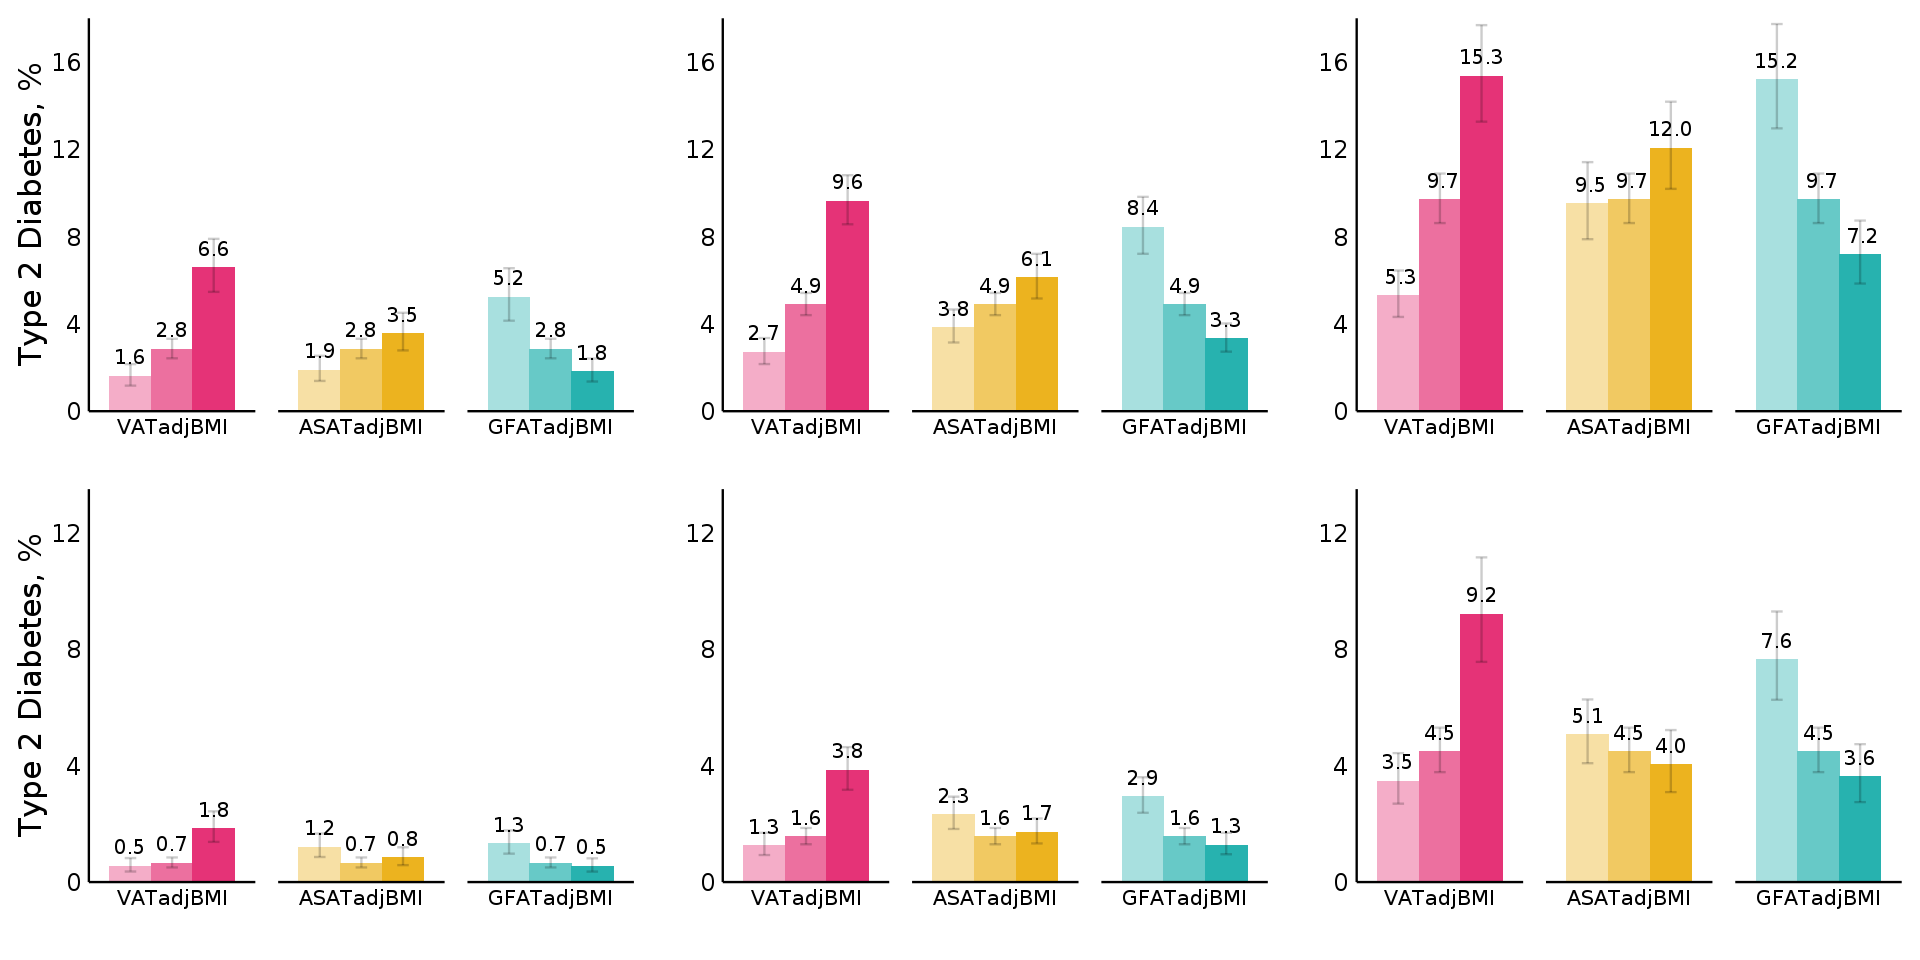

In [128]:
for(i in c('Male')){
    yaxIn <- TRUE
    for(j in c('Normal','Overweight','Obese')){
        if(j != 'Normal'){
            yaxIn <- FALSE
        }
        assign(paste0('plot','_',i,'_',j),
               sliderPlotWrapper_1(sliderDatWrapper(j,i,trainDat),
                                   eval(as.name(paste0('prev_T2D_plotter_',i))),yax=yaxIn))
    }
}

for(i in c('Female')){
    yaxIn <- TRUE
    for(j in c('Normal','Overweight','Obese')){
        if(j != 'Normal'){
            yaxIn <- FALSE
        }
        assign(paste0('plot','_',i,'_',j),
               sliderPlotWrapper_1_female(sliderDatWrapper(j,i,trainDat),
                                   eval(as.name(paste0('prev_T2D_plotter_',i))),yax=yaxIn))
    }
}

T2D_plots <- ((plot_Male_Normal)|(plot_Male_Overweight)|(plot_Male_Obese))/(plot_Female_Normal|(plot_Female_Overweight)|(plot_Female_Obese))
options(repr.plot.width=16,repr.plot.height=8)
T2D_plots

ggsave('/medpop/esp2/sagrawal/fat_distribution/2021.03.11_paperFigs/paper1_MLandEpi/revisions/quintilePlot_T2D_both_sex.pdf',
      T2D_plots,height=8,width=16)

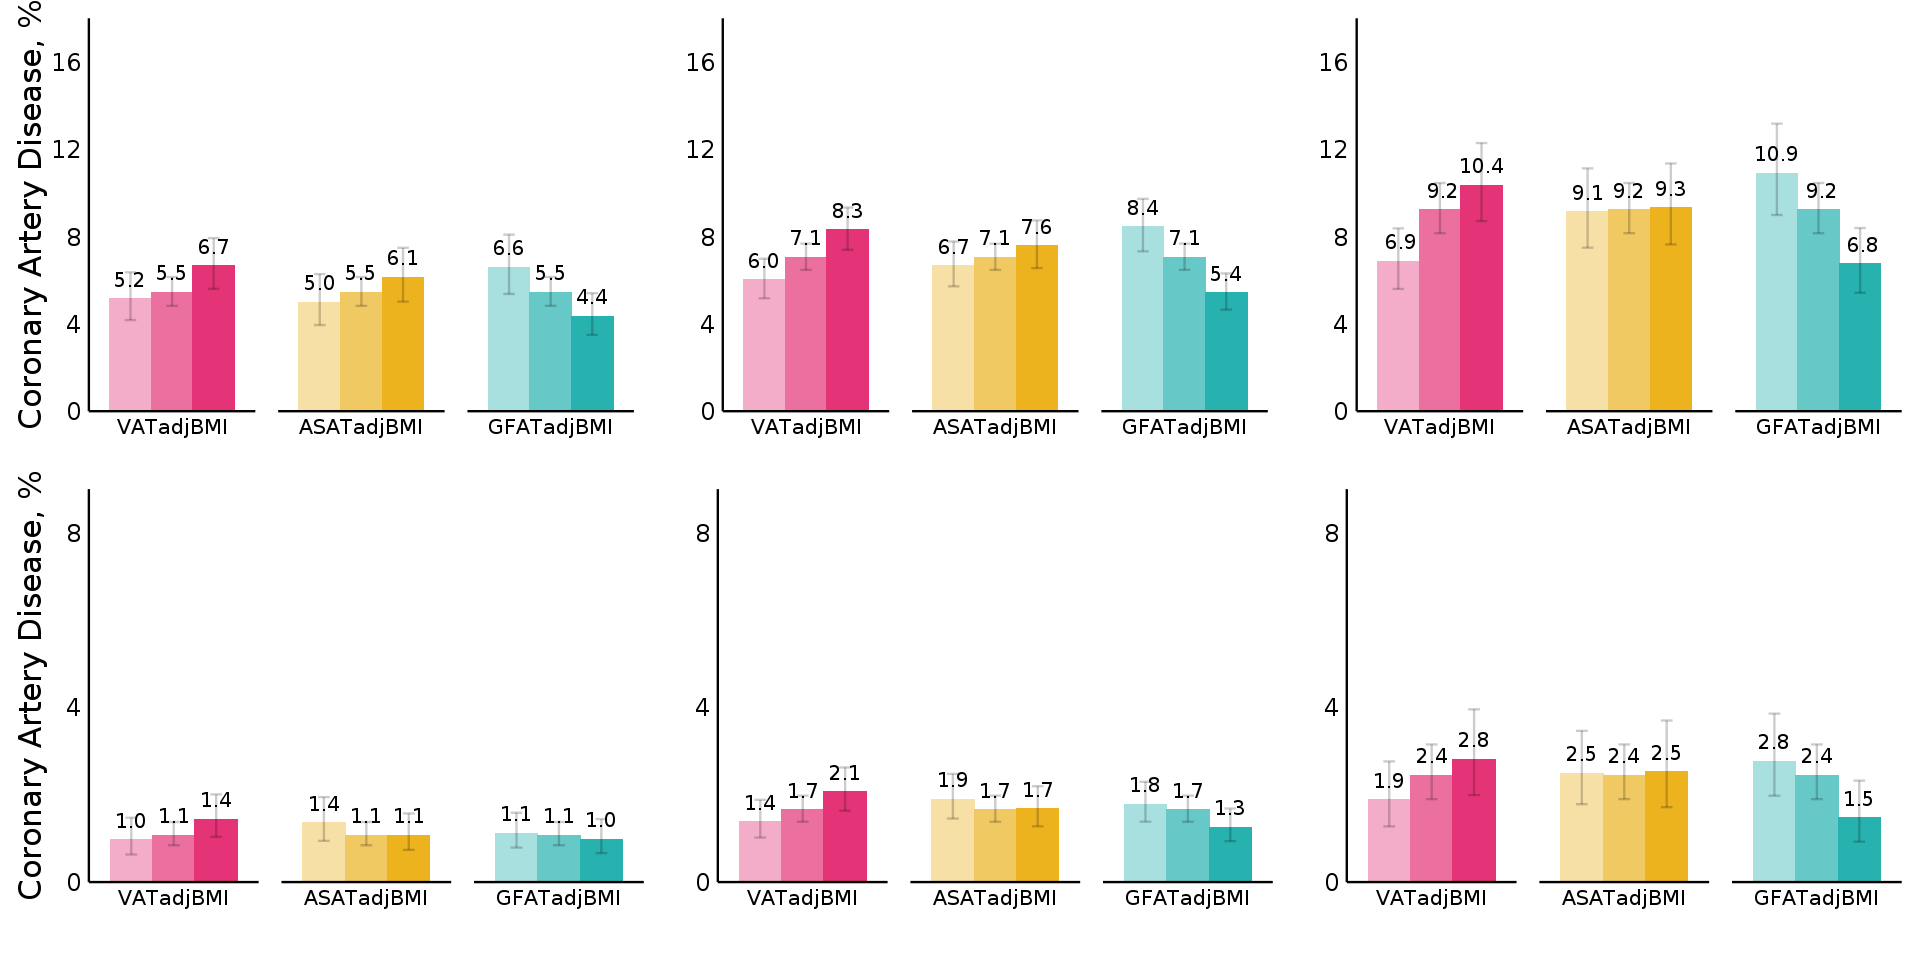

In [129]:
for(i in c('Male')){
    yaxIn <- TRUE
    for(j in c('Normal','Overweight','Obese')){
        if(j != 'Normal'){
            yaxIn <- FALSE
        }
        assign(paste0('plot','_',i,'_',j),
               sliderPlotWrapper_2(sliderDatWrapper(j,i,trainDat),
                                   eval(as.name(paste0('prev_CAD_plotter_',i))),yax=yaxIn))
    }
}

for(i in c('Female')){
    yaxIn <- TRUE
    for(j in c('Normal','Overweight','Obese')){
        if(j != 'Normal'){
            yaxIn <- FALSE
        }
        assign(paste0('plot','_',i,'_',j),
               sliderPlotWrapper_2_female(sliderDatWrapper(j,i,trainDat),
                                   eval(as.name(paste0('prev_CAD_plotter_',i))),yax=yaxIn))
    }
}

CAD_plots <- ((plot_Male_Normal)|(plot_Male_Overweight)|(plot_Male_Obese))/(plot_Female_Normal|plot_Female_Overweight|plot_Female_Obese)
options(repr.plot.width=16,repr.plot.height=8)
CAD_plots

ggsave('/medpop/esp2/sagrawal/fat_distribution/2021.03.11_paperFigs/paper1_MLandEpi/revisions/quintilePlot_CAD_both_sex.pdf',
      CAD_plots,height=8,width=16)

## Incident T2D/CAD analysis

In [103]:
fatPhenoCovar_202109 <- fread('/medpop/esp2/sagrawal/fat_distribution/2021.03.11_datafreeze/fatPhenoCovar_202109outcome.csv')



In [104]:
fatPhenoCovar_202109[sex=='Male',vatadjbmi:=residuals(lm(vat~bmiCalc,fatPhenoCovar_202109[sex=='Male'],na.action = na.exclude))]
fatPhenoCovar_202109[sex=='Female',vatadjbmi:=residuals(lm(vat~bmiCalc,fatPhenoCovar_202109[sex=='Female'],na.action = na.exclude))]

fatPhenoCovar_202109[sex=='Male',asatadjbmi:=residuals(lm(asat~bmiCalc,fatPhenoCovar_202109[sex=='Male'],na.action = na.exclude))]
fatPhenoCovar_202109[sex=='Female',asatadjbmi:=residuals(lm(asat~bmiCalc,fatPhenoCovar_202109[sex=='Female'],na.action = na.exclude))]

fatPhenoCovar_202109[sex=='Male',gfatadjbmi:=residuals(lm(gfat~bmiCalc,fatPhenoCovar_202109[sex=='Male'],na.action = na.exclude))]
fatPhenoCovar_202109[sex=='Female',gfatadjbmi:=residuals(lm(gfat~bmiCalc,fatPhenoCovar_202109[sex=='Female'],na.action = na.exclude))]

fatNames <- c('vat','asat','gfat','vatadjbmi','asatadjbmi','gfatadjbmi','bmiCalc')

for(i in 1:length(fatNames)){
    fatPhenoCovar_202109[,paste0(fatNames[i],'Scaled'):=scale(eval(as.name(fatNames[i]))),by=sex]
}

fatPhenoCovar_202109[,mriNum_141243:=ifelse(mriNum==141243,1,0)]
fatPhenoCovar_202109[,mriNum_141631:=ifelse(mriNum==141631,1,0)]

In [105]:
inc_T2D_surv <- coxph(Surv(fu_T2D_202109,inc_T2D_202109)~age_instance2+
                     sex+
                     bmiCalcScaled+
                     vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+
                      mriNum_141243+mriNum_141631,
                     data=fatPhenoCovar_202109)

summary(inc_T2D_surv)

inc_CAD_surv <- coxph(Surv(fu_CAD_int_202109,inc_CAD_int_202109)~age_instance2+
                     sex+
                     bmiCalcScaled+
                     vatadjbmiScaled+asatadjbmiScaled+gfatadjbmiScaled+
                      mriNum_141243+mriNum_141631,
                     data=fatPhenoCovar_202109)

summary(inc_CAD_surv)

Call:
coxph(formula = Surv(fu_T2D_202109, inc_T2D_202109) ~ age_instance2 + 
    sex + bmiCalcScaled + vatadjbmiScaled + asatadjbmiScaled + 
    gfatadjbmiScaled + mriNum_141243 + mriNum_141631, data = fatPhenoCovar_202109)

  n= 36837, number of events= 227 
   (3193 observations deleted due to missingness)

                      coef exp(coef)  se(coef)      z Pr(>|z|)    
age_instance2     0.047198  1.048330  0.009863  4.786 1.70e-06 ***
sexMale           0.541922  1.719309  0.137022  3.955 7.65e-05 ***
bmiCalcScaled     0.698999  2.011739  0.052159 13.401  < 2e-16 ***
vatadjbmiScaled   0.370475  1.448422  0.054724  6.770 1.29e-11 ***
asatadjbmiScaled -0.044613  0.956368  0.063929 -0.698  0.48527    
gfatadjbmiScaled -0.176790  0.837956  0.063312 -2.792  0.00523 ** 
mriNum_141243     0.029335  1.029769  0.182801  0.160  0.87251    
mriNum_141631     0.345558  1.412778  0.245685  1.407  0.15957    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                 e

Call:
coxph(formula = Surv(fu_CAD_int_202109, inc_CAD_int_202109) ~ 
    age_instance2 + sex + bmiCalcScaled + vatadjbmiScaled + asatadjbmiScaled + 
        gfatadjbmiScaled + mriNum_141243 + mriNum_141631, data = fatPhenoCovar_202109)

  n= 36786, number of events= 588 
   (3244 observations deleted due to missingness)

                     coef exp(coef) se(coef)      z Pr(>|z|)    
age_instance2     0.06777   1.07012  0.00620 10.931  < 2e-16 ***
sexMale           0.97192   2.64302  0.09161 10.610  < 2e-16 ***
bmiCalcScaled     0.19608   1.21662  0.03910  5.014 5.32e-07 ***
vatadjbmiScaled   0.15446   1.16703  0.03919  3.942 8.09e-05 ***
asatadjbmiScaled  0.03917   1.03995  0.04718  0.830   0.4063    
gfatadjbmiScaled -0.09444   0.90988  0.04761 -1.984   0.0473 *  
mriNum_141243    -0.17229   0.84173  0.11687 -1.474   0.1404    
mriNum_141631     0.12742   1.13589  0.14943  0.853   0.3938    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                 exp(coe